# Import data

In [1]:
Save_path = "/content/drive/MyDrive/EECS6444"

In [2]:
!pip install -U kaleido


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.4 MB/s eta 0:00:00


In [3]:
pip install requests python-dotenv

In [4]:
pip install transformers torch datasets pandas

In [5]:
!pip install bertopic[sentence-transformers] -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 3.1 MB/s eta 0:00:00


In [6]:
!pip install wordcloud

In [7]:
pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 38.3 MB/s eta 0:00:00


In [8]:
from datasets import load_dataset
import pandas as pd
import requests
import os
from transformers import pipeline
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from nltk.corpus import stopwords
import nltk
import gensim
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import v_measure_score, adjusted_rand_score, silhouette_score
import umap
import hdbscan
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [9]:
# Load the dataset
dataset = load_dataset("SWE-bench/SWE-bench_lite")

# Check available splits
print(dataset)

# Convert a specific split (e.g., "test") to a pandas DataFrame
df = dataset["test"].to_pandas()


README.md: 0.00B [00:00, ?B/s]

data/dev-00000-of-00001.parquet:   0%|          | 0.00/107k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

Generating dev split:   0%|          | 0/23 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/300 [00:00<?, ? examples/s]

DatasetDict({
    dev: Dataset({
        features: ['repo', 'instance_id', 'base_commit', 'patch', 'test_patch', 'problem_statement', 'hints_text', 'created_at', 'version', 'FAIL_TO_PASS', 'PASS_TO_PASS', 'environment_setup_commit'],
        num_rows: 23
    })
    test: Dataset({
        features: ['repo', 'instance_id', 'base_commit', 'patch', 'test_patch', 'problem_statement', 'hints_text', 'created_at', 'version', 'FAIL_TO_PASS', 'PASS_TO_PASS', 'environment_setup_commit'],
        num_rows: 300
    })
})


In [10]:
df.head()

repo             instance_id  \
0  astropy/astropy  astropy__astropy-12907   
1  astropy/astropy  astropy__astropy-14182   
2  astropy/astropy  astropy__astropy-14365   
3  astropy/astropy  astropy__astropy-14995   
4  astropy/astropy   astropy__astropy-6938   

                                base_commit  \
0  d16bfe05a744909de4b27f5875fe0d4ed41ce607   
1  a5917978be39d13cd90b517e1de4e7a539ffaa48   
2  7269fa3e33e8d02485a647da91a5a2a60a06af61   
3  b16c7d12ccbc7b2d20364b89fb44285bcbfede54   
4  c76af9ed6bb89bfba45b9f5bc1e635188278e2fa   

                                               patch  \
0  diff --git a/astropy/modeling/separable.py b/a...   
1  diff --git a/astropy/io/ascii/rst.py b/astropy...   
2  diff --git a/astropy/io/ascii/qdp.py b/astropy...   
3  diff --git a/astropy/nddata/mixins/ndarithmeti...   
4  diff --git a/astropy/io/fits/fitsrec.py b/astr...   

                                          test_patch  \
0  diff --git a/astropy/modeling/tests/test_separ...   
1  diff --git a/astropy/io/ascii/tests/test_rst.p...   
2  diff --git a/astropy/io/ascii/tests/test_qdp.p...   
3  diff --git a/astropy/nddata/mixins/tests/test_...   
4  diff --git a/astropy/io/fits/tests/test_checks...   

                                   problem_statement  \
0  Modeling's `separability_matrix` does not comp...   
1  Please support header rows in RestructuredText...   
2  ascii.qdp Table format assumes QDP commands ar...   
3  In v5.3, NDDataRef mask propagation fails when...   
4  Possible bug in io.fits related to D exponents...   

                                          hints_text            created_at  \
0                                                     2022-03-03T15:14:54Z   
1                                                     2022-12-16T11:13:37Z   
2  Welcome to Astropy 👋 and thank you for your fi...  2023-02-06T19:20:34Z   
3  Welcome to Astropy 👋 and thank you for your fi...  2023-06-27T19:48:18Z   
4  It is tested with `astropy/io/fits/tests/test_...  2017-12-07T00:01:14Z   

  version                                       FAIL_TO_PASS  \
0     4.3  ["astropy/modeling/tests/test_separable.py::te...   
1     5.1  ["astropy/io/ascii/tests/test_rst.py::test_rst...   
2     5.1  ["astropy/io/ascii/tests/test_qdp.py::test_rou...   
3     5.2  ["astropy/nddata/mixins/tests/test_ndarithmeti...   
4     1.3  ["astropy/io/fits/tests/test_checksum.py::Test...   

                                        PASS_TO_PASS  \
0  ["astropy/modeling/tests/test_separable.py::te...   
1  ["astropy/io/ascii/tests/test_rst.py::test_rea...   
2  ["astropy/io/ascii/tests/test_qdp.py::test_get...   
3  ["astropy/nddata/mixins/tests/test_ndarithmeti...   
4  ["astropy/io/fits/tests/test_checksum.py::Test...   

                   environment_setup_commit  
0  298ccb478e6bf092953bca67a3d29dc6c35f6752  
1  5f74eacbcc7fff707a44d8eb58adaa514cb7dcb5  
2  5f74eacbcc7fff707a44d8eb58adaa514cb7dcb5  
3  362f6df12abf9bd769d4915fabf955c993ea22cf  
4  848c8fa21332abd66b44efe3cb48b72377fb32cc

In [11]:
len(df)

300

# GitHub Issue Labels

## Extract Labels

In [ ]:

# Load the AIC classifier (with truncation for long issues)
classifier = pipeline(
    "text-classification",
    model="vinaykarman/robertabase",
    return_all_scores=True,
    truncation=True,
    max_length=512
)

config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
# Mapping from model labels to human-readable
label_map = {
    "LABEL_0": "bug",
    "LABEL_1": "enhancement",
    "LABEL_2": "question"
}

# Function to classify a single problem statement
def classify_issue(text, threshold=0.0):
    """
    Returns top label and all label scores.
    threshold=0.0 ensures all scores are included
    """
    results = classifier(text)[0]  # pipeline returns a list of lists

    # Keep all label scores with mapped names
    all_scores = [{"label": label_map.get(r['label'], r['label']),
                   "score": r['score']} for r in results]

    # Get the top label (highest score)
    top = max(all_scores, key=lambda x: x['score'])

    return {"top_label": [top['label']],   # single-element list
            "top_score": top['score'],
            "all_scores": all_scores}      # list of dicts

In [ ]:
# 4️⃣ Apply to entire dataset
top_labels = []
top_scores = []
all_label_scores = []

for text in tqdm(df['problem_statement'], desc="Classifying issues"):
    res = classify_issue(text)
    top_labels.append(res['top_label'])
    top_scores.append(res['top_score'])
    all_label_scores.append(res['all_scores'])

df['predicted_labels'] = top_labels      # single-element list
df['predicted_scores'] = top_scores      # probability of top label
df['all_label_scores'] = all_label_scores  # all labels and their scores


Classifying issues: 100%|██████████| 300/300 [10:09<00:00,  2.03s/it]


In [ ]:
df['predicted_labels'] = df['predicted_labels'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
df.head()

repo             instance_id  \
0  astropy/astropy  astropy__astropy-12907   
1  astropy/astropy  astropy__astropy-14182   
2  astropy/astropy  astropy__astropy-14365   
3  astropy/astropy  astropy__astropy-14995   
4  astropy/astropy   astropy__astropy-6938   

                                base_commit  \
0  d16bfe05a744909de4b27f5875fe0d4ed41ce607   
1  a5917978be39d13cd90b517e1de4e7a539ffaa48   
2  7269fa3e33e8d02485a647da91a5a2a60a06af61   
3  b16c7d12ccbc7b2d20364b89fb44285bcbfede54   
4  c76af9ed6bb89bfba45b9f5bc1e635188278e2fa   

                                               patch  \
0  diff --git a/astropy/modeling/separable.py b/a...   
1  diff --git a/astropy/io/ascii/rst.py b/astropy...   
2  diff --git a/astropy/io/ascii/qdp.py b/astropy...   
3  diff --git a/astropy/nddata/mixins/ndarithmeti...   
4  diff --git a/astropy/io/fits/fitsrec.py b/astr...   

                                          test_patch  \
0  diff --git a/astropy/modeling/tests/test_separ...   
1  diff --git a/astropy/io/ascii/tests/test_rst.p...   
2  diff --git a/astropy/io/ascii/tests/test_qdp.p...   
3  diff --git a/astropy/nddata/mixins/tests/test_...   
4  diff --git a/astropy/io/fits/tests/test_checks...   

                                   problem_statement  \
0  Modeling's `separability_matrix` does not comp...   
1  Please support header rows in RestructuredText...   
2  ascii.qdp Table format assumes QDP commands ar...   
3  In v5.3, NDDataRef mask propagation fails when...   
4  Possible bug in io.fits related to D exponents...   

                                          hints_text            created_at  \
0                                                     2022-03-03T15:14:54Z   
1                                                     2022-12-16T11:13:37Z   
2  Welcome to Astropy 👋 and thank you for your fi...  2023-02-06T19:20:34Z   
3  Welcome to Astropy 👋 and thank you for your fi...  2023-06-27T19:48:18Z   
4  It is tested with `astropy/io/fits/tests/test_...  2017-12-07T00:01:14Z   

  version                                       FAIL_TO_PASS  \
0     4.3  ["astropy/modeling/tests/test_separable.py::te...   
1     5.1  ["astropy/io/ascii/tests/test_rst.py::test_rst...   
2     5.1  ["astropy/io/ascii/tests/test_qdp.py::test_rou...   
3     5.2  ["astropy/nddata/mixins/tests/test_ndarithmeti...   
4     1.3  ["astropy/io/fits/tests/test_checksum.py::Test...   

                                        PASS_TO_PASS  \
0  ["astropy/modeling/tests/test_separable.py::te...   
1  ["astropy/io/ascii/tests/test_rst.py::test_rea...   
2  ["astropy/io/ascii/tests/test_qdp.py::test_get...   
3  ["astropy/nddata/mixins/tests/test_ndarithmeti...   
4  ["astropy/io/fits/tests/test_checksum.py::Test...   

                   environment_setup_commit predicted_labels  \
0  298ccb478e6bf092953bca67a3d29dc6c35f6752              bug   
1  5f74eacbcc7fff707a44d8eb58adaa514cb7dcb5      enhancement   
2  5f74eacbcc7fff707a44d8eb58adaa514cb7dcb5              bug   
3  362f6df12abf9bd769d4915fabf955c993ea22cf              bug   
4  848c8fa21332abd66b44efe3cb48b72377fb32cc              bug   

   predicted_scores                                   all_label_scores  
0          0.792346  [{'label': 'bug', 'score': 0.7923456430435181}...  
1          0.999485  [{'label': 'bug', 'score': 0.00020413256424944...  
2          0.998833  [{'label': 'bug', 'score': 0.9988325238227844}...  
3          0.999328  [{'label': 'bug', 'score': 0.9993282556533813}...  
4          0.999293  [{'label': 'bug', 'score': 0.999293327331543},...

## Analysis of issues labels

In [ ]:
# Count the number of issues per predicted label
label_counts = df['predicted_labels'].value_counts()
print(label_counts)

predicted_labels
bug            226
enhancement     60
question        14
Name: count, dtype: int64


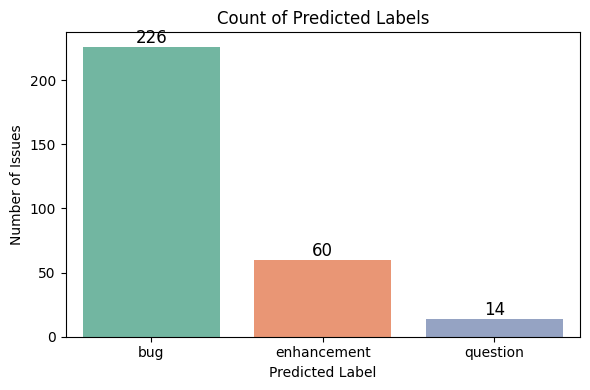

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
ax = sns.countplot(x='predicted_labels', data=df, palette='Set2')

# Add counts on top of each bar
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}',
                (p.get_x() + p.get_width() / 2., count),  # position
                ha='center', va='bottom', fontsize=12)

plt.title("Count of Predicted Labels")
plt.xlabel("Predicted Label")
plt.ylabel("Number of Issues")
# Save as PDF
plt.tight_layout()
plt.savefig(Save_path + "/predicted_labels_count.pdf")  # saves the figure
plt.savefig(Save_path + "/predicted_labels_count.png")
plt.show()


In [ ]:
# Summary statistics
print(df['predicted_scores'].describe())


count    300.000000
mean       0.976342
std        0.072885
min        0.548640
25%        0.998068
50%        0.999152
75%        0.999323
max        0.999677
Name: predicted_scores, dtype: float64


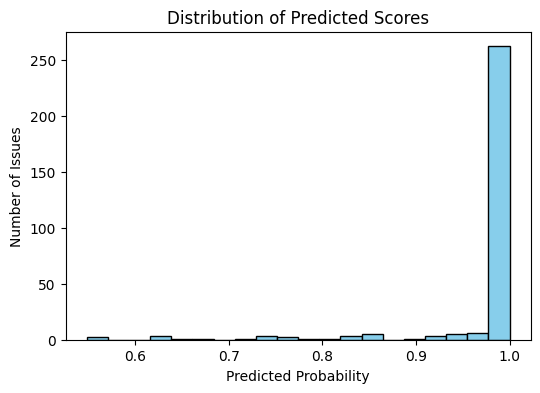

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(df['predicted_scores'], bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Predicted Scores")
plt.xlabel("Predicted Probability")
plt.ylabel("Number of Issues")
plt.show()


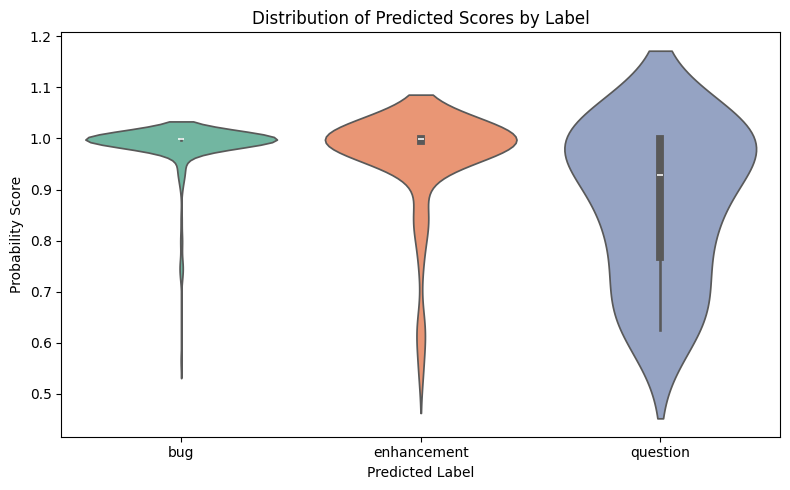

In [ ]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.violinplot(x='predicted_labels', y='predicted_scores', data=df, palette='Set2')
plt.title("Distribution of Predicted Scores by Label")
plt.xlabel("Predicted Label")
plt.ylabel("Probability Score")
plt.tight_layout()
plt.savefig("predicted_scores_vilon.pdf")
plt.savefig("predicted_scores_vilon.png")
plt.show()


In [ ]:
df.to_csv(Save_path + "/0_df_with_GH_labels.csv", index=False)

# Simple word cloud

In [ ]:
texts = df["problem_statement"].fillna("").tolist()

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all problem statements into a single string
all_text = " ".join(texts)

# Generate the word cloud
wc = WordCloud(width=800, height=400, background_color='white', stopwords=None, collocations=False).generate(all_text)

# Display the word cloud
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Problem Statements")
plt.show()


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt

# Define ngram ranges for unigrams, bigrams, and trigrams
ngram_ranges = [(1,1), (2,2), (3,3)]
colors = ['skyblue', 'salmon', 'lightgreen']

plt.figure(figsize=(12,10))

for i, ngram_range in enumerate(ngram_ranges):
    vectorizer = CountVectorizer(stop_words='english', ngram_range=ngram_range, max_features=15)
    X = vectorizer.fit_transform(texts)

    counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out()).sum().sort_values(ascending=True)

    # Plot horizontal bar chart
    plt.barh(counts.index, counts.values, color=colors[i], alpha=0.7, label=f"{ngram_range[0]}-gram")

plt.title("Top Unigrams, Bigrams, and Trigrams in Problem Statements")
plt.xlabel("Frequency")
plt.legend()
plt.show()


# Topic Modelling of problem statement

We cannot use easily LDA because we dont know the number of topics

## Bertopics: 5 topics


In [ ]:
# Download NLTK stopwords
nltk.download('stopwords')

# Combine general English stopwords with domain-specific ones
stop_words = list(stopwords.words('english'))
# domain_stopwords = {"file", "line", "python", "import", "condaforge"}  # Add more if needed
# stop_words = stop_words.union(domain_stopwords)

In [ ]:
# Use CountVectorizer with stopwords
vectorizer_model = CountVectorizer(stop_words=stop_words)

# Create BERTopic model
topic_model = BERTopic(vectorizer_model=vectorizer_model, language="english", calculate_probabilities=True)

# Fit the model to your problem statements
topics, probs = topic_model.fit_transform(texts)

In [ ]:
# Get topic info
topic_info = topic_model.get_topic_info()
print(len(topic_info))
print(topic_info.head(10))  # Top 10 topics


In [ ]:
# visualize top words for top topics
topic_model.visualize_barchart(top_n_topics=10)

In [ ]:
# Hierarchical clustering of topics
topic_model.visualize_hierarchy()

shows a dendrogram-like tree of topics, so you can see:

Which topics are closely related.

Subtopics branching from major themes.

In [ ]:
# Optional: assign topics back to your DataFrame
df['bert_topic'] = topics
df['bert_topic'].value_counts()

-1 means that the document was not assigned to any meaningful topic

In [ ]:
df.head()

In [ ]:
df["repo"].head()

In [ ]:
dist_pct = (
    df.groupby(["repo", "bert_topic"]).size()
      .unstack(fill_value=0)
)

# normalize rows
dist_pct = dist_pct.div(dist_pct.sum(axis=1), axis=0)

# FIX MULTIINDEX PROBLEM
dist_pct = dist_pct.reset_index()
dist_pct = dist_pct.set_index("repo")

# plot and capture Axes
ax = dist_pct.plot(kind="bar", stacked=True, figsize=(10,6))

# set title on Axes
ax.set_title("BERT Topic Distribution Over Repos")

# rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.legend(title="BERT Topic", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# save figure
plt.savefig(Save_path + "/bertopi_dist_over_repos.pdf")
plt.savefig(Save_path + "/bertopi_dist_over_repos.png")
plt.show()


## LDA: 12 topics

In [ ]:
# Create CountVectorizer (removing English stopwords)
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(texts)

feature_names = vectorizer.get_feature_names_out()


### according to perprexility we have about 15 topics

In [ ]:
## find number of topics using elbow method, we want low perplexity
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

topic_range = range(2, 50)  # Try 2 to 14 topics
perplexities = []

for n_topics in topic_range:
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(X)
    perplexities.append(lda.perplexity(X))

# Plot perplexity vs number of topics
plt.figure(figsize=(8,5))
plt.plot(topic_range, perplexities, marker='o')
plt.xlabel("Number of topics")
plt.ylabel("Perplexity")
plt.title("LDA Perplexity for Different Number of Topics")
plt.show()


according to perprexility we have about 15 topics

### according to coherence we have about 10 topics

In [ ]:
### using coherence
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
domain_stopwords = {"file", "line", "python", "import", "condaforge"}
stop_words = stop_words.union(domain_stopwords)

# Tokenize and remove stopwords
def preprocess(text):
    return [word for word in simple_preprocess(text) if word not in stop_words]

texts_tokens = [preprocess(doc) for doc in texts]


In [ ]:
# Create dictionary
dictionary = Dictionary(texts_tokens)

# Filter extremes to remove very rare or very common words
dictionary.filter_extremes(no_below=2, no_above=0.5)

# Create Bag-of-Words corpus
corpus = [dictionary.doc2bow(text) for text in texts_tokens]


In [ ]:
topic_range = range(2, 50)
coherence_scores = []

for num_topics in topic_range:
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=42,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)

    coherence_model = CoherenceModel(model=lda_model, texts=texts_tokens, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

# Plot coherence scores
plt.figure(figsize=(8,5))
plt.plot(topic_range, coherence_scores, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.title("LDA Coherence for Different Number of Topics")
plt.show()


### Fitting LDA

using both method, we average the number of topics to 12

In [ ]:
best_num_topics = 12

In [ ]:
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=best_num_topics,
                     random_state=42,
                     passes=10,
                     alpha='auto')

# Print top words per topic
for idx, topic in lda_model.show_topics(num_topics=best_num_topics, num_words=10, formatted=False):
    top_words = [word for word, _ in topic]
    print(f"Topic {idx+1}: {', '.join(top_words)}")

In [ ]:
doc_topics = [max(lda_model.get_document_topics(bow), key=lambda x: x[1])[0] for bow in corpus]
df['lda_topic'] = doc_topics
df['lda_topic'].value_counts()


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Suppose lda_model is your fitted Gensim LDA model
# dictionary is your gensim Dictionary

num_topics = lda_model.num_topics

for i in range(num_topics):
    plt.figure(figsize=(8,6))
    plt.title(f"WordCloud for Topic {i+1}")

    # Get top words and their weights
    topic_terms = dict(lda_model.show_topic(i, topn=50))  # top 50 words
    wc = WordCloud(width=800, height=400, background_color='white')
    wc.generate_from_frequencies(topic_terms)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()


In [ ]:
df.head()

In [ ]:
dist_pct = (
    df.groupby(["repo", "lda_topic"]).size()
      .unstack(fill_value=0)
)

# normalize rows
dist_pct = dist_pct.div(dist_pct.sum(axis=1), axis=0)

# FIX MULTIINDEX PROBLEM
dist_pct = dist_pct.reset_index()
dist_pct = dist_pct.set_index("repo")

# plot and capture Axes
ax = dist_pct.plot(kind="bar", stacked=True, figsize=(10,6))

# set title on Axes
ax.set_title("LDA Topic Distribution Over Repos")

# rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.legend(title="LDA Topic", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# save figure
plt.savefig(Save_path + "/LDA_dist_over_repos.pdf")
plt.savefig(Save_path + "/LDA_dist_over_repos.png")
plt.show()


In [ ]:
df.to_csv(Save_path + "/df_with_topics.csv", index=False)

# PCA of problem statement

In [ ]:
df = pd.read_csv(Save_path + "/df_with_topics.csv")
df.head()

repo             instance_id  \
0  astropy/astropy  astropy__astropy-12907   
1  astropy/astropy  astropy__astropy-14182   
2  astropy/astropy  astropy__astropy-14365   
3  astropy/astropy  astropy__astropy-14995   
4  astropy/astropy   astropy__astropy-6938   

                                base_commit  \
0  d16bfe05a744909de4b27f5875fe0d4ed41ce607   
1  a5917978be39d13cd90b517e1de4e7a539ffaa48   
2  7269fa3e33e8d02485a647da91a5a2a60a06af61   
3  b16c7d12ccbc7b2d20364b89fb44285bcbfede54   
4  c76af9ed6bb89bfba45b9f5bc1e635188278e2fa   

                                               patch  \
0  diff --git a/astropy/modeling/separable.py b/a...   
1  diff --git a/astropy/io/ascii/rst.py b/astropy...   
2  diff --git a/astropy/io/ascii/qdp.py b/astropy...   
3  diff --git a/astropy/nddata/mixins/ndarithmeti...   
4  diff --git a/astropy/io/fits/fitsrec.py b/astr...   

                                          test_patch  \
0  diff --git a/astropy/modeling/tests/test_separ...   
1  diff --git a/astropy/io/ascii/tests/test_rst.p...   
2  diff --git a/astropy/io/ascii/tests/test_qdp.p...   
3  diff --git a/astropy/nddata/mixins/tests/test_...   
4  diff --git a/astropy/io/fits/tests/test_checks...   

                                   problem_statement  \
0  Modeling's `separability_matrix` does not comp...   
1  Please support header rows in RestructuredText...   
2  ascii.qdp Table format assumes QDP commands ar...   
3  In v5.3, NDDataRef mask propagation fails when...   
4  Possible bug in io.fits related to D exponents...   

                                          hints_text            created_at  \
0                                                NaN  2022-03-03T15:14:54Z   
1                                                NaN  2022-12-16T11:13:37Z   
2  Welcome to Astropy 👋 and thank you for your fi...  2023-02-06T19:20:34Z   
3  Welcome to Astropy 👋 and thank you for your fi...  2023-06-27T19:48:18Z   
4  It is tested with `astropy/io/fits/tests/test_...  2017-12-07T00:01:14Z   

   version                                       FAIL_TO_PASS  \
0      4.3  ["astropy/modeling/tests/test_separable.py::te...   
1      5.1  ["astropy/io/ascii/tests/test_rst.py::test_rst...   
2      5.1  ["astropy/io/ascii/tests/test_qdp.py::test_rou...   
3      5.2  ["astropy/nddata/mixins/tests/test_ndarithmeti...   
4      1.3  ["astropy/io/fits/tests/test_checksum.py::Test...   

                                        PASS_TO_PASS  \
0  ["astropy/modeling/tests/test_separable.py::te...   
1  ["astropy/io/ascii/tests/test_rst.py::test_rea...   
2  ["astropy/io/ascii/tests/test_qdp.py::test_get...   
3  ["astropy/nddata/mixins/tests/test_ndarithmeti...   
4  ["astropy/io/fits/tests/test_checksum.py::Test...   

                   environment_setup_commit predicted_labels  \
0  298ccb478e6bf092953bca67a3d29dc6c35f6752              bug   
1  5f74eacbcc7fff707a44d8eb58adaa514cb7dcb5      enhancement   
2  5f74eacbcc7fff707a44d8eb58adaa514cb7dcb5              bug   
3  362f6df12abf9bd769d4915fabf955c993ea22cf              bug   
4  848c8fa21332abd66b44efe3cb48b72377fb32cc              bug   

   predicted_scores                                   all_label_scores  \
0          0.792346  [{'label': 'bug', 'score': 0.7923456430435181}...   
1          0.999485  [{'label': 'bug', 'score': 0.00020413256424944...   
2          0.998833  [{'label': 'bug', 'score': 0.9988325238227844}...   
3          0.999328  [{'label': 'bug', 'score': 0.9993282556533813}...   
4          0.999293  [{'label': 'bug', 'score': 0.999293327331543},...   

   bert_topic  lda_topic  
0           4         11  
1           4          5  
2           0          5  
3           4          5  
4           1          9

In [ ]:
RANDOM_STATE = 42
EMBED_MODEL = "all-mpnet-base-v2"
PCA_NCOMP = 50
TFIDF_MAX_FEATURES = 20000
UMAP_N_NEIGHBORS = 15
UMAP_MIN_DIST = 0.1
HDBSCAN_MIN_CLUSTER_SIZE = 5

In [ ]:
def clean_issue_text(text):
    if not isinstance(text, str):
        return ""
    # remove HTML tags
    text = re.sub(r"<[^>]+>", " ", text)
    # normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()
    # optional: lowercase
    text = text.lower()
    return text
df['text_clean'] = df['problem_statement'].apply(clean_issue_text)


In [ ]:
print("Loading embedding model:", EMBED_MODEL)
model = SentenceTransformer(EMBED_MODEL)

# encode in batches (SentenceTransformer handles batching)
texts = df['text_clean'].tolist()
embeddings = model.encode(texts, batch_size=64, show_progress_bar=True, convert_to_numpy=True)
print("Embeddings shape:", embeddings.shape)

Loading embedding model: all-mpnet-base-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Embeddings shape: (300, 768)


In [ ]:
PCA_NCOMP = 200
print("Running PCA with n_components =", PCA_NCOMP)
pca = PCA(n_components=min(PCA_NCOMP, embeddings.shape[1]), random_state=RANDOM_STATE)
pca_proj = pca.fit_transform(embeddings)  # shape (n_docs, n_components)

Running PCA with n_components = 200


Reduced to 200 components from 768

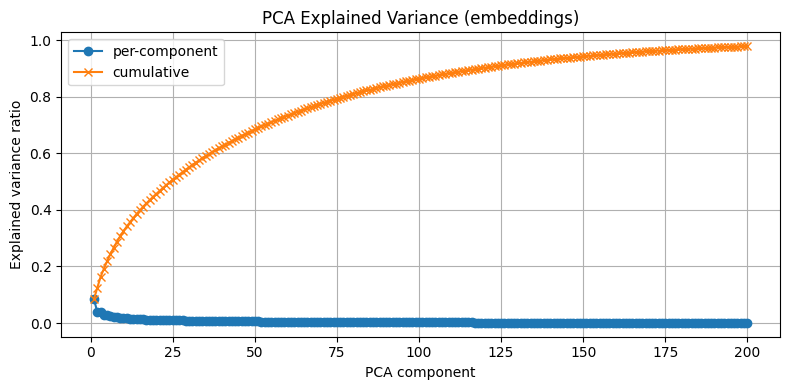

In [ ]:
explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

plt.figure(figsize=(8,4))
plt.plot(np.arange(1, len(explained)+1), explained, marker='o', label='per-component')
plt.plot(np.arange(1, len(explained)+1), cum_explained, marker='x', label='cumulative')
plt.xlabel('PCA component')
plt.ylabel('Explained variance ratio')
plt.title('PCA Explained Variance (embeddings)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

embeddings have a few moderately informative directions, but after ~10 components each new component adds very little information.

with 200 PCA components, we  only capture about 100% of the total variance.

the  embedding space is fairly “spread out”; no small subset of PCs captures the majority of its structure.

Around 20–30  keeps enough structure (~45–55% variance) while removing noise

In [ ]:
PCA_NCOMP = 25
print("Running PCA with n_components =", PCA_NCOMP)
pca = PCA(n_components=min(PCA_NCOMP, embeddings.shape[1]), random_state=RANDOM_STATE)
pca_proj = pca.fit_transform(embeddings)  # shape (n_docs, n_components)

Running PCA with n_components = 25


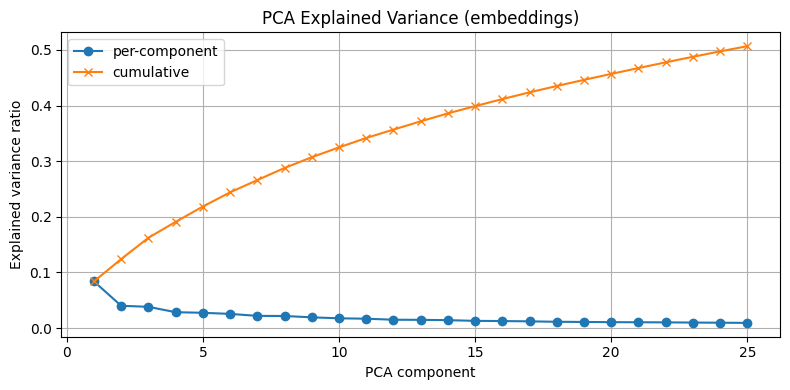

In [ ]:
explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

plt.figure(figsize=(8,4))
plt.plot(np.arange(1, len(explained)+1), explained, marker='o', label='per-component')
plt.plot(np.arange(1, len(explained)+1), cum_explained, marker='x', label='cumulative')
plt.xlabel('PCA component')
plt.ylabel('Explained variance ratio')
plt.title('PCA Explained Variance (embeddings)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Variance retained with 25 components: 50.67%


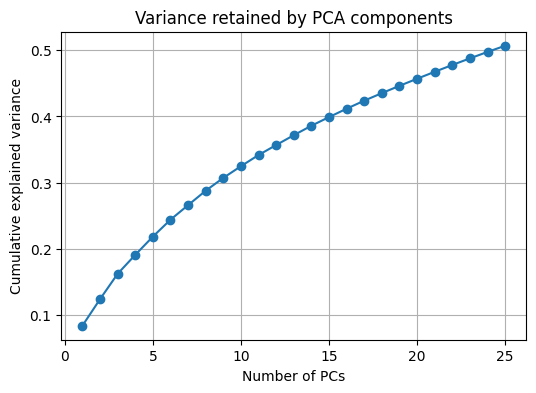

In [ ]:
import numpy as np

# fraction of variance explained by first 50 PCs
variance_ratio = np.sum(pca.explained_variance_ratio_)
print(f"Variance retained with 25 components: {variance_ratio:.2%}")

# optional: cumulative plot
import matplotlib.pyplot as plt
cum_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(cum_variance)+1), cum_variance, marker='o')
plt.xlabel("Number of PCs")
plt.ylabel("Cumulative explained variance")
plt.title("Variance retained by PCA components")
plt.grid(True)
plt.show()


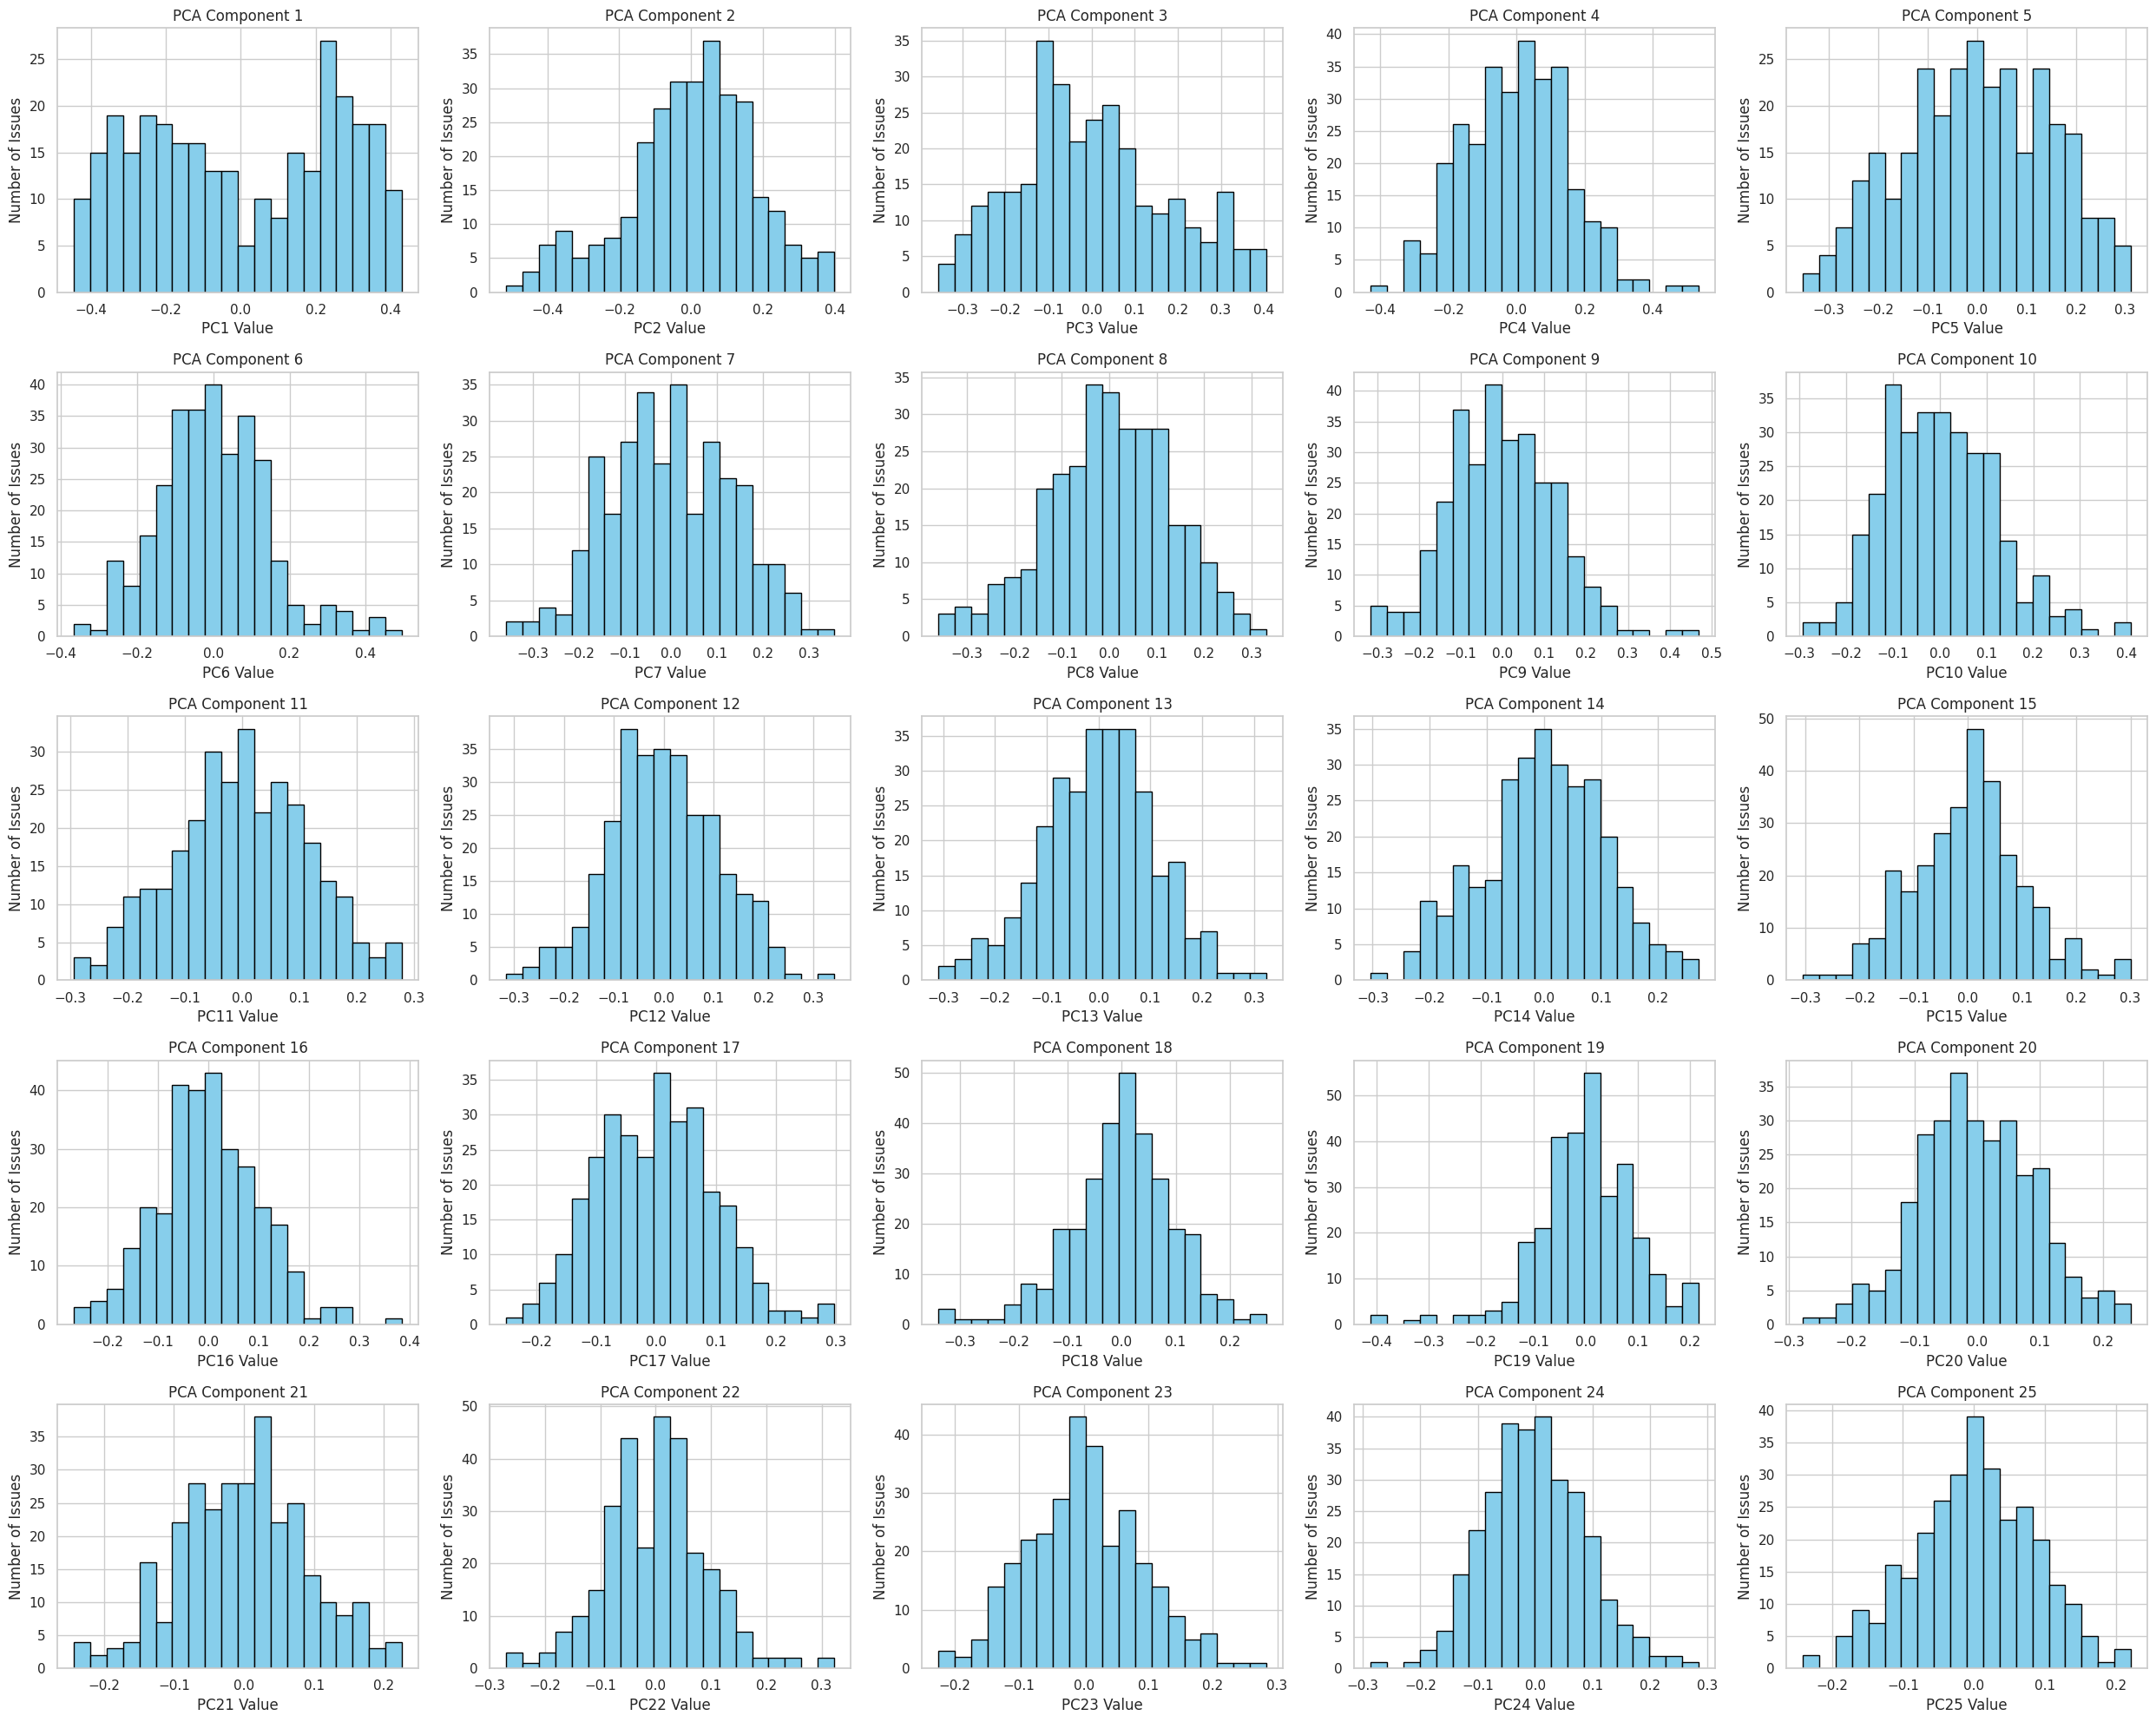

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid")
n_pcs = pca_proj.shape[1]  # 25
clusters = df['hdbscan_cluster'] if 'hdbscan_cluster' in df.columns else None

plt.figure(figsize=(25, 20))  # large figure for 5x5 grid

for i in range(n_pcs):
    plt.subplot(5, 5, i+1)

    if clusters is not None:
        # stacked histogram by cluster
        sns.histplot(
            x=pca_proj[:, i],
            hue=clusters,
            bins=20,
            palette='tab10',
            multiple='stack'
        )
    else:
        # plain histogram
        plt.hist(pca_proj[:, i], bins=20, color='skyblue', edgecolor='black')

    plt.xlabel(f"PC{i+1} Value")
    plt.ylabel("Number of Issues")
    plt.title(f"PCA Component {i+1}")

plt.tight_layout()
plt.show()


## K Means

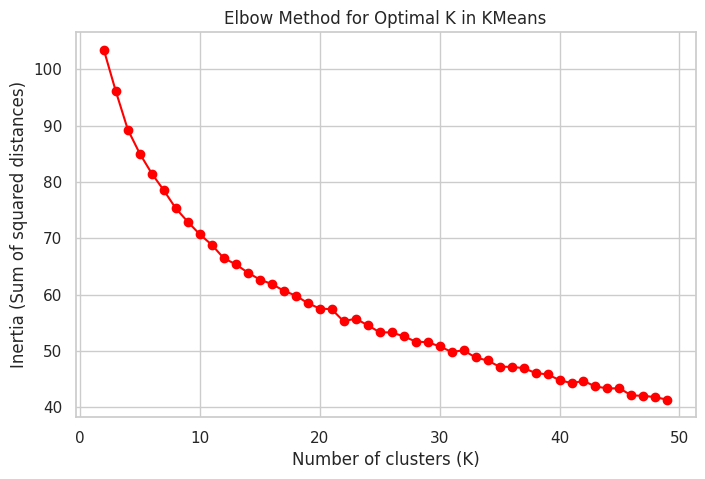

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# PCA-reduced embeddings
X = pca_proj  # shape (n_docs, n_components)

# Range of K to test
K_range = range(2, 50)  # try 2 to 20 clusters
inertia = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# -------------------------
# Plot elbow curve
# -------------------------
plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o', color='red')
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia (Sum of squared distances)")
plt.title("Elbow Method for Optimal K in KMeans")
plt.grid(True)
plt.show()


In [ ]:
optimal_k = 10  # replace with K you pick from elbow
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['kmeans_cluster'] = kmeans.fit_predict(X)

# Check cluster counts
print(df['kmeans_cluster'].value_counts())


kmeans_cluster
2    38
7    37
1    34
8    34
6    30
5    27
0    26
3    26
4    26
9    22
Name: count, dtype: int64


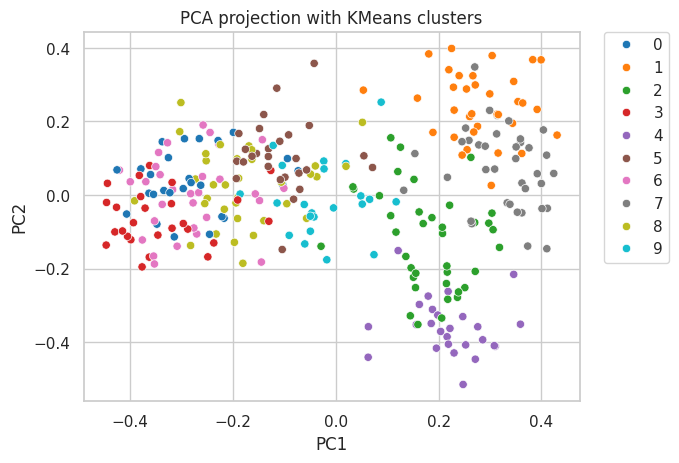

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(
    x=pca_proj[:,0],
    y=pca_proj[:,1],
    hue=df['kmeans_cluster'],
    palette='tab10'
)

# Move legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA projection with KMeans clusters')
plt.show()


## HDBSCAN


In [ ]:
import hdbscan

# Parameters
min_cluster_size = 10  # minimum size for a cluster
min_samples = 3        # controls how conservative clustering is
metric = 'euclidean'    # distance metric

# Run HDBSCAN
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=min_cluster_size,
    min_samples=min_samples,
    metric=metric
)
df['hdbscan_cluster'] = clusterer.fit_predict(pca_proj)  # or umap_2d


In [ ]:
print("Cluster counts:")
print(df['hdbscan_cluster'].value_counts())


Cluster counts:
hdbscan_cluster
 3    105
-1     84
 1     84
 2     14
 0     13
Name: count, dtype: int64


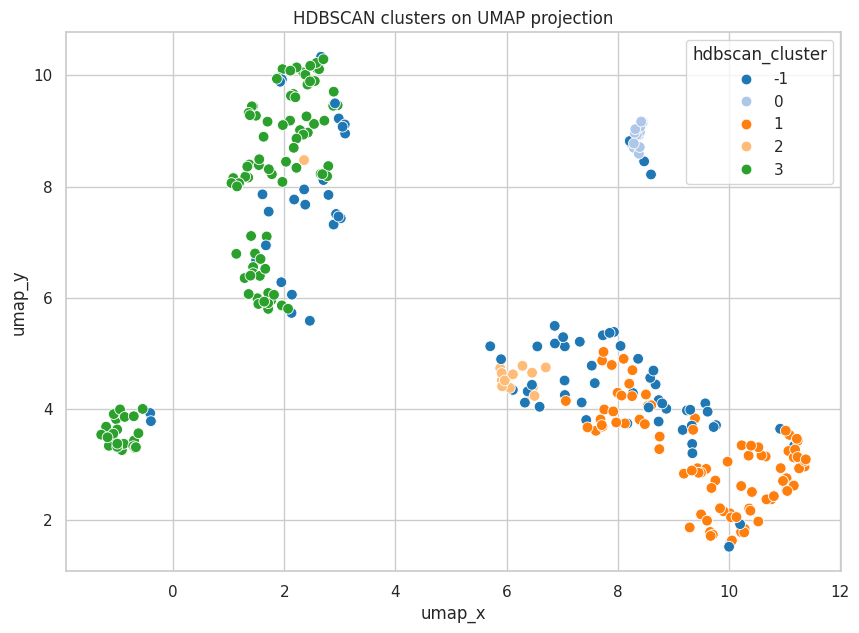

In [ ]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# 2D UMAP
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
umap_2d = reducer.fit_transform(pca_proj)  # or original embeddings
df['umap_x'], df['umap_y'] = umap_2d[:,0], umap_2d[:,1]

# Plot clusters
plt.figure(figsize=(10,7))
sns.scatterplot(
    x='umap_x', y='umap_y',
    hue='hdbscan_cluster',
    palette='tab20',
    data=df,
    s=60
)
plt.title("HDBSCAN clusters on UMAP projection")
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score

# Only compute silhouette for non-noise points
mask = df['hdbscan_cluster'] != -1
score = silhouette_score(pca_proj[mask], df.loc[mask, 'hdbscan_cluster'])
print("Silhouette score (non-noise points):", score)


Silhouette score (non-noise points): 0.16684341


Separation less than 0.5 --> not very good

HDBSCAN found dense regions, but many issues share semantic similarity across clusters.

In [ ]:
df.head()

repo             instance_id  \
0  astropy/astropy  astropy__astropy-12907   
1  astropy/astropy  astropy__astropy-14182   
2  astropy/astropy  astropy__astropy-14365   
3  astropy/astropy  astropy__astropy-14995   
4  astropy/astropy   astropy__astropy-6938   

                                base_commit  \
0  d16bfe05a744909de4b27f5875fe0d4ed41ce607   
1  a5917978be39d13cd90b517e1de4e7a539ffaa48   
2  7269fa3e33e8d02485a647da91a5a2a60a06af61   
3  b16c7d12ccbc7b2d20364b89fb44285bcbfede54   
4  c76af9ed6bb89bfba45b9f5bc1e635188278e2fa   

                                               patch  \
0  diff --git a/astropy/modeling/separable.py b/a...   
1  diff --git a/astropy/io/ascii/rst.py b/astropy...   
2  diff --git a/astropy/io/ascii/qdp.py b/astropy...   
3  diff --git a/astropy/nddata/mixins/ndarithmeti...   
4  diff --git a/astropy/io/fits/fitsrec.py b/astr...   

                                          test_patch  \
0  diff --git a/astropy/modeling/tests/test_separ...   
1  diff --git a/astropy/io/ascii/tests/test_rst.p...   
2  diff --git a/astropy/io/ascii/tests/test_qdp.p...   
3  diff --git a/astropy/nddata/mixins/tests/test_...   
4  diff --git a/astropy/io/fits/tests/test_checks...   

                                   problem_statement  \
0  Modeling's `separability_matrix` does not comp...   
1  Please support header rows in RestructuredText...   
2  ascii.qdp Table format assumes QDP commands ar...   
3  In v5.3, NDDataRef mask propagation fails when...   
4  Possible bug in io.fits related to D exponents...   

                                          hints_text            created_at  \
0                                                NaN  2022-03-03T15:14:54Z   
1                                                NaN  2022-12-16T11:13:37Z   
2  Welcome to Astropy 👋 and thank you for your fi...  2023-02-06T19:20:34Z   
3  Welcome to Astropy 👋 and thank you for your fi...  2023-06-27T19:48:18Z   
4  It is tested with `astropy/io/fits/tests/test_...  2017-12-07T00:01:14Z   

   version                                       FAIL_TO_PASS  ...  \
0      4.3  ["astropy/modeling/tests/test_separable.py::te...  ...   
1      5.1  ["astropy/io/ascii/tests/test_rst.py::test_rst...  ...   
2      5.1  ["astropy/io/ascii/tests/test_qdp.py::test_rou...  ...   
3      5.2  ["astropy/nddata/mixins/tests/test_ndarithmeti...  ...   
4      1.3  ["astropy/io/fits/tests/test_checksum.py::Test...  ...   

  predicted_labels predicted_scores  \
0              bug         0.792346   
1      enhancement         0.999485   
2              bug         0.998833   
3              bug         0.999328   
4              bug         0.999293   

                                    all_label_scores  bert_topic lda_topic  \
0  [{'label': 'bug', 'score': 0.7923456430435181}...           4        11   
1  [{'label': 'bug', 'score': 0.00020413256424944...           4         5   
2  [{'label': 'bug', 'score': 0.9988325238227844}...           0         5   
3  [{'label': 'bug', 'score': 0.9993282556533813}...           4         5   
4  [{'label': 'bug', 'score': 0.999293327331543},...           1         9   

                                          text_clean  kmeans_cluster  \
0  modeling's `separability_matrix` does not comp...               2   
1  please support header rows in restructuredtext...               5   
2  ascii.qdp table format assumes qdp commands ar...               7   
3  in v5.3, nddataref mask propagation fails when...               2   
4  possible bug in io.fits related to d exponents...               2   

  hdbscan_cluster    umap_x    umap_y  
0              -1  1.607771  7.859745  
1              -1  7.047937  5.124933  
2              -1  6.869792  5.177204  
3               3  1.402160  7.111073  
4              -1  6.865752  5.493959  

[5 rows x 22 columns]

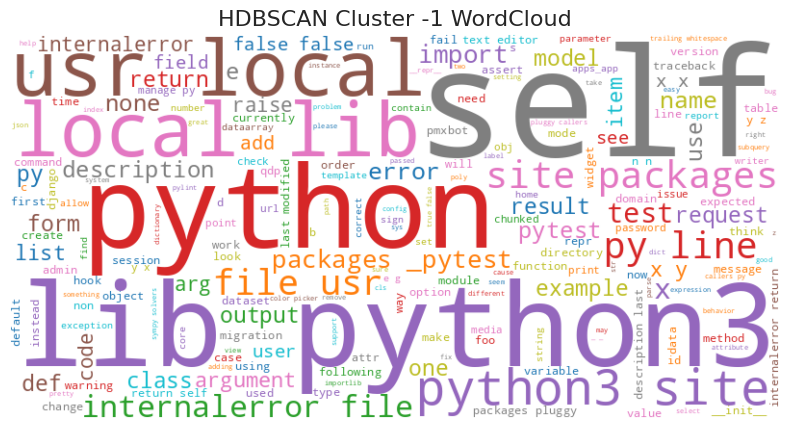

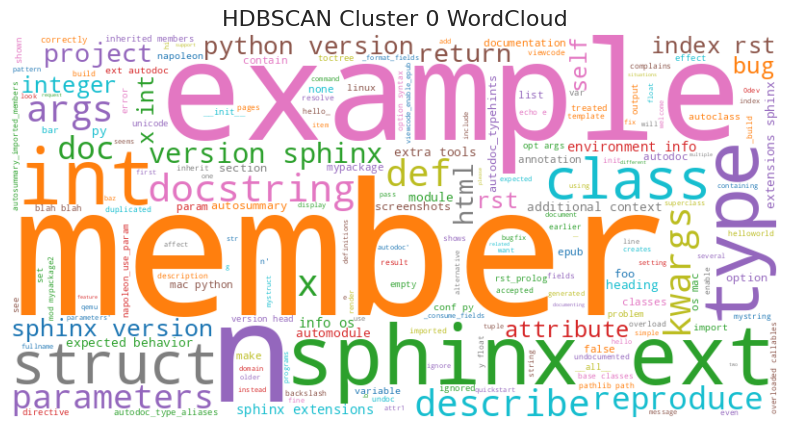

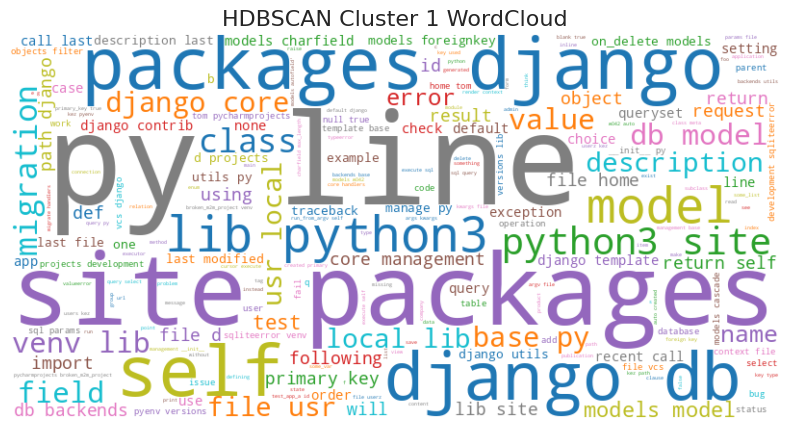

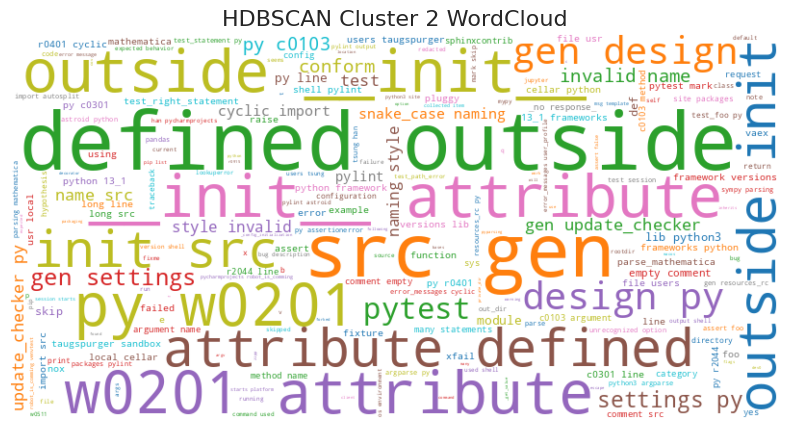

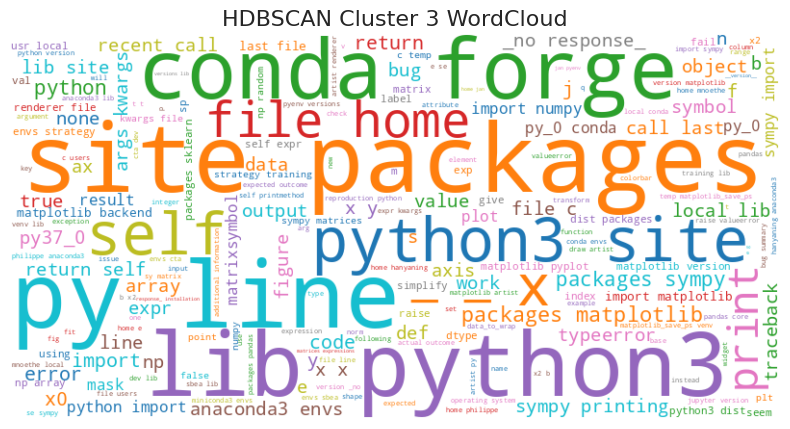

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get all unique clusters (including noise)
clusters = sorted(df['hdbscan_cluster'].unique())

for cluster_id in clusters:
    # Get text for this cluster
    cluster_text = " ".join(df[df['hdbscan_cluster'] == cluster_id]['text_clean'].tolist())

    if not cluster_text.strip():
        continue  # skip empty clusters

    # Generate word cloud
    wc = WordCloud(width=800, height=400, background_color='white', colormap='tab10').generate(cluster_text)

    # Plot
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"HDBSCAN Cluster {cluster_id} WordCloud", fontsize=16)
    plt.show()


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

clusters = sorted(df['hdbscan_cluster'].unique())
top_n = 10

cluster_top_words = {}

for cluster_id in clusters:
    # Get all texts for the cluster
    cluster_texts = df[df['hdbscan_cluster'] == cluster_id]['text_clean'].tolist()

    if not cluster_texts:
        continue

    # Use CountVectorizer to get word counts
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(cluster_texts)

    # Sum word counts across all documents
    word_counts = X.sum(axis=0)
    word_counts = pd.DataFrame(word_counts.T, index=vectorizer.get_feature_names_out(), columns=['count'])

    # Get top N words
    top_words = word_counts.sort_values('count', ascending=False).head(top_n)
    cluster_top_words[cluster_id] = top_words

# Display top 10 words per cluster
for cluster_id, words_df in cluster_top_words.items():
    print(f"\nCluster {cluster_id} top {top_n} words:")
    print(words_df)



Cluster -1 top 10 words:
               count
py               138
self             103
internalerror     91
file              75
python            75
local             69
line              66
python3           65
lib               64
usr               64

Cluster 0 top 10 words:
         count
sphinx      48
int         23
version     23
members     20
rst         18
example     17
args        16
ext         16
python      15
struct      14

Cluster 1 top 10 words:
          count
django      403
models      324
py          304
file        277
line        277
self        249
lib         168
packages    158
site        157
db          148

Cluster 2 top 10 words:
           count
py           271
attribute    243
outside      239
defined      238
src          207
gen          201
__init__     123
init         119
w0201        119
design        91

Cluster 3 top 10 words:
            count
self          274
py            274
sympy         225
file          218
lib           211
line   

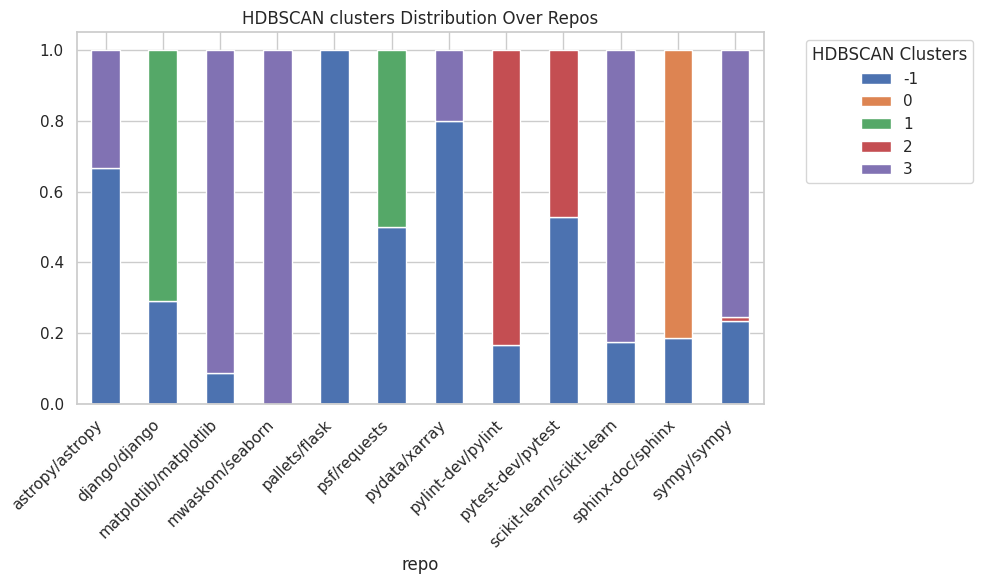

In [ ]:
dist_pct = (
    df.groupby(["repo", "hdbscan_cluster"]).size()
      .unstack(fill_value=0)
)

# normalize rows
dist_pct = dist_pct.div(dist_pct.sum(axis=1), axis=0)

# FIX MULTIINDEX PROBLEM
dist_pct = dist_pct.reset_index()
dist_pct = dist_pct.set_index("repo")

# plot and capture Axes
ax = dist_pct.plot(kind="bar", stacked=True, figsize=(10,6))

# set title on Axes
ax.set_title("HDBSCAN clusters Distribution Over Repos")

# rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.legend(title="HDBSCAN Clusters", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# save figure
plt.savefig(Save_path + "/HDBSCAN_dist_over_repos.pdf")
plt.savefig(Save_path + "/HDBSCAN_dist_over_repos.png")
plt.show()


In [ ]:
df.head()

repo             instance_id  \
0  astropy/astropy  astropy__astropy-12907   
1  astropy/astropy  astropy__astropy-14182   
2  astropy/astropy  astropy__astropy-14365   
3  astropy/astropy  astropy__astropy-14995   
4  astropy/astropy   astropy__astropy-6938   

                                base_commit  \
0  d16bfe05a744909de4b27f5875fe0d4ed41ce607   
1  a5917978be39d13cd90b517e1de4e7a539ffaa48   
2  7269fa3e33e8d02485a647da91a5a2a60a06af61   
3  b16c7d12ccbc7b2d20364b89fb44285bcbfede54   
4  c76af9ed6bb89bfba45b9f5bc1e635188278e2fa   

                                               patch  \
0  diff --git a/astropy/modeling/separable.py b/a...   
1  diff --git a/astropy/io/ascii/rst.py b/astropy...   
2  diff --git a/astropy/io/ascii/qdp.py b/astropy...   
3  diff --git a/astropy/nddata/mixins/ndarithmeti...   
4  diff --git a/astropy/io/fits/fitsrec.py b/astr...   

                                          test_patch  \
0  diff --git a/astropy/modeling/tests/test_separ...   
1  diff --git a/astropy/io/ascii/tests/test_rst.p...   
2  diff --git a/astropy/io/ascii/tests/test_qdp.p...   
3  diff --git a/astropy/nddata/mixins/tests/test_...   
4  diff --git a/astropy/io/fits/tests/test_checks...   

                                   problem_statement  \
0  Modeling's `separability_matrix` does not comp...   
1  Please support header rows in RestructuredText...   
2  ascii.qdp Table format assumes QDP commands ar...   
3  In v5.3, NDDataRef mask propagation fails when...   
4  Possible bug in io.fits related to D exponents...   

                                          hints_text            created_at  \
0                                                NaN  2022-03-03T15:14:54Z   
1                                                NaN  2022-12-16T11:13:37Z   
2  Welcome to Astropy 👋 and thank you for your fi...  2023-02-06T19:20:34Z   
3  Welcome to Astropy 👋 and thank you for your fi...  2023-06-27T19:48:18Z   
4  It is tested with `astropy/io/fits/tests/test_...  2017-12-07T00:01:14Z   

   version                                       FAIL_TO_PASS  ...  \
0      4.3  ["astropy/modeling/tests/test_separable.py::te...  ...   
1      5.1  ["astropy/io/ascii/tests/test_rst.py::test_rst...  ...   
2      5.1  ["astropy/io/ascii/tests/test_qdp.py::test_rou...  ...   
3      5.2  ["astropy/nddata/mixins/tests/test_ndarithmeti...  ...   
4      1.3  ["astropy/io/fits/tests/test_checksum.py::Test...  ...   

  predicted_labels predicted_scores  \
0              bug         0.792346   
1      enhancement         0.999485   
2              bug         0.998833   
3              bug         0.999328   
4              bug         0.999293   

                                    all_label_scores  bert_topic lda_topic  \
0  [{'label': 'bug', 'score': 0.7923456430435181}...           4        11   
1  [{'label': 'bug', 'score': 0.00020413256424944...           4         5   
2  [{'label': 'bug', 'score': 0.9988325238227844}...           0         5   
3  [{'label': 'bug', 'score': 0.9993282556533813}...           4         5   
4  [{'label': 'bug', 'score': 0.999293327331543},...           1         9   

                                          text_clean  kmeans_cluster  \
0  modeling's `separability_matrix` does not comp...               2   
1  please support header rows in restructuredtext...               5   
2  ascii.qdp table format assumes qdp commands ar...               7   
3  in v5.3, nddataref mask propagation fails when...               2   
4  possible bug in io.fits related to d exponents...               2   

  hdbscan_cluster    umap_x    umap_y  
0              -1  1.607771  7.859745  
1              -1  7.047937  5.124933  
2              -1  6.869792  5.177204  
3               3  1.402160  7.111073  
4              -1  6.865752  5.493959  

[5 rows x 22 columns]

In [ ]:
df.to_csv(Save_path + "/df_with_all_clusters.csv", index=False)

# Metadata

PCA/topic modeling captured textual similarity across issue descriptions.
But SWE-bench issues are not just text — they are structured engineering tasks with:

code locations

context retrieval

tests that fail/pass

patch complexity

environment metadata

gold reasoning traces

These elements reveal what kind of reasoning an LLM needs to solve each issue.

## Patch Analysis

In [ ]:
import re

def get_patch_stats(patch_text):
    if not isinstance(patch_text, str):
        return {
            "n_files_touched": 0,
            "added_lines": 0,
            "removed_lines": 0,
            "patch_total": 0
        }

    # --- Files touched ---
    files = re.findall(r"diff --git a/(.*?) b/", patch_text)
    n_files = len(set(files))

    # --- Line-level changes ---
    added = sum(1 for l in patch_text.split("\n")
                if l.startswith("+") and not l.startswith("+++"))
    removed = sum(1 for l in patch_text.split("\n")
                  if l.startswith("-") and not l.startswith("---"))

    return {
        "n_files_touched": n_files,
        "added_lines": added,
        "removed_lines": removed,
        "patch_total": added + removed
    }


In [ ]:
patch_features = df["patch"].apply(get_patch_stats).apply(pd.Series)
df = pd.concat([df, patch_features], axis=1)

# df[["n_files_touched", "added_lines", "removed_lines", "patch_total"]].head()
print(len(df))
df.head()


300


repo             instance_id  \
0  astropy/astropy  astropy__astropy-12907   
1  astropy/astropy  astropy__astropy-14182   
2  astropy/astropy  astropy__astropy-14365   
3  astropy/astropy  astropy__astropy-14995   
4  astropy/astropy   astropy__astropy-6938   

                                base_commit  \
0  d16bfe05a744909de4b27f5875fe0d4ed41ce607   
1  a5917978be39d13cd90b517e1de4e7a539ffaa48   
2  7269fa3e33e8d02485a647da91a5a2a60a06af61   
3  b16c7d12ccbc7b2d20364b89fb44285bcbfede54   
4  c76af9ed6bb89bfba45b9f5bc1e635188278e2fa   

                                               patch  \
0  diff --git a/astropy/modeling/separable.py b/a...   
1  diff --git a/astropy/io/ascii/rst.py b/astropy...   
2  diff --git a/astropy/io/ascii/qdp.py b/astropy...   
3  diff --git a/astropy/nddata/mixins/ndarithmeti...   
4  diff --git a/astropy/io/fits/fitsrec.py b/astr...   

                                          test_patch  \
0  diff --git a/astropy/modeling/tests/test_separ...   
1  diff --git a/astropy/io/ascii/tests/test_rst.p...   
2  diff --git a/astropy/io/ascii/tests/test_qdp.p...   
3  diff --git a/astropy/nddata/mixins/tests/test_...   
4  diff --git a/astropy/io/fits/tests/test_checks...   

                                   problem_statement  \
0  Modeling's `separability_matrix` does not comp...   
1  Please support header rows in RestructuredText...   
2  ascii.qdp Table format assumes QDP commands ar...   
3  In v5.3, NDDataRef mask propagation fails when...   
4  Possible bug in io.fits related to D exponents...   

                                          hints_text            created_at  \
0                                                NaN  2022-03-03T15:14:54Z   
1                                                NaN  2022-12-16T11:13:37Z   
2  Welcome to Astropy 👋 and thank you for your fi...  2023-02-06T19:20:34Z   
3  Welcome to Astropy 👋 and thank you for your fi...  2023-06-27T19:48:18Z   
4  It is tested with `astropy/io/fits/tests/test_...  2017-12-07T00:01:14Z   

   version                                       FAIL_TO_PASS  ... lda_topic  \
0      4.3  ["astropy/modeling/tests/test_separable.py::te...  ...        11   
1      5.1  ["astropy/io/ascii/tests/test_rst.py::test_rst...  ...         5   
2      5.1  ["astropy/io/ascii/tests/test_qdp.py::test_rou...  ...         5   
3      5.2  ["astropy/nddata/mixins/tests/test_ndarithmeti...  ...         5   
4      1.3  ["astropy/io/fits/tests/test_checksum.py::Test...  ...         9   

                                          text_clean kmeans_cluster  \
0  modeling's `separability_matrix` does not comp...              2   
1  please support header rows in restructuredtext...              5   
2  ascii.qdp table format assumes qdp commands ar...              7   
3  in v5.3, nddataref mask propagation fails when...              2   
4  possible bug in io.fits related to d exponents...              2   

   hdbscan_cluster    umap_x    umap_y  n_files_touched added_lines  \
0               -1  1.607771  7.859745                1           1   
1               -1  7.047937  5.124933                1          31   
2               -1  6.869792  5.177204                1           2   
3                3  1.402160  7.111073                1           2   
4               -1  6.865752  5.493959                1           1   

   removed_lines  patch_total  
0              1            2  
1             10           41  
2              2            4  
3              2            4  
4              1            2  

[5 rows x 26 columns]

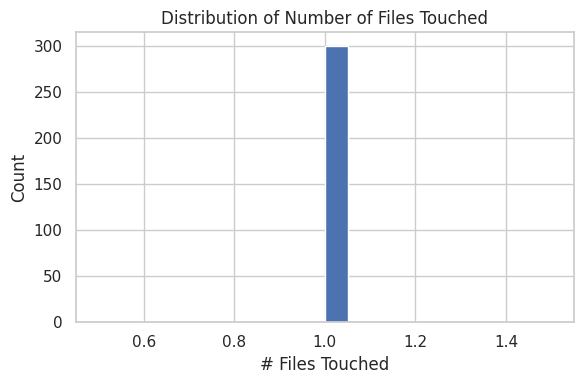

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(df["n_files_touched"], bins=20)
plt.xlabel("# Files Touched")
plt.ylabel("Count")
plt.title("Distribution of Number of Files Touched")
plt.tight_layout()
plt.show()


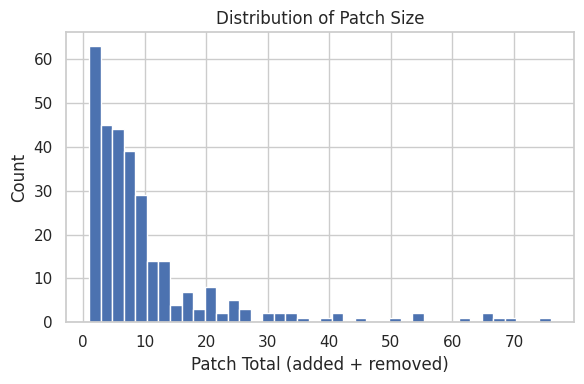

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(df["patch_total"], bins=40)
plt.xlabel("Patch Total (added + removed)")
plt.ylabel("Count")
plt.title("Distribution of Patch Size")
plt.tight_layout()
plt.show()


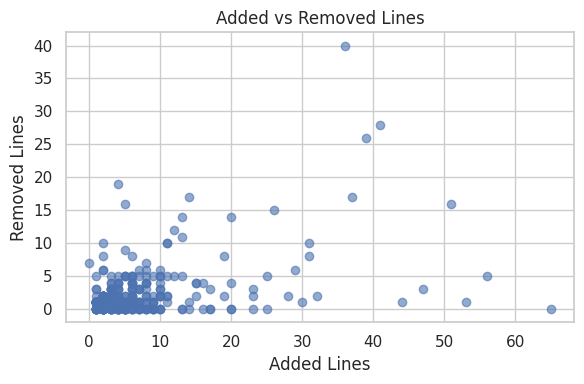

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(df["added_lines"], df["removed_lines"], alpha=0.6)
plt.xlabel("Added Lines")
plt.ylabel("Removed Lines")
plt.title("Added vs Removed Lines")
plt.tight_layout()
plt.show()


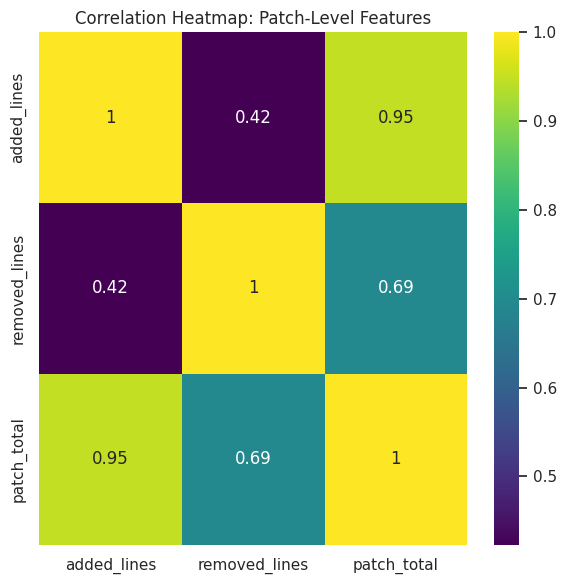

In [ ]:
import seaborn as sns

corr = df[[ "added_lines", "removed_lines", "patch_total"]].corr()

plt.figure(figsize=(6,6))
sns.heatmap(corr, annot=True, cmap="viridis")
plt.title("Correlation Heatmap: Patch-Level Features")
plt.tight_layout()
plt.show()


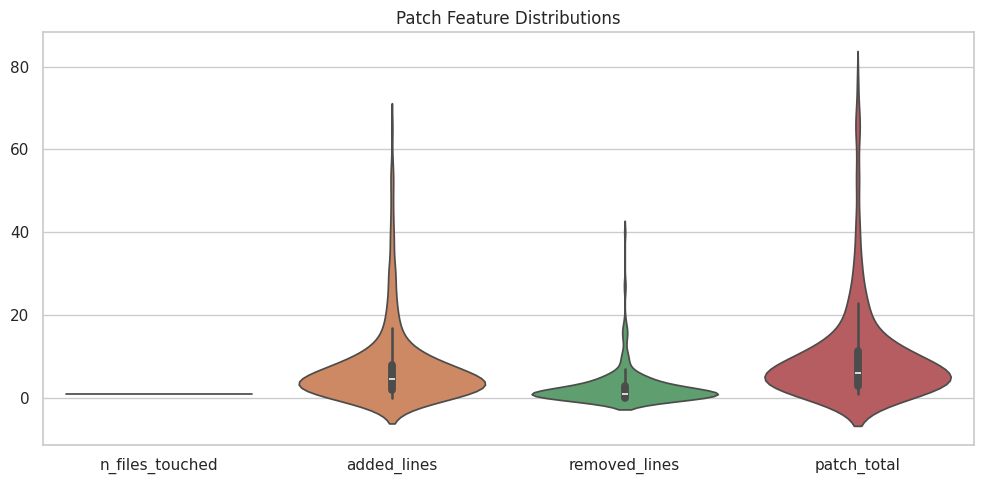

In [ ]:
plt.figure(figsize=(10,5))
sns.violinplot(
    data=df[["n_files_touched", "added_lines", "removed_lines", "patch_total"]],
)
plt.title("Patch Feature Distributions")
plt.tight_layout()
plt.show()


In [ ]:
set(list(df["n_files_touched"]))

{1}

in SWE bench lite the ground truth patches generally change only one file

In [ ]:
df.to_csv(Save_path + "/2_df_with_all_clusters_and_patch_features.csv", index=False)

We observe that the large majority of SWE-bench Lite issues require modifications to a single file. Patch sizes are also generally small, with most changes under 10 lines. However, the distribution is long-tailed, with some patches reaching 50–200 lines , representing substantially more complex issues. Added and removed lines show strong correlation with total patch size.

In [ ]:
import pandas as pd
df = pd.read_csv(Save_path + "/RQ1/2_df_with_all_clusters_and_patch_features.csv")
df.head()

repo             instance_id  \
0  astropy/astropy  astropy__astropy-12907   
1  astropy/astropy  astropy__astropy-14182   
2  astropy/astropy  astropy__astropy-14365   
3  astropy/astropy  astropy__astropy-14995   
4  astropy/astropy   astropy__astropy-6938   

                                base_commit  \
0  d16bfe05a744909de4b27f5875fe0d4ed41ce607   
1  a5917978be39d13cd90b517e1de4e7a539ffaa48   
2  7269fa3e33e8d02485a647da91a5a2a60a06af61   
3  b16c7d12ccbc7b2d20364b89fb44285bcbfede54   
4  c76af9ed6bb89bfba45b9f5bc1e635188278e2fa   

                                               patch  \
0  diff --git a/astropy/modeling/separable.py b/a...   
1  diff --git a/astropy/io/ascii/rst.py b/astropy...   
2  diff --git a/astropy/io/ascii/qdp.py b/astropy...   
3  diff --git a/astropy/nddata/mixins/ndarithmeti...   
4  diff --git a/astropy/io/fits/fitsrec.py b/astr...   

                                          test_patch  \
0  diff --git a/astropy/modeling/tests/test_separ...   
1  diff --git a/astropy/io/ascii/tests/test_rst.p...   
2  diff --git a/astropy/io/ascii/tests/test_qdp.p...   
3  diff --git a/astropy/nddata/mixins/tests/test_...   
4  diff --git a/astropy/io/fits/tests/test_checks...   

                                   problem_statement  \
0  Modeling's `separability_matrix` does not comp...   
1  Please support header rows in RestructuredText...   
2  ascii.qdp Table format assumes QDP commands ar...   
3  In v5.3, NDDataRef mask propagation fails when...   
4  Possible bug in io.fits related to D exponents...   

                                          hints_text            created_at  \
0                                                NaN  2022-03-03T15:14:54Z   
1                                                NaN  2022-12-16T11:13:37Z   
2  Welcome to Astropy 👋 and thank you for your fi...  2023-02-06T19:20:34Z   
3  Welcome to Astropy 👋 and thank you for your fi...  2023-06-27T19:48:18Z   
4  It is tested with `astropy/io/fits/tests/test_...  2017-12-07T00:01:14Z   

   version                                       FAIL_TO_PASS  ... lda_topic  \
0      4.3  ["astropy/modeling/tests/test_separable.py::te...  ...        11   
1      5.1  ["astropy/io/ascii/tests/test_rst.py::test_rst...  ...         5   
2      5.1  ["astropy/io/ascii/tests/test_qdp.py::test_rou...  ...         5   
3      5.2  ["astropy/nddata/mixins/tests/test_ndarithmeti...  ...         5   
4      1.3  ["astropy/io/fits/tests/test_checksum.py::Test...  ...         9   

                                          text_clean kmeans_cluster  \
0  modeling's `separability_matrix` does not comp...              2   
1  please support header rows in restructuredtext...              5   
2  ascii.qdp table format assumes qdp commands ar...              7   
3  in v5.3, nddataref mask propagation fails when...              2   
4  possible bug in io.fits related to d exponents...              2   

   hdbscan_cluster    umap_x    umap_y  n_files_touched added_lines  \
0               -1  1.607771  7.859745                1           1   
1               -1  7.047937  5.124933                1          31   
2               -1  6.869791  5.177204                1           2   
3                3  1.402160  7.111073                1           2   
4               -1  6.865752  5.493959                1           1   

   removed_lines  patch_total  
0              1            2  
1             10           41  
2              2            4  
3              2            4  
4              1            2  

[5 rows x 26 columns]

In [ ]:
avg=df["patch_total"].mean()
print("Average patch size:", avg)

Average patch size: 10.13


## test metadata

In [ ]:
df = pd.read_csv(Save_path + "/RQ1/2_df_with_all_clusters_and_patch_features.csv")
df.head()

repo             instance_id  \
0  astropy/astropy  astropy__astropy-12907   
1  astropy/astropy  astropy__astropy-14182   
2  astropy/astropy  astropy__astropy-14365   
3  astropy/astropy  astropy__astropy-14995   
4  astropy/astropy   astropy__astropy-6938   

                                base_commit  \
0  d16bfe05a744909de4b27f5875fe0d4ed41ce607   
1  a5917978be39d13cd90b517e1de4e7a539ffaa48   
2  7269fa3e33e8d02485a647da91a5a2a60a06af61   
3  b16c7d12ccbc7b2d20364b89fb44285bcbfede54   
4  c76af9ed6bb89bfba45b9f5bc1e635188278e2fa   

                                               patch  \
0  diff --git a/astropy/modeling/separable.py b/a...   
1  diff --git a/astropy/io/ascii/rst.py b/astropy...   
2  diff --git a/astropy/io/ascii/qdp.py b/astropy...   
3  diff --git a/astropy/nddata/mixins/ndarithmeti...   
4  diff --git a/astropy/io/fits/fitsrec.py b/astr...   

                                          test_patch  \
0  diff --git a/astropy/modeling/tests/test_separ...   
1  diff --git a/astropy/io/ascii/tests/test_rst.p...   
2  diff --git a/astropy/io/ascii/tests/test_qdp.p...   
3  diff --git a/astropy/nddata/mixins/tests/test_...   
4  diff --git a/astropy/io/fits/tests/test_checks...   

                                   problem_statement  \
0  Modeling's `separability_matrix` does not comp...   
1  Please support header rows in RestructuredText...   
2  ascii.qdp Table format assumes QDP commands ar...   
3  In v5.3, NDDataRef mask propagation fails when...   
4  Possible bug in io.fits related to D exponents...   

                                          hints_text            created_at  \
0                                                NaN  2022-03-03T15:14:54Z   
1                                                NaN  2022-12-16T11:13:37Z   
2  Welcome to Astropy 👋 and thank you for your fi...  2023-02-06T19:20:34Z   
3  Welcome to Astropy 👋 and thank you for your fi...  2023-06-27T19:48:18Z   
4  It is tested with `astropy/io/fits/tests/test_...  2017-12-07T00:01:14Z   

   version                                       FAIL_TO_PASS  ... lda_topic  \
0      4.3  ["astropy/modeling/tests/test_separable.py::te...  ...        11   
1      5.1  ["astropy/io/ascii/tests/test_rst.py::test_rst...  ...         5   
2      5.1  ["astropy/io/ascii/tests/test_qdp.py::test_rou...  ...         5   
3      5.2  ["astropy/nddata/mixins/tests/test_ndarithmeti...  ...         5   
4      1.3  ["astropy/io/fits/tests/test_checksum.py::Test...  ...         9   

                                          text_clean kmeans_cluster  \
0  modeling's `separability_matrix` does not comp...              2   
1  please support header rows in restructuredtext...              5   
2  ascii.qdp table format assumes qdp commands ar...              7   
3  in v5.3, nddataref mask propagation fails when...              2   
4  possible bug in io.fits related to d exponents...              2   

   hdbscan_cluster    umap_x    umap_y  n_files_touched added_lines  \
0               -1  1.607771  7.859745                1           1   
1               -1  7.047937  5.124933                1          31   
2               -1  6.869791  5.177204                1           2   
3                3  1.402160  7.111073                1           2   
4               -1  6.865752  5.493959                1           1   

   removed_lines  patch_total  
0              1            2  
1             10           41  
2              2            4  
3              2            4  
4              1            2  

[5 rows x 26 columns]

FAIL_TO_PASS: This is a list of tests that were failing before the patch. These tests fail on the base commit (base_commit) but are expected to pass after the patch is applied. tells us issue difficulty and scope Many failing tests → larger or more complex bugs. A single failing test → small/isolated bug

PASS_TO_PASS: This is a list of tests that passed both before and after the patch. Essentially, these tests were already passing on the base commit, and they remain passing after the fix. tells us the surrounding context. Large number of passing tests → patch must avoid breaking existing functionality. Can be used to measure reasoning effort for an LLM (must consider many tests)

In [ ]:
import ast  # safe conversion from string/list in your dataframe

def count_tests(col_value):
    """Count number of tests in a column (FAIL_TO_PASS or PASS_TO_PASS)."""
    if col_value is None:
        return 0
    if isinstance(col_value, list):
        return len(col_value)
    # sometimes it may be stored as a string representation of a list
    try:
        lst = ast.literal_eval(col_value)
        if isinstance(lst, list):
            return len(lst)
        return 0
    except Exception:
        return 0

df["n_failures"] = df["FAIL_TO_PASS"].apply(count_tests)
df["n_passes_after"] = df["PASS_TO_PASS"].apply(count_tests)


In [ ]:
df.head()

repo             instance_id  \
0  astropy/astropy  astropy__astropy-12907   
1  astropy/astropy  astropy__astropy-14182   
2  astropy/astropy  astropy__astropy-14365   
3  astropy/astropy  astropy__astropy-14995   
4  astropy/astropy   astropy__astropy-6938   

                                base_commit  \
0  d16bfe05a744909de4b27f5875fe0d4ed41ce607   
1  a5917978be39d13cd90b517e1de4e7a539ffaa48   
2  7269fa3e33e8d02485a647da91a5a2a60a06af61   
3  b16c7d12ccbc7b2d20364b89fb44285bcbfede54   
4  c76af9ed6bb89bfba45b9f5bc1e635188278e2fa   

                                               patch  \
0  diff --git a/astropy/modeling/separable.py b/a...   
1  diff --git a/astropy/io/ascii/rst.py b/astropy...   
2  diff --git a/astropy/io/ascii/qdp.py b/astropy...   
3  diff --git a/astropy/nddata/mixins/ndarithmeti...   
4  diff --git a/astropy/io/fits/fitsrec.py b/astr...   

                                          test_patch  \
0  diff --git a/astropy/modeling/tests/test_separ...   
1  diff --git a/astropy/io/ascii/tests/test_rst.p...   
2  diff --git a/astropy/io/ascii/tests/test_qdp.p...   
3  diff --git a/astropy/nddata/mixins/tests/test_...   
4  diff --git a/astropy/io/fits/tests/test_checks...   

                                   problem_statement  \
0  Modeling's `separability_matrix` does not comp...   
1  Please support header rows in RestructuredText...   
2  ascii.qdp Table format assumes QDP commands ar...   
3  In v5.3, NDDataRef mask propagation fails when...   
4  Possible bug in io.fits related to D exponents...   

                                          hints_text            created_at  \
0                                                NaN  2022-03-03T15:14:54Z   
1                                                NaN  2022-12-16T11:13:37Z   
2  Welcome to Astropy 👋 and thank you for your fi...  2023-02-06T19:20:34Z   
3  Welcome to Astropy 👋 and thank you for your fi...  2023-06-27T19:48:18Z   
4  It is tested with `astropy/io/fits/tests/test_...  2017-12-07T00:01:14Z   

   version                                       FAIL_TO_PASS  ...  \
0      4.3  ["astropy/modeling/tests/test_separable.py::te...  ...   
1      5.1  ["astropy/io/ascii/tests/test_rst.py::test_rst...  ...   
2      5.1  ["astropy/io/ascii/tests/test_qdp.py::test_rou...  ...   
3      5.2  ["astropy/nddata/mixins/tests/test_ndarithmeti...  ...   
4      1.3  ["astropy/io/fits/tests/test_checksum.py::Test...  ...   

  kmeans_cluster hdbscan_cluster    umap_x    umap_y n_files_touched  \
0              2              -1  1.607771  7.859745               1   
1              5              -1  7.047937  5.124933               1   
2              7              -1  6.869791  5.177204               1   
3              2               3  1.402160  7.111073               1   
4              2              -1  6.865752  5.493959               1   

   added_lines  removed_lines patch_total  n_failures  n_passes_after  
0            1              1           2           2              13  
1           31             10          41           1               9  
2            2              2           4           1               8  
3            2              2           4           1             179  
4            1              1           2           2              11  

[5 rows x 28 columns]

In [ ]:
df[["n_failures","n_passes_after"]].describe()


n_failures  n_passes_after
count  300.000000      300.000000
mean     3.466667       81.713333
std     22.581600      149.319654
min      1.000000        0.000000
25%      1.000000       16.000000
50%      1.000000       44.000000
75%      2.000000       98.000000
max    355.000000     1689.000000

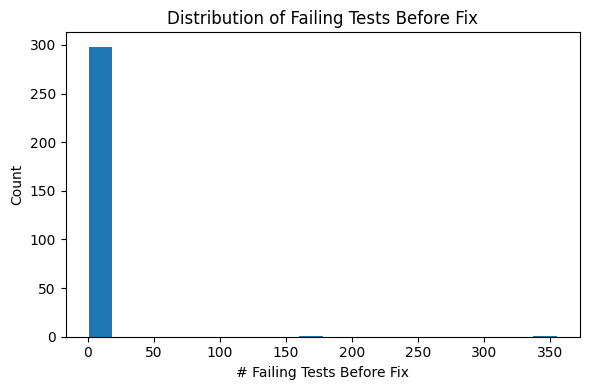

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(df["n_failures"], bins=20)
plt.xlabel("# Failing Tests Before Fix")
plt.ylabel("Count")
plt.title("Distribution of Failing Tests Before Fix")
plt.tight_layout()
plt.show()


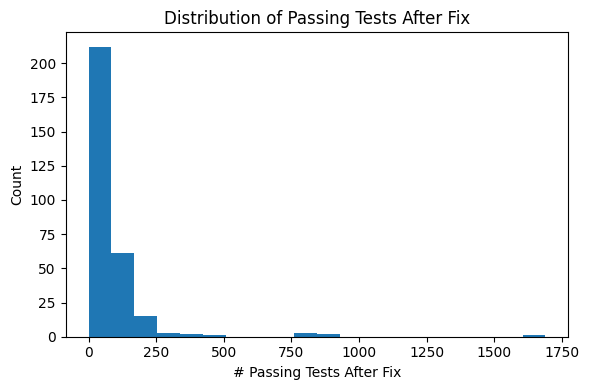

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(df["n_passes_after"], bins=20)
plt.xlabel("# Passing Tests After Fix")
plt.ylabel("Count")
plt.title("Distribution of Passing Tests After Fix")
plt.tight_layout()
plt.show()


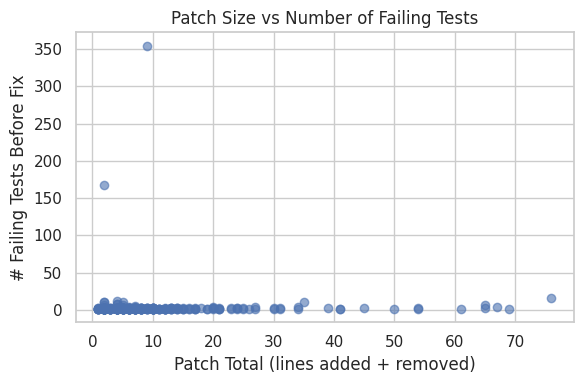

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(df["patch_total"], df["n_failures"], alpha=0.6)
plt.xlabel("Patch Total (lines added + removed)")
plt.ylabel("# Failing Tests Before Fix")
plt.title("Patch Size vs Number of Failing Tests")
plt.tight_layout()
plt.show()


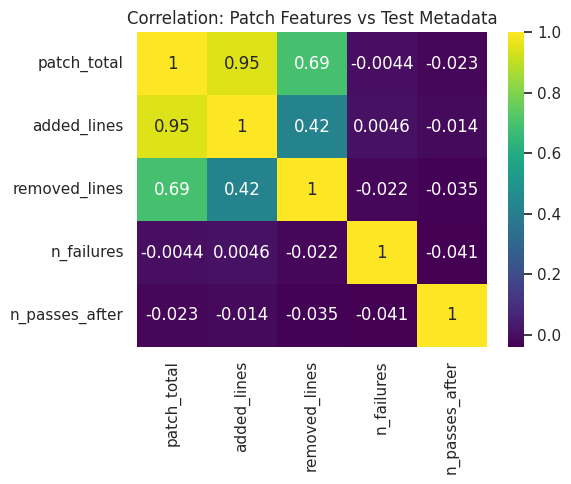

In [ ]:
corr = df[["patch_total","added_lines","removed_lines","n_failures","n_passes_after"]].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="viridis")
plt.title("Correlation: Patch Features vs Test Metadata")
plt.tight_layout()
plt.show()


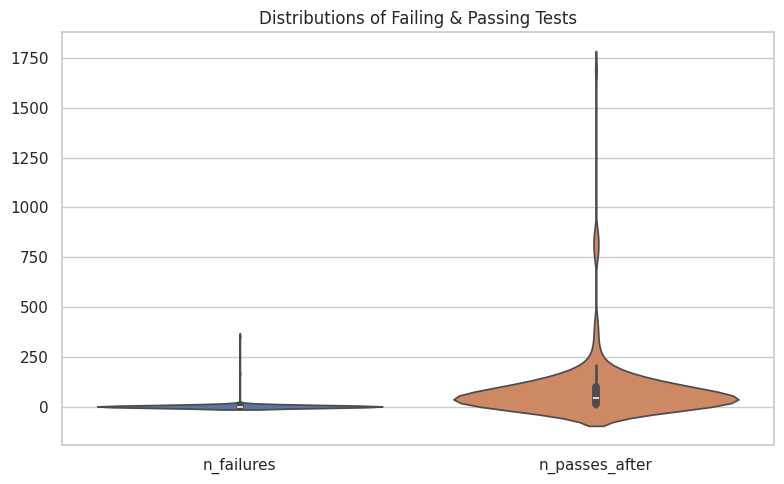

In [ ]:
plt.figure(figsize=(8,5))
sns.violinplot(data=df[["n_failures","n_passes_after"]])
plt.title("Distributions of Failing & Passing Tests")
plt.tight_layout()
plt.show()


Analysis of test metadata shows that most SWE-bench Lite issues fail only a few tests before the fix, often just 1–2, while passing tests after the fix are substantially more numerous.

In [ ]:
df.to_csv(Save_path + "/3_df_with_all_clusters_and_patch_features_and_test_metadata.csv", index=False)

In [ ]:
df.head()

repo             instance_id  \
0  astropy/astropy  astropy__astropy-12907   
1  astropy/astropy  astropy__astropy-14182   
2  astropy/astropy  astropy__astropy-14365   
3  astropy/astropy  astropy__astropy-14995   
4  astropy/astropy   astropy__astropy-6938   

                                base_commit  \
0  d16bfe05a744909de4b27f5875fe0d4ed41ce607   
1  a5917978be39d13cd90b517e1de4e7a539ffaa48   
2  7269fa3e33e8d02485a647da91a5a2a60a06af61   
3  b16c7d12ccbc7b2d20364b89fb44285bcbfede54   
4  c76af9ed6bb89bfba45b9f5bc1e635188278e2fa   

                                               patch  \
0  diff --git a/astropy/modeling/separable.py b/a...   
1  diff --git a/astropy/io/ascii/rst.py b/astropy...   
2  diff --git a/astropy/io/ascii/qdp.py b/astropy...   
3  diff --git a/astropy/nddata/mixins/ndarithmeti...   
4  diff --git a/astropy/io/fits/fitsrec.py b/astr...   

                                          test_patch  \
0  diff --git a/astropy/modeling/tests/test_separ...   
1  diff --git a/astropy/io/ascii/tests/test_rst.p...   
2  diff --git a/astropy/io/ascii/tests/test_qdp.p...   
3  diff --git a/astropy/nddata/mixins/tests/test_...   
4  diff --git a/astropy/io/fits/tests/test_checks...   

                                   problem_statement  \
0  Modeling's `separability_matrix` does not comp...   
1  Please support header rows in RestructuredText...   
2  ascii.qdp Table format assumes QDP commands ar...   
3  In v5.3, NDDataRef mask propagation fails when...   
4  Possible bug in io.fits related to D exponents...   

                                          hints_text            created_at  \
0                                                NaN  2022-03-03T15:14:54Z   
1                                                NaN  2022-12-16T11:13:37Z   
2  Welcome to Astropy 👋 and thank you for your fi...  2023-02-06T19:20:34Z   
3  Welcome to Astropy 👋 and thank you for your fi...  2023-06-27T19:48:18Z   
4  It is tested with `astropy/io/fits/tests/test_...  2017-12-07T00:01:14Z   

   version                                       FAIL_TO_PASS  ...  \
0      4.3  ["astropy/modeling/tests/test_separable.py::te...  ...   
1      5.1  ["astropy/io/ascii/tests/test_rst.py::test_rst...  ...   
2      5.1  ["astropy/io/ascii/tests/test_qdp.py::test_rou...  ...   
3      5.2  ["astropy/nddata/mixins/tests/test_ndarithmeti...  ...   
4      1.3  ["astropy/io/fits/tests/test_checksum.py::Test...  ...   

  kmeans_cluster hdbscan_cluster    umap_x    umap_y n_files_touched  \
0              2              -1  1.607771  7.859745               1   
1              5              -1  7.047937  5.124933               1   
2              7              -1  6.869792  5.177204               1   
3              2               3  1.402160  7.111073               1   
4              2              -1  6.865752  5.493959               1   

   added_lines  removed_lines patch_total  n_failures  n_passes_after  
0            1              1           2           2              13  
1           31             10          41           1               9  
2            2              2           4           1               8  
3            2              2           4           1             179  
4            1              1           2           2              11  

[5 rows x 28 columns]

## test patch vs patch

patch --> Purpose: Fix the source code to resolve a bug.

test_patch --> Purpose: Fix the test code itself, not the source code.

Some bugs only need code fixes → patch non-empty, test_patch empty.

Some issues are test-only bugs (wrong assertions, outdated tests) → patch empty, test_patch non-empty.

Some issues need both code + test fixes → both non-empty.

This allows us to analyze difficulty separately:

Patch-only: reasoning about code logic

Test-only: reasoning about test correctness

Patch + Test: combined reasoning (hardest)

In [ ]:
df = pd.read_csv(Save_path + "/RQ1/3_df_with_all_clusters_and_patch_features_and_test_metadata.csv")
df.head()

repo             instance_id  \
0  astropy/astropy  astropy__astropy-12907   
1  astropy/astropy  astropy__astropy-14182   
2  astropy/astropy  astropy__astropy-14365   
3  astropy/astropy  astropy__astropy-14995   
4  astropy/astropy   astropy__astropy-6938   

                                base_commit  \
0  d16bfe05a744909de4b27f5875fe0d4ed41ce607   
1  a5917978be39d13cd90b517e1de4e7a539ffaa48   
2  7269fa3e33e8d02485a647da91a5a2a60a06af61   
3  b16c7d12ccbc7b2d20364b89fb44285bcbfede54   
4  c76af9ed6bb89bfba45b9f5bc1e635188278e2fa   

                                               patch  \
0  diff --git a/astropy/modeling/separable.py b/a...   
1  diff --git a/astropy/io/ascii/rst.py b/astropy...   
2  diff --git a/astropy/io/ascii/qdp.py b/astropy...   
3  diff --git a/astropy/nddata/mixins/ndarithmeti...   
4  diff --git a/astropy/io/fits/fitsrec.py b/astr...   

                                          test_patch  \
0  diff --git a/astropy/modeling/tests/test_separ...   
1  diff --git a/astropy/io/ascii/tests/test_rst.p...   
2  diff --git a/astropy/io/ascii/tests/test_qdp.p...   
3  diff --git a/astropy/nddata/mixins/tests/test_...   
4  diff --git a/astropy/io/fits/tests/test_checks...   

                                   problem_statement  \
0  Modeling's `separability_matrix` does not comp...   
1  Please support header rows in RestructuredText...   
2  ascii.qdp Table format assumes QDP commands ar...   
3  In v5.3, NDDataRef mask propagation fails when...   
4  Possible bug in io.fits related to D exponents...   

                                          hints_text            created_at  \
0                                                NaN  2022-03-03T15:14:54Z   
1                                                NaN  2022-12-16T11:13:37Z   
2  Welcome to Astropy 👋 and thank you for your fi...  2023-02-06T19:20:34Z   
3  Welcome to Astropy 👋 and thank you for your fi...  2023-06-27T19:48:18Z   
4  It is tested with `astropy/io/fits/tests/test_...  2017-12-07T00:01:14Z   

   version                                       FAIL_TO_PASS  ...  \
0      4.3  ["astropy/modeling/tests/test_separable.py::te...  ...   
1      5.1  ["astropy/io/ascii/tests/test_rst.py::test_rst...  ...   
2      5.1  ["astropy/io/ascii/tests/test_qdp.py::test_rou...  ...   
3      5.2  ["astropy/nddata/mixins/tests/test_ndarithmeti...  ...   
4      1.3  ["astropy/io/fits/tests/test_checksum.py::Test...  ...   

  kmeans_cluster hdbscan_cluster    umap_x    umap_y n_files_touched  \
0              2              -1  1.607771  7.859745               1   
1              5              -1  7.047937  5.124933               1   
2              7              -1  6.869791  5.177204               1   
3              2               3  1.402160  7.111073               1   
4              2              -1  6.865752  5.493959               1   

   added_lines  removed_lines patch_total  n_failures  n_passes_after  
0            1              1           2           2              13  
1           31             10          41           1               9  
2            2              2           4           1               8  
3            2              2           4           1             179  
4            1              1           2           2              11  

[5 rows x 28 columns]

In [ ]:
import re
import pandas as pd

def get_patch_stats(patch_text):
    """Compute files touched, lines added/removed, total lines."""
    if not isinstance(patch_text, str) or patch_text.strip() == "":
        return {
            "test_n_files_touched": 0,
            "test_added_lines": 0,
            "test_removed_lines": 0,
            "test_patch_total": 0
        }

    # Files touched
    files = re.findall(r"diff --git a/(.*?) b/", patch_text)
    n_files = len(set(files))

    # Lines added/removed
    added = sum(1 for l in patch_text.split("\n")
                if l.startswith("+") and not l.startswith("+++"))
    removed = sum(1 for l in patch_text.split("\n")
                  if l.startswith("-") and not l.startswith("---"))

    return {
        "test_n_files_touched": n_files,
        "test_added_lines": added,
        "test_removed_lines": removed,
        "test_patch_total": added + removed
    }

# Apply to test_patch
test_patch_features = df["test_patch"].apply(get_patch_stats).apply(pd.Series)

# Rename columns to distinguish from main patch
# test_patch_features = test_patch_features.rename(columns={
#     "n_files_touched": "test_n_files_touched",
#     "added_lines": "test_added_lines",
#     "removed_lines": "test_removed_lines",
#     "patch_total": "test_patch_total"
# })

# Merge into main dataframe
df = pd.concat([df, test_patch_features], axis=1)

# Quick check
df.head()


repo             instance_id  \
0  astropy/astropy  astropy__astropy-12907   
1  astropy/astropy  astropy__astropy-14182   
2  astropy/astropy  astropy__astropy-14365   
3  astropy/astropy  astropy__astropy-14995   
4  astropy/astropy   astropy__astropy-6938   

                                base_commit  \
0  d16bfe05a744909de4b27f5875fe0d4ed41ce607   
1  a5917978be39d13cd90b517e1de4e7a539ffaa48   
2  7269fa3e33e8d02485a647da91a5a2a60a06af61   
3  b16c7d12ccbc7b2d20364b89fb44285bcbfede54   
4  c76af9ed6bb89bfba45b9f5bc1e635188278e2fa   

                                               patch  \
0  diff --git a/astropy/modeling/separable.py b/a...   
1  diff --git a/astropy/io/ascii/rst.py b/astropy...   
2  diff --git a/astropy/io/ascii/qdp.py b/astropy...   
3  diff --git a/astropy/nddata/mixins/ndarithmeti...   
4  diff --git a/astropy/io/fits/fitsrec.py b/astr...   

                                          test_patch  \
0  diff --git a/astropy/modeling/tests/test_separ...   
1  diff --git a/astropy/io/ascii/tests/test_rst.p...   
2  diff --git a/astropy/io/ascii/tests/test_qdp.p...   
3  diff --git a/astropy/nddata/mixins/tests/test_...   
4  diff --git a/astropy/io/fits/tests/test_checks...   

                                   problem_statement  \
0  Modeling's `separability_matrix` does not comp...   
1  Please support header rows in RestructuredText...   
2  ascii.qdp Table format assumes QDP commands ar...   
3  In v5.3, NDDataRef mask propagation fails when...   
4  Possible bug in io.fits related to D exponents...   

                                          hints_text            created_at  \
0                                                NaN  2022-03-03T15:14:54Z   
1                                                NaN  2022-12-16T11:13:37Z   
2  Welcome to Astropy 👋 and thank you for your fi...  2023-02-06T19:20:34Z   
3  Welcome to Astropy 👋 and thank you for your fi...  2023-06-27T19:48:18Z   
4  It is tested with `astropy/io/fits/tests/test_...  2017-12-07T00:01:14Z   

   version                                       FAIL_TO_PASS  ...  \
0      4.3  ["astropy/modeling/tests/test_separable.py::te...  ...   
1      5.1  ["astropy/io/ascii/tests/test_rst.py::test_rst...  ...   
2      5.1  ["astropy/io/ascii/tests/test_qdp.py::test_rou...  ...   
3      5.2  ["astropy/nddata/mixins/tests/test_ndarithmeti...  ...   
4      1.3  ["astropy/io/fits/tests/test_checksum.py::Test...  ...   

  n_files_touched added_lines removed_lines  patch_total n_failures  \
0               1           1             1            2          2   
1               1          31            10           41          1   
2               1           2             2            4          1   
3               1           2             2            4          1   
4               1           1             1            2          2   

   n_passes_after  test_n_files_touched test_added_lines  test_removed_lines  \
0              13                     1               18                   1   
1               9                     1               28                   0   
2               8                     1               14                   1   
3             179                     1               39                   0   
4              11                     2               15                   2   

   test_patch_total  
0                19  
1                28  
2                15  
3                39  
4                17  

[5 rows x 32 columns]

In [ ]:
df[["test_n_files_touched","test_added_lines","test_removed_lines","test_patch_total"]].describe()


test_n_files_touched  test_added_lines  test_removed_lines  \
count            300.000000        300.000000          300.000000   
mean               1.260000         21.140000            2.296667   
std                0.673731         28.365632            7.964931   
min                1.000000          1.000000            0.000000   
25%                1.000000          7.000000            0.000000   
50%                1.000000         13.000000            0.000000   
75%                1.000000         24.000000            1.000000   
max                8.000000        269.000000           79.000000   

       test_patch_total  
count        300.000000  
mean          23.436667  
std           31.722659  
min            1.000000  
25%            7.000000  
50%           14.500000  
75%           27.000000  
max          321.000000

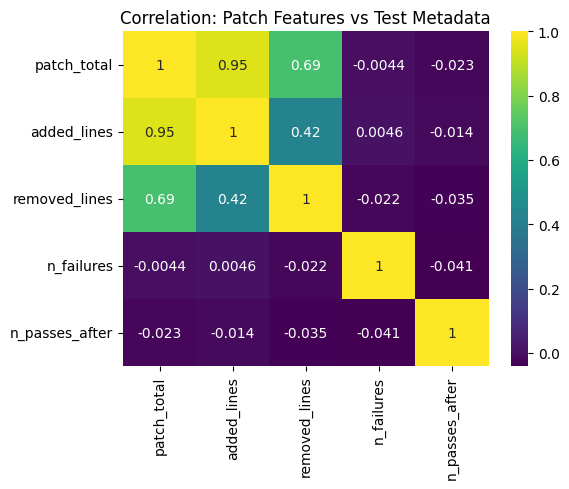

In [ ]:
corr = df[["patch_total","added_lines","removed_lines","n_failures","n_passes_after"]].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="viridis")
plt.title("Correlation: Patch Features vs Test Metadata")
plt.tight_layout()
plt.show()


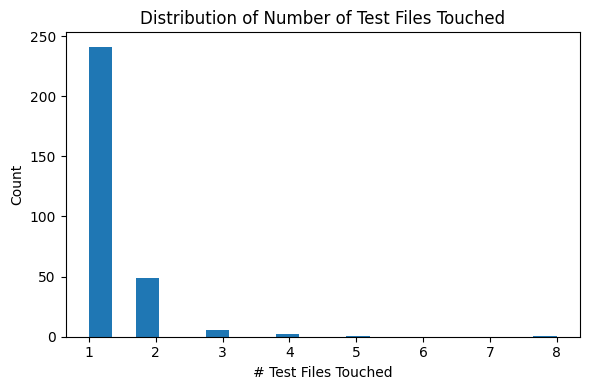

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(df["test_n_files_touched"], bins=20)
plt.xlabel("# Test Files Touched")
plt.ylabel("Count")
plt.title("Distribution of Number of Test Files Touched")
plt.tight_layout()
plt.show()


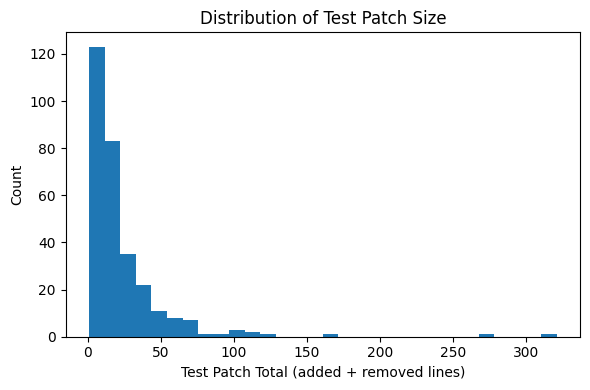

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(df["test_patch_total"], bins=30)
plt.xlabel("Test Patch Total (added + removed lines)")
plt.ylabel("Count")
plt.title("Distribution of Test Patch Size")
plt.tight_layout()
plt.show()


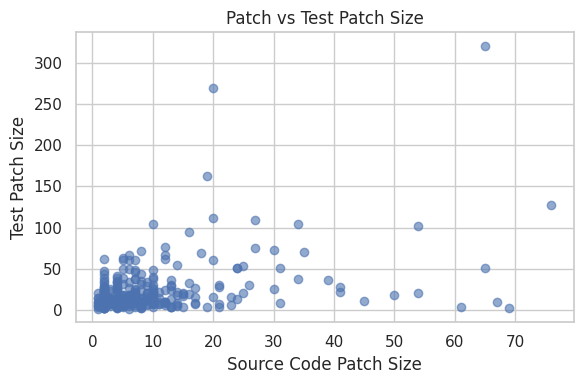

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(df["patch_total"], df["test_patch_total"], alpha=0.6)
plt.xlabel("Source Code Patch Size")
plt.ylabel("Test Patch Size")
plt.title("Patch vs Test Patch Size")
plt.tight_layout()
plt.show()


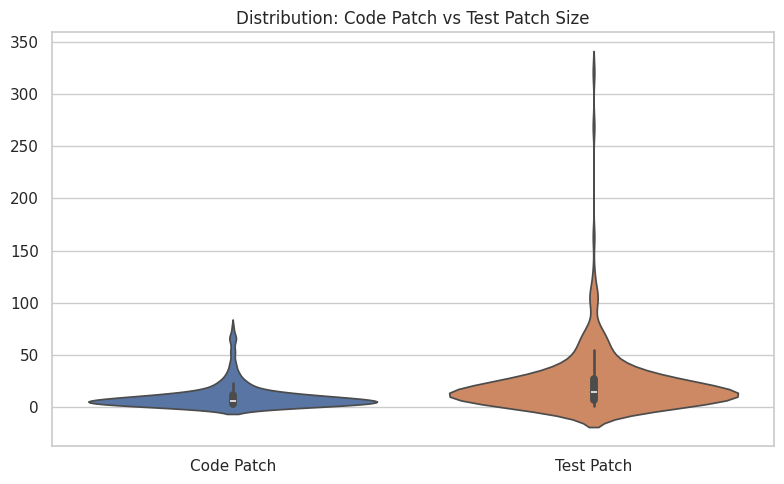

In [ ]:
plt.figure(figsize=(8,5))
sns.violinplot(data=df[["patch_total","test_patch_total"]])
plt.title("Distribution: Code Patch vs Test Patch Size")
plt.xticks([0,1], ["Code Patch","Test Patch"])
plt.tight_layout()
plt.show()


In [ ]:
df["has_test_patch"] = df["test_patch_total"] > 0
df["has_patch"] = df["patch_total"] > 0

# Count of patch types
df.groupby(["has_patch","has_test_patch"]).size()


has_patch  has_test_patch
True       True              300
dtype: int64

Out of the analyzed SWE-bench Lite issues, 300 issues require both source code and test modifications, indicating that a significant portion of bugs involve changes not only to the implementation but also to the corresponding test cases. This highlights the complexity of these issues, as fixes must simultaneously correct the code logic and ensure that all relevant tests pass. The presence of both code and test changes can be seen as a proxy for higher reasoning difficulty, since developers or automated systems must consider interactions between code and test behavior to produce a correct patch.

In [ ]:
df.to_csv(Save_path + "/4_df_with_all_clusters_and_patch_features_and_test_metadata_and_test_patch.csv", index=False)

In [ ]:
import pandas as pd
df = pd.read_csv(Save_path + "/RQ1/4_df_with_all_clusters_and_patch_features_and_test_metadata_and_test_patch.csv")
df.head()

repo             instance_id  \
0  astropy/astropy  astropy__astropy-12907   
1  astropy/astropy  astropy__astropy-14182   
2  astropy/astropy  astropy__astropy-14365   
3  astropy/astropy  astropy__astropy-14995   
4  astropy/astropy   astropy__astropy-6938   

                                base_commit  \
0  d16bfe05a744909de4b27f5875fe0d4ed41ce607   
1  a5917978be39d13cd90b517e1de4e7a539ffaa48   
2  7269fa3e33e8d02485a647da91a5a2a60a06af61   
3  b16c7d12ccbc7b2d20364b89fb44285bcbfede54   
4  c76af9ed6bb89bfba45b9f5bc1e635188278e2fa   

                                               patch  \
0  diff --git a/astropy/modeling/separable.py b/a...   
1  diff --git a/astropy/io/ascii/rst.py b/astropy...   
2  diff --git a/astropy/io/ascii/qdp.py b/astropy...   
3  diff --git a/astropy/nddata/mixins/ndarithmeti...   
4  diff --git a/astropy/io/fits/fitsrec.py b/astr...   

                                          test_patch  \
0  diff --git a/astropy/modeling/tests/test_separ...   
1  diff --git a/astropy/io/ascii/tests/test_rst.p...   
2  diff --git a/astropy/io/ascii/tests/test_qdp.p...   
3  diff --git a/astropy/nddata/mixins/tests/test_...   
4  diff --git a/astropy/io/fits/tests/test_checks...   

                                   problem_statement  \
0  Modeling's `separability_matrix` does not comp...   
1  Please support header rows in RestructuredText...   
2  ascii.qdp Table format assumes QDP commands ar...   
3  In v5.3, NDDataRef mask propagation fails when...   
4  Possible bug in io.fits related to D exponents...   

                                          hints_text            created_at  \
0                                                NaN  2022-03-03T15:14:54Z   
1                                                NaN  2022-12-16T11:13:37Z   
2  Welcome to Astropy 👋 and thank you for your fi...  2023-02-06T19:20:34Z   
3  Welcome to Astropy 👋 and thank you for your fi...  2023-06-27T19:48:18Z   
4  It is tested with `astropy/io/fits/tests/test_...  2017-12-07T00:01:14Z   

   version                                       FAIL_TO_PASS  ...  \
0      4.3  ["astropy/modeling/tests/test_separable.py::te...  ...   
1      5.1  ["astropy/io/ascii/tests/test_rst.py::test_rst...  ...   
2      5.1  ["astropy/io/ascii/tests/test_qdp.py::test_rou...  ...   
3      5.2  ["astropy/nddata/mixins/tests/test_ndarithmeti...  ...   
4      1.3  ["astropy/io/fits/tests/test_checksum.py::Test...  ...   

  removed_lines patch_total n_failures  n_passes_after test_n_files_touched  \
0             1           2          2              13                    1   
1            10          41          1               9                    1   
2             2           4          1               8                    1   
3             2           4          1             179                    1   
4             1           2          2              11                    2   

   test_added_lines  test_removed_lines test_patch_total  has_test_patch  \
0                18                   1               19            True   
1                28                   0               28            True   
2                14                   1               15            True   
3                39                   0               39            True   
4                15                   2               17            True   

   has_patch  
0       True  
1       True  
2       True  
3       True  
4       True  

[5 rows x 34 columns]

In [ ]:
avg = df["test_patch_total"].mean()
print("Average test patch size:", avg)

Average test patch size: 23.436666666666667


## problem statements

In [ ]:
import pandas as pd
df = pd.read_csv(Save_path + "/RQ1/4_df_with_all_clusters_and_patch_features_and_test_metadata_and_test_patch.csv")
df.head()

repo             instance_id  \
0  astropy/astropy  astropy__astropy-12907   
1  astropy/astropy  astropy__astropy-14182   
2  astropy/astropy  astropy__astropy-14365   
3  astropy/astropy  astropy__astropy-14995   
4  astropy/astropy   astropy__astropy-6938   

                                base_commit  \
0  d16bfe05a744909de4b27f5875fe0d4ed41ce607   
1  a5917978be39d13cd90b517e1de4e7a539ffaa48   
2  7269fa3e33e8d02485a647da91a5a2a60a06af61   
3  b16c7d12ccbc7b2d20364b89fb44285bcbfede54   
4  c76af9ed6bb89bfba45b9f5bc1e635188278e2fa   

                                               patch  \
0  diff --git a/astropy/modeling/separable.py b/a...   
1  diff --git a/astropy/io/ascii/rst.py b/astropy...   
2  diff --git a/astropy/io/ascii/qdp.py b/astropy...   
3  diff --git a/astropy/nddata/mixins/ndarithmeti...   
4  diff --git a/astropy/io/fits/fitsrec.py b/astr...   

                                          test_patch  \
0  diff --git a/astropy/modeling/tests/test_separ...   
1  diff --git a/astropy/io/ascii/tests/test_rst.p...   
2  diff --git a/astropy/io/ascii/tests/test_qdp.p...   
3  diff --git a/astropy/nddata/mixins/tests/test_...   
4  diff --git a/astropy/io/fits/tests/test_checks...   

                                   problem_statement  \
0  Modeling's `separability_matrix` does not comp...   
1  Please support header rows in RestructuredText...   
2  ascii.qdp Table format assumes QDP commands ar...   
3  In v5.3, NDDataRef mask propagation fails when...   
4  Possible bug in io.fits related to D exponents...   

                                          hints_text            created_at  \
0                                                NaN  2022-03-03T15:14:54Z   
1                                                NaN  2022-12-16T11:13:37Z   
2  Welcome to Astropy 👋 and thank you for your fi...  2023-02-06T19:20:34Z   
3  Welcome to Astropy 👋 and thank you for your fi...  2023-06-27T19:48:18Z   
4  It is tested with `astropy/io/fits/tests/test_...  2017-12-07T00:01:14Z   

   version                                       FAIL_TO_PASS  ...  \
0      4.3  ["astropy/modeling/tests/test_separable.py::te...  ...   
1      5.1  ["astropy/io/ascii/tests/test_rst.py::test_rst...  ...   
2      5.1  ["astropy/io/ascii/tests/test_qdp.py::test_rou...  ...   
3      5.2  ["astropy/nddata/mixins/tests/test_ndarithmeti...  ...   
4      1.3  ["astropy/io/fits/tests/test_checksum.py::Test...  ...   

  removed_lines patch_total n_failures  n_passes_after test_n_files_touched  \
0             1           2          2              13                    1   
1            10          41          1               9                    1   
2             2           4          1               8                    1   
3             2           4          1             179                    1   
4             1           2          2              11                    2   

   test_added_lines  test_removed_lines test_patch_total  has_test_patch  \
0                18                   1               19            True   
1                28                   0               28            True   
2                14                   1               15            True   
3                39                   0               39            True   
4                15                   2               17            True   

   has_patch  
0       True  
1       True  
2       True  
3       True  
4       True  

[5 rows x 34 columns]

In [ ]:
# Fill missing problem statements with empty string
df["problem_statement_clean"] = df["problem_statement"].fillna("")

# Number of words
df["problem_length_words"] = df["problem_statement_clean"].apply(lambda x: len(x.split()))

# Number of characters
df["problem_length_chars"] = df["problem_statement_clean"].apply(len)

# Quick view
print(df[["problem_length_words", "problem_length_chars"]].describe())


       problem_length_words  problem_length_chars
count            300.000000            300.000000
mean             174.573333           1661.176667
std              162.838774           2447.983340
min               41.000000            230.000000
25%               88.750000            626.000000
50%              134.000000           1043.500000
75%              208.000000           1868.500000
max             1892.000000          24770.000000


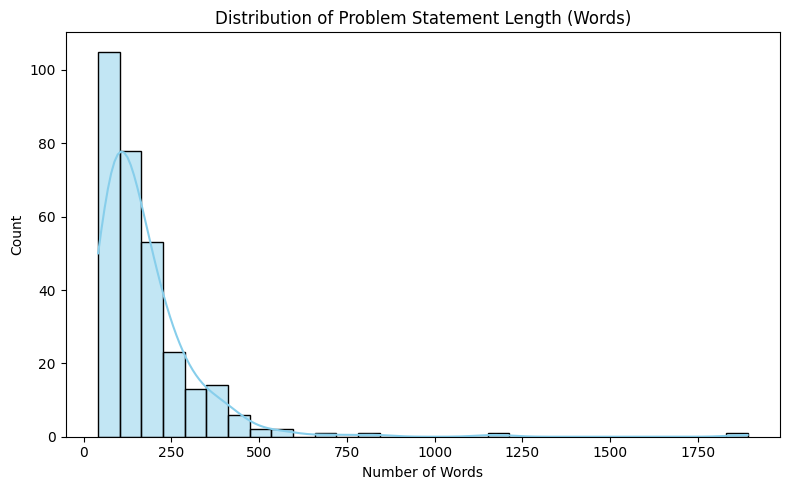

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df["problem_length_words"], bins=30, kde=True, color="skyblue")
plt.title("Distribution of Problem Statement Length (Words)")
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x=pd.qcut(df["difficulty_score"], 4), y=df["problem_length_words"])
plt.xlabel("Difficulty Quartile")
plt.ylabel("Problem Statement Length (words)")
plt.title("Problem Length vs Difficulty Score")
plt.tight_layout()
plt.show()


KeyError: 'difficulty_score'

<Figure size 800x500 with 0 Axes>

In [ ]:
corr = df[["problem_length_words", "patch_total", "test_patch_total", "n_failures", "difficulty_score"]].corr()
print(corr["problem_length_words"].sort_values(ascending=False))


KeyError: "['difficulty_score'] not in index"

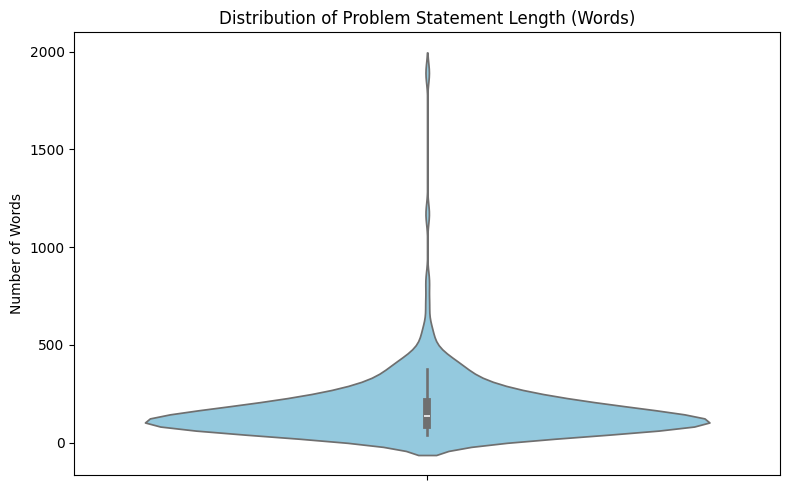

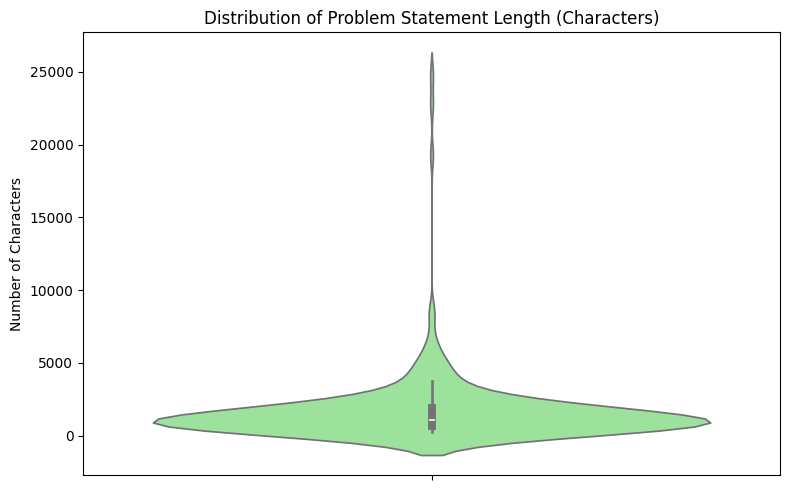

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Violin plot for number of words
plt.figure(figsize=(8,5))
sns.violinplot(y=df["problem_length_words"], color="skyblue")
plt.title("Distribution of Problem Statement Length (Words)")
plt.ylabel("Number of Words")
plt.xlabel("")
plt.tight_layout()
plt.show()

# Violin plot for number of characters
plt.figure(figsize=(8,5))
sns.violinplot(y=df["problem_length_chars"], color="lightgreen")
plt.title("Distribution of Problem Statement Length (Characters)")
plt.ylabel("Number of Characters")
plt.xlabel("")
plt.tight_layout()
plt.show()


In [ ]:
df.head()

repo             instance_id  \
0  astropy/astropy  astropy__astropy-12907   
1  astropy/astropy  astropy__astropy-14182   
2  astropy/astropy  astropy__astropy-14365   
3  astropy/astropy  astropy__astropy-14995   
4  astropy/astropy   astropy__astropy-6938   

                                base_commit  \
0  d16bfe05a744909de4b27f5875fe0d4ed41ce607   
1  a5917978be39d13cd90b517e1de4e7a539ffaa48   
2  7269fa3e33e8d02485a647da91a5a2a60a06af61   
3  b16c7d12ccbc7b2d20364b89fb44285bcbfede54   
4  c76af9ed6bb89bfba45b9f5bc1e635188278e2fa   

                                               patch  \
0  diff --git a/astropy/modeling/separable.py b/a...   
1  diff --git a/astropy/io/ascii/rst.py b/astropy...   
2  diff --git a/astropy/io/ascii/qdp.py b/astropy...   
3  diff --git a/astropy/nddata/mixins/ndarithmeti...   
4  diff --git a/astropy/io/fits/fitsrec.py b/astr...   

                                          test_patch  \
0  diff --git a/astropy/modeling/tests/test_separ...   
1  diff --git a/astropy/io/ascii/tests/test_rst.p...   
2  diff --git a/astropy/io/ascii/tests/test_qdp.p...   
3  diff --git a/astropy/nddata/mixins/tests/test_...   
4  diff --git a/astropy/io/fits/tests/test_checks...   

                                   problem_statement  \
0  Modeling's `separability_matrix` does not comp...   
1  Please support header rows in RestructuredText...   
2  ascii.qdp Table format assumes QDP commands ar...   
3  In v5.3, NDDataRef mask propagation fails when...   
4  Possible bug in io.fits related to D exponents...   

                                          hints_text            created_at  \
0                                                NaN  2022-03-03T15:14:54Z   
1                                                NaN  2022-12-16T11:13:37Z   
2  Welcome to Astropy 👋 and thank you for your fi...  2023-02-06T19:20:34Z   
3  Welcome to Astropy 👋 and thank you for your fi...  2023-06-27T19:48:18Z   
4  It is tested with `astropy/io/fits/tests/test_...  2017-12-07T00:01:14Z   

   version                                       FAIL_TO_PASS  ...  \
0      4.3  ["astropy/modeling/tests/test_separable.py::te...  ...   
1      5.1  ["astropy/io/ascii/tests/test_rst.py::test_rst...  ...   
2      5.1  ["astropy/io/ascii/tests/test_qdp.py::test_rou...  ...   
3      5.2  ["astropy/nddata/mixins/tests/test_ndarithmeti...  ...   
4      1.3  ["astropy/io/fits/tests/test_checksum.py::Test...  ...   

  test_n_files_touched test_added_lines test_removed_lines  test_patch_total  \
0                    1               18                  1                19   
1                    1               28                  0                28   
2                    1               14                  1                15   
3                    1               39                  0                39   
4                    2               15                  2                17   

  has_test_patch  has_patch  difficulty_score  \
0           True       True          0.016866   
1           True       True          0.230208   
2           True       True          0.024750   
3           True       True          0.039750   
4           True       True          0.029902   

                             problem_statement_clean  problem_length_words  \
0  Modeling's `separability_matrix` does not comp...                   158   
1  Please support header rows in RestructuredText...                   189   
2  ascii.qdp Table format assumes QDP commands ar...                   202   
3  In v5.3, NDDataRef mask propagation fails when...                   357   
4  Possible bug in io.fits related to D exponents...                    76   

   problem_length_chars  
0                  1246  
1                  1871  
2                  1339  
3                  2455  
4                   527  

[5 rows x 38 columns]

In [ ]:
df.to_csv(Save_path + "5_with_problem_statement.csv", index = False)

## process hint

In [ ]:
import pandas as pd
df = pd.read_csv(Save_path + "/RQ1/4_df_with_all_clusters_and_patch_features_and_test_metadata_and_test_patch.csv")
df.head()

repo             instance_id  \
0  astropy/astropy  astropy__astropy-12907   
1  astropy/astropy  astropy__astropy-14182   
2  astropy/astropy  astropy__astropy-14365   
3  astropy/astropy  astropy__astropy-14995   
4  astropy/astropy   astropy__astropy-6938   

                                base_commit  \
0  d16bfe05a744909de4b27f5875fe0d4ed41ce607   
1  a5917978be39d13cd90b517e1de4e7a539ffaa48   
2  7269fa3e33e8d02485a647da91a5a2a60a06af61   
3  b16c7d12ccbc7b2d20364b89fb44285bcbfede54   
4  c76af9ed6bb89bfba45b9f5bc1e635188278e2fa   

                                               patch  \
0  diff --git a/astropy/modeling/separable.py b/a...   
1  diff --git a/astropy/io/ascii/rst.py b/astropy...   
2  diff --git a/astropy/io/ascii/qdp.py b/astropy...   
3  diff --git a/astropy/nddata/mixins/ndarithmeti...   
4  diff --git a/astropy/io/fits/fitsrec.py b/astr...   

                                          test_patch  \
0  diff --git a/astropy/modeling/tests/test_separ...   
1  diff --git a/astropy/io/ascii/tests/test_rst.p...   
2  diff --git a/astropy/io/ascii/tests/test_qdp.p...   
3  diff --git a/astropy/nddata/mixins/tests/test_...   
4  diff --git a/astropy/io/fits/tests/test_checks...   

                                   problem_statement  \
0  Modeling's `separability_matrix` does not comp...   
1  Please support header rows in RestructuredText...   
2  ascii.qdp Table format assumes QDP commands ar...   
3  In v5.3, NDDataRef mask propagation fails when...   
4  Possible bug in io.fits related to D exponents...   

                                          hints_text            created_at  \
0                                                NaN  2022-03-03T15:14:54Z   
1                                                NaN  2022-12-16T11:13:37Z   
2  Welcome to Astropy 👋 and thank you for your fi...  2023-02-06T19:20:34Z   
3  Welcome to Astropy 👋 and thank you for your fi...  2023-06-27T19:48:18Z   
4  It is tested with `astropy/io/fits/tests/test_...  2017-12-07T00:01:14Z   

   version                                       FAIL_TO_PASS  ...  \
0      4.3  ["astropy/modeling/tests/test_separable.py::te...  ...   
1      5.1  ["astropy/io/ascii/tests/test_rst.py::test_rst...  ...   
2      5.1  ["astropy/io/ascii/tests/test_qdp.py::test_rou...  ...   
3      5.2  ["astropy/nddata/mixins/tests/test_ndarithmeti...  ...   
4      1.3  ["astropy/io/fits/tests/test_checksum.py::Test...  ...   

  removed_lines patch_total n_failures  n_passes_after test_n_files_touched  \
0             1           2          2              13                    1   
1            10          41          1               9                    1   
2             2           4          1               8                    1   
3             2           4          1             179                    1   
4             1           2          2              11                    2   

   test_added_lines  test_removed_lines test_patch_total  has_test_patch  \
0                18                   1               19            True   
1                28                   0               28            True   
2                14                   1               15            True   
3                39                   0               39            True   
4                15                   2               17            True   

   has_patch  
0       True  
1       True  
2       True  
3       True  
4       True  

[5 rows x 34 columns]

In [ ]:
# Replace NaN with empty string
df["hints_text_clean"] = df["hints_text"].fillna("")

# Boolean: does the instance have a hint?
df["has_hint"] = df["hints_text_clean"].apply(lambda x: len(x.strip()) > 0)

# Word count of hint text
df["hint_length"] = df["hints_text_clean"].apply(lambda x: len(x.split()))

df.head()

repo             instance_id  \
0  astropy/astropy  astropy__astropy-12907   
1  astropy/astropy  astropy__astropy-14182   
2  astropy/astropy  astropy__astropy-14365   
3  astropy/astropy  astropy__astropy-14995   
4  astropy/astropy   astropy__astropy-6938   

                                base_commit  \
0  d16bfe05a744909de4b27f5875fe0d4ed41ce607   
1  a5917978be39d13cd90b517e1de4e7a539ffaa48   
2  7269fa3e33e8d02485a647da91a5a2a60a06af61   
3  b16c7d12ccbc7b2d20364b89fb44285bcbfede54   
4  c76af9ed6bb89bfba45b9f5bc1e635188278e2fa   

                                               patch  \
0  diff --git a/astropy/modeling/separable.py b/a...   
1  diff --git a/astropy/io/ascii/rst.py b/astropy...   
2  diff --git a/astropy/io/ascii/qdp.py b/astropy...   
3  diff --git a/astropy/nddata/mixins/ndarithmeti...   
4  diff --git a/astropy/io/fits/fitsrec.py b/astr...   

                                          test_patch  \
0  diff --git a/astropy/modeling/tests/test_separ...   
1  diff --git a/astropy/io/ascii/tests/test_rst.p...   
2  diff --git a/astropy/io/ascii/tests/test_qdp.p...   
3  diff --git a/astropy/nddata/mixins/tests/test_...   
4  diff --git a/astropy/io/fits/tests/test_checks...   

                                   problem_statement  \
0  Modeling's `separability_matrix` does not comp...   
1  Please support header rows in RestructuredText...   
2  ascii.qdp Table format assumes QDP commands ar...   
3  In v5.3, NDDataRef mask propagation fails when...   
4  Possible bug in io.fits related to D exponents...   

                                          hints_text            created_at  \
0                                                NaN  2022-03-03T15:14:54Z   
1                                                NaN  2022-12-16T11:13:37Z   
2  Welcome to Astropy 👋 and thank you for your fi...  2023-02-06T19:20:34Z   
3  Welcome to Astropy 👋 and thank you for your fi...  2023-06-27T19:48:18Z   
4  It is tested with `astropy/io/fits/tests/test_...  2017-12-07T00:01:14Z   

   version                                       FAIL_TO_PASS  ...  \
0      4.3  ["astropy/modeling/tests/test_separable.py::te...  ...   
1      5.1  ["astropy/io/ascii/tests/test_rst.py::test_rst...  ...   
2      5.1  ["astropy/io/ascii/tests/test_qdp.py::test_rou...  ...   
3      5.2  ["astropy/nddata/mixins/tests/test_ndarithmeti...  ...   
4      1.3  ["astropy/io/fits/tests/test_checksum.py::Test...  ...   

  n_passes_after test_n_files_touched test_added_lines  test_removed_lines  \
0             13                    1               18                   1   
1              9                    1               28                   0   
2              8                    1               14                   1   
3            179                    1               39                   0   
4             11                    2               15                   2   

  test_patch_total  has_test_patch  has_patch  \
0               19            True       True   
1               28            True       True   
2               15            True       True   
3               39            True       True   
4               17            True       True   

                                    hints_text_clean  has_hint  hint_length  
0                                                        False            0  
1                                                        False            0  
2  Welcome to Astropy 👋 and thank you for your fi...      True          206  
3  Welcome to Astropy 👋 and thank you for your fi...      True          808  
4  It is tested with `astropy/io/fits/tests/test_...      True           55  

[5 rows x 37 columns]

In [ ]:
average = df["hint_length"].mean()
print("Average hint length:", average)

Average hint length: 198.39


In [ ]:
df["has_hint"].value_counts()

has_hint
True     223
False     77
Name: count, dtype: int64

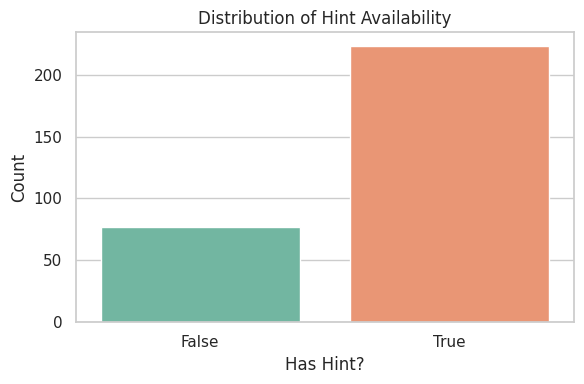

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x="has_hint", data=df, palette="Set2")
plt.title("Distribution of Hint Availability")
plt.xlabel("Has Hint?")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


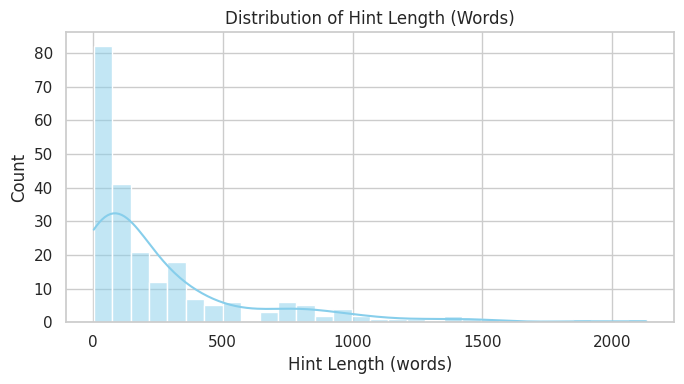

In [ ]:
plt.figure(figsize=(7,4))
sns.histplot(df[df["hint_length"] > 0]["hint_length"], bins=30, kde=True, color="skyblue")
plt.title("Distribution of Hint Length (Words)")
plt.xlabel("Hint Length (words)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


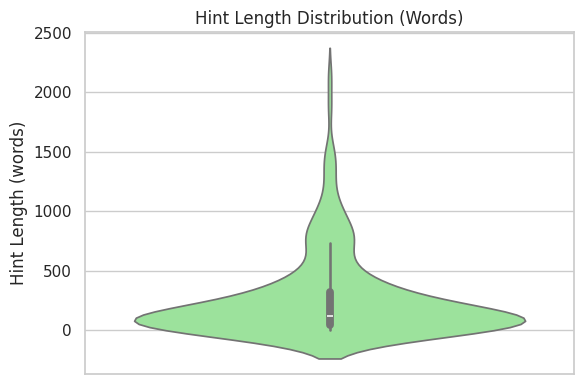

In [ ]:
plt.figure(figsize=(6,4))
sns.violinplot(y=df[df["hint_length"] > 0]["hint_length"], color="lightgreen")
plt.title("Hint Length Distribution (Words)")
plt.ylabel("Hint Length (words)")
plt.xlabel("")
plt.tight_layout()
plt.show()


# Defining complexity score

In [ ]:
from sklearn.preprocessing import MinMaxScaler

difficulty_features = df[[
    "patch_total",
    "n_files_touched",
    "test_patch_total",
    "test_n_files_touched",
    "n_failures"
]].fillna(0)

scaler = MinMaxScaler() ## normalize the values
difficulty_scaled = scaler.fit_transform(difficulty_features)

# Convert back to DataFrame for clarity
difficulty_scaled_df = pd.DataFrame(
    difficulty_scaled,
    columns=["patch_total_norm", "n_files_touched_norm",
             "test_patch_total_norm", "test_n_files_touched_norm",
             "n_failures_norm"]
)


In [ ]:
difficulty_scaled_df.head()

patch_total_norm  n_files_touched_norm  test_patch_total_norm  \
0          0.013333                   0.0               0.056250   
1          0.533333                   0.0               0.084375   
2          0.040000                   0.0               0.043750   
3          0.040000                   0.0               0.118750   
4          0.013333                   0.0               0.050000   

   test_n_files_touched_norm  n_failures_norm  
0                   0.000000         0.002825  
1                   0.000000         0.000000  
2                   0.000000         0.000000  
3                   0.000000         0.000000  
4                   0.142857         0.002825

The difficulty score is a weighted combination of different features:

patch_total_norm → size of code change

n_files_touched_norm → number of files touched in code

test_patch_total_norm → size of test change

test_n_files_touched_norm → number of files touched in tests

n_failures_norm → number of failing tests

Each feature contributes differently to “difficulty”:

A huge patch is usually harder than a small one → higher weight

More failing tests may make reasoning more complex → moderate weight

Test patch size is often less critical than code patch size → moderate weight

| Feature                     | Weight | Reasoning                                                                   |
| --------------------------- | ------ | --------------------------------------------------------------------------- |
| `patch_total_norm`          | 0.4    | Biggest contributor to difficulty (longer patches usually harder)           |
| `n_files_touched_norm`      | 0.2    | Multi-file patches are harder, but less impactful than patch size           |
| `test_patch_total_norm`     | 0.2    | Test edits add complexity, but usually less than main code patch            |
| `test_n_files_touched_norm` | 0.1    | Number of test files affected adds some difficulty, smaller than patch size |
| `n_failures_norm`           | 0.1    | Failing tests contribute to reasoning difficulty, but normalized already    |


In [ ]:
difficulty_scaled_df["difficulty_score"] = (
    0.4 * difficulty_scaled_df["patch_total_norm"] +
    0.2 * difficulty_scaled_df["n_files_touched_norm"] +
    0.2 * difficulty_scaled_df["test_patch_total_norm"] +
    0.1 * difficulty_scaled_df["test_n_files_touched_norm"] +
    0.1 * difficulty_scaled_df["n_failures_norm"]
)

# Merge into main df
df["difficulty_score"] = difficulty_scaled_df["difficulty_score"]


In [ ]:
df.head()

repo             instance_id  \
0  astropy/astropy  astropy__astropy-12907   
1  astropy/astropy  astropy__astropy-14182   
2  astropy/astropy  astropy__astropy-14365   
3  astropy/astropy  astropy__astropy-14995   
4  astropy/astropy   astropy__astropy-6938   

                                base_commit  \
0  d16bfe05a744909de4b27f5875fe0d4ed41ce607   
1  a5917978be39d13cd90b517e1de4e7a539ffaa48   
2  7269fa3e33e8d02485a647da91a5a2a60a06af61   
3  b16c7d12ccbc7b2d20364b89fb44285bcbfede54   
4  c76af9ed6bb89bfba45b9f5bc1e635188278e2fa   

                                               patch  \
0  diff --git a/astropy/modeling/separable.py b/a...   
1  diff --git a/astropy/io/ascii/rst.py b/astropy...   
2  diff --git a/astropy/io/ascii/qdp.py b/astropy...   
3  diff --git a/astropy/nddata/mixins/ndarithmeti...   
4  diff --git a/astropy/io/fits/fitsrec.py b/astr...   

                                          test_patch  \
0  diff --git a/astropy/modeling/tests/test_separ...   
1  diff --git a/astropy/io/ascii/tests/test_rst.p...   
2  diff --git a/astropy/io/ascii/tests/test_qdp.p...   
3  diff --git a/astropy/nddata/mixins/tests/test_...   
4  diff --git a/astropy/io/fits/tests/test_checks...   

                                   problem_statement  \
0  Modeling's `separability_matrix` does not comp...   
1  Please support header rows in RestructuredText...   
2  ascii.qdp Table format assumes QDP commands ar...   
3  In v5.3, NDDataRef mask propagation fails when...   
4  Possible bug in io.fits related to D exponents...   

                                          hints_text            created_at  \
0                                                NaN  2022-03-03T15:14:54Z   
1                                                NaN  2022-12-16T11:13:37Z   
2  Welcome to Astropy 👋 and thank you for your fi...  2023-02-06T19:20:34Z   
3  Welcome to Astropy 👋 and thank you for your fi...  2023-06-27T19:48:18Z   
4  It is tested with `astropy/io/fits/tests/test_...  2017-12-07T00:01:14Z   

   version                                       FAIL_TO_PASS  ...  \
0      4.3  ["astropy/modeling/tests/test_separable.py::te...  ...   
1      5.1  ["astropy/io/ascii/tests/test_rst.py::test_rst...  ...   
2      5.1  ["astropy/io/ascii/tests/test_qdp.py::test_rou...  ...   
3      5.2  ["astropy/nddata/mixins/tests/test_ndarithmeti...  ...   
4      1.3  ["astropy/io/fits/tests/test_checksum.py::Test...  ...   

  test_n_files_touched test_added_lines test_removed_lines  test_patch_total  \
0                    1               18                  1                19   
1                    1               28                  0                28   
2                    1               14                  1                15   
3                    1               39                  0                39   
4                    2               15                  2                17   

  has_test_patch  has_patch  difficulty_score  \
0           True       True          0.016866   
1           True       True          0.230208   
2           True       True          0.024750   
3           True       True          0.039750   
4           True       True          0.029902   

                             problem_statement_clean  problem_length_words  \
0  Modeling's `separability_matrix` does not comp...                   158   
1  Please support header rows in RestructuredText...                   189   
2  ascii.qdp Table format assumes QDP commands ar...                   202   
3  In v5.3, NDDataRef mask propagation fails when...                   357   
4  Possible bug in io.fits related to D exponents...                    76   

   problem_length_chars  
0                  1246  
1                  1871  
2                  1339  
3                  2455  
4                   527  

[5 rows x 38 columns]

In [ ]:
df[["repo","instance_id","patch_total","n_files_touched",
    "test_patch_total","test_n_files_touched","n_failures","difficulty_score"]] \
    .sort_values("difficulty_score", ascending=False).head(10)


repo                   instance_id  patch_total  \
115          django/django          django__django-16820           65   
9            django/django          django__django-11019           76   
149          pallets/flask           pallets__flask-5063           65   
132  matplotlib/matplotlib  matplotlib__matplotlib-24265           69   
210      sphinx-doc/sphinx       sphinx-doc__sphinx-7686           54   
120  matplotlib/matplotlib  matplotlib__matplotlib-18869           67   
273            sympy/sympy            sympy__sympy-19254           61   
278            sympy/sympy            sympy__sympy-20322           54   
267            sympy/sympy            sympy__sympy-18199           50   
208      sphinx-doc/sphinx      sphinx-doc__sphinx-10451           20   

     n_files_touched  test_patch_total  test_n_files_touched  n_failures  \
115                1               321                     2           7   
9                  1               127                     3          16   
149                1                51                     1           2   
132                1                 2                     1           1   
210                1               102                     2           2   
120                1                10                     1           4   
273                1                 3                     1           1   
278                1                21                     1           1   
267                1                18                     2           1   
208                1               112                     8           2   

     difficulty_score  
115          0.557314  
9            0.511559  
149          0.372866  
132          0.363292  
210          0.360360  
120          0.358472  
273          0.321250  
278          0.295167  
267          0.286244  
208          0.270991

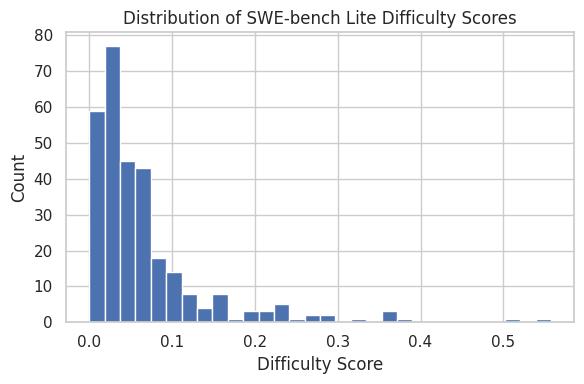

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(df["difficulty_score"], bins=30)
plt.xlabel("Difficulty Score")
plt.ylabel("Count")
plt.title("Distribution of SWE-bench Lite Difficulty Scores")
plt.tight_layout()
plt.show()


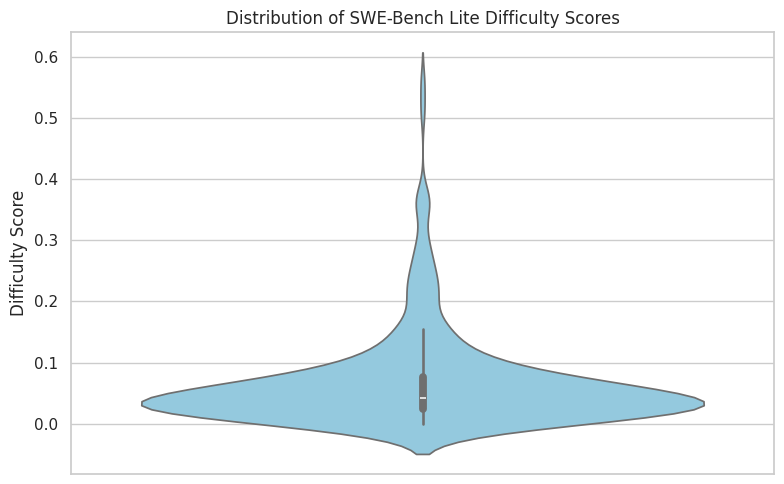

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.violinplot(y=df["difficulty_score"], color="skyblue")
plt.title("Distribution of SWE-Bench Lite Difficulty Scores")
plt.ylabel("Difficulty Score")
plt.xlabel("")  # no x-axis label, single distribution
plt.tight_layout()
plt.show()


We computed a comprehensive difficulty score for SWE-bench Lite issues by combining source code patch size, files touched, test patch size, test files touched, and the number of failing tests. The resulting score effectively captures both the complexity of the code changes and the testing effort required to resolve the bug. As expected, issues requiring both code and test modifications generally have higher difficulty scores, while simple code-only or test-only issues have lower scores. This metric provides a unified measure of issue complexity and can be used to rank or categorize issues for analysis or benchmarking.

In [ ]:
df.to_csv(Save_path + "5_df_with_difficulty_score.csv", index = False)

# Analysis

## cleaning dataset

In [ ]:
analysis_path = "/content/drive/MyDrive/EECS6444/Analysis/"
# df.to_csv(analysis_path + "final_csv.csv", index=False)

In [ ]:
analysis_df = pd.read_csv(analysis_path + "final_csv.csv")
analysis_df.head()

repo             instance_id  \
0  astropy/astropy  astropy__astropy-12907   
1  astropy/astropy  astropy__astropy-14182   
2  astropy/astropy  astropy__astropy-14365   
3  astropy/astropy  astropy__astropy-14995   
4  astropy/astropy   astropy__astropy-6938   

                                base_commit  \
0  d16bfe05a744909de4b27f5875fe0d4ed41ce607   
1  a5917978be39d13cd90b517e1de4e7a539ffaa48   
2  7269fa3e33e8d02485a647da91a5a2a60a06af61   
3  b16c7d12ccbc7b2d20364b89fb44285bcbfede54   
4  c76af9ed6bb89bfba45b9f5bc1e635188278e2fa   

                                               patch  \
0  diff --git a/astropy/modeling/separable.py b/a...   
1  diff --git a/astropy/io/ascii/rst.py b/astropy...   
2  diff --git a/astropy/io/ascii/qdp.py b/astropy...   
3  diff --git a/astropy/nddata/mixins/ndarithmeti...   
4  diff --git a/astropy/io/fits/fitsrec.py b/astr...   

                                          test_patch  \
0  diff --git a/astropy/modeling/tests/test_separ...   
1  diff --git a/astropy/io/ascii/tests/test_rst.p...   
2  diff --git a/astropy/io/ascii/tests/test_qdp.p...   
3  diff --git a/astropy/nddata/mixins/tests/test_...   
4  diff --git a/astropy/io/fits/tests/test_checks...   

                                   problem_statement  \
0  Modeling's `separability_matrix` does not comp...   
1  Please support header rows in RestructuredText...   
2  ascii.qdp Table format assumes QDP commands ar...   
3  In v5.3, NDDataRef mask propagation fails when...   
4  Possible bug in io.fits related to D exponents...   

                                          hints_text            created_at  \
0                                                NaN  2022-03-03T15:14:54Z   
1                                                NaN  2022-12-16T11:13:37Z   
2  Welcome to Astropy 👋 and thank you for your fi...  2023-02-06T19:20:34Z   
3  Welcome to Astropy 👋 and thank you for your fi...  2023-06-27T19:48:18Z   
4  It is tested with `astropy/io/fits/tests/test_...  2017-12-07T00:01:14Z   

   version                                       FAIL_TO_PASS  ...  \
0      4.3  ["astropy/modeling/tests/test_separable.py::te...  ...   
1      5.1  ["astropy/io/ascii/tests/test_rst.py::test_rst...  ...   
2      5.1  ["astropy/io/ascii/tests/test_qdp.py::test_rou...  ...   
3      5.2  ["astropy/nddata/mixins/tests/test_ndarithmeti...  ...   
4      1.3  ["astropy/io/fits/tests/test_checksum.py::Test...  ...   

  test_patch_total has_test_patch has_patch  difficulty_score  \
0               19           True      True          0.016866   
1               28           True      True          0.230208   
2               15           True      True          0.024750   
3               39           True      True          0.039750   
4               17           True      True          0.029902   

                             problem_statement_clean  problem_length_words  \
0  Modeling's `separability_matrix` does not comp...                   158   
1  Please support header rows in RestructuredText...                   189   
2  ascii.qdp Table format assumes QDP commands ar...                   202   
3  In v5.3, NDDataRef mask propagation fails when...                   357   
4  Possible bug in io.fits related to D exponents...                    76   

   problem_length_chars                                   hints_text_clean  \
0                  1246                                                NaN   
1                  1871                                                NaN   
2                  1339  Welcome to Astropy 👋 and thank you for your fi...   
3                  2455  Welcome to Astropy 👋 and thank you for your fi...   
4                   527  It is tested with `astropy/io/fits/tests/test_...   

   has_hint  hint_length  
0     False            0  
1     False            0  
2      True          206  
3      True          808  
4      True           55  

[5 rows x 41 columns]

In [ ]:
print(analysis_df.columns.tolist())


['repo', 'instance_id', 'base_commit', 'patch', 'test_patch', 'problem_statement', 'hints_text', 'created_at', 'version', 'FAIL_TO_PASS', 'PASS_TO_PASS', 'environment_setup_commit', 'predicted_labels', 'predicted_scores', 'all_label_scores', 'bert_topic', 'lda_topic', 'text_clean', 'kmeans_cluster', 'hdbscan_cluster', 'umap_x', 'umap_y', 'n_files_touched', 'added_lines', 'removed_lines', 'patch_total', 'n_failures', 'n_passes_after', 'test_n_files_touched', 'test_added_lines', 'test_removed_lines', 'test_patch_total', 'has_test_patch', 'has_patch', 'difficulty_score', 'problem_statement_clean', 'problem_length_words', 'problem_length_chars', 'hints_text_clean', 'has_hint', 'hint_length']


In [ ]:
cols_drop = ['base_commit', 'patch', 'test_patch', 'problem_statement', 'hints_text', 'created_at', 'FAIL_TO_PASS',
             'PASS_TO_PASS', 'environment_setup_commit', 'all_label_scores', 'text_clean', 'umap_x', 'umap_y',
             'problem_statement_clean', 'hints_text_clean']
analysis_df = analysis_df.drop(columns=cols_drop)

In [ ]:
analysis_df.head()

repo             instance_id  version predicted_labels  \
0  astropy/astropy  astropy__astropy-12907      4.3              bug   
1  astropy/astropy  astropy__astropy-14182      5.1      enhancement   
2  astropy/astropy  astropy__astropy-14365      5.1              bug   
3  astropy/astropy  astropy__astropy-14995      5.2              bug   
4  astropy/astropy   astropy__astropy-6938      1.3              bug   

   predicted_scores  bert_topic  lda_topic  kmeans_cluster  hdbscan_cluster  \
0          0.792346           4         11               2               -1   
1          0.999485           4          5               5               -1   
2          0.998833           0          5               7               -1   
3          0.999328           4          5               2                3   
4          0.999293           1          9               2               -1   

   n_files_touched  ...  test_added_lines  test_removed_lines  \
0                1  ...                18                   1   
1                1  ...                28                   0   
2                1  ...                14                   1   
3                1  ...                39                   0   
4                1  ...                15                   2   

   test_patch_total  has_test_patch  has_patch  difficulty_score  \
0                19            True       True          0.016866   
1                28            True       True          0.230208   
2                15            True       True          0.024750   
3                39            True       True          0.039750   
4                17            True       True          0.029902   

   problem_length_words  problem_length_chars  has_hint  hint_length  
0                   158                  1246     False            0  
1                   189                  1871     False            0  
2                   202                  1339      True          206  
3                   357                  2455      True          808  
4                    76                   527      True           55  

[5 rows x 26 columns]

In [ ]:
set(list(analysis_df["predicted_labels"]))

{'bug', 'enhancement', 'question'}

In [ ]:
print(analysis_df.columns.tolist())


['repo', 'instance_id', 'version', 'predicted_labels', 'predicted_scores', 'bert_topic', 'lda_topic', 'kmeans_cluster', 'hdbscan_cluster', 'n_files_touched', 'added_lines', 'removed_lines', 'patch_total', 'n_failures', 'n_passes_after', 'test_n_files_touched', 'test_added_lines', 'test_removed_lines', 'test_patch_total', 'has_test_patch', 'has_patch', 'difficulty_score', 'problem_length_words', 'problem_length_chars', 'has_hint', 'hint_length']


In [ ]:
mapping = {"bug": 0, "enhancement": 1, "question": 2}
analysis_df["predicted_labels"] = analysis_df["predicted_labels"].map(mapping)
analysis_df.head()

repo             instance_id  version  predicted_labels  \
0  astropy/astropy  astropy__astropy-12907      4.3                 0   
1  astropy/astropy  astropy__astropy-14182      5.1                 1   
2  astropy/astropy  astropy__astropy-14365      5.1                 0   
3  astropy/astropy  astropy__astropy-14995      5.2                 0   
4  astropy/astropy   astropy__astropy-6938      1.3                 0   

   predicted_scores  bert_topic  lda_topic  kmeans_cluster  hdbscan_cluster  \
0          0.792346           4         11               2               -1   
1          0.999485           4          5               5               -1   
2          0.998833           0          5               7               -1   
3          0.999328           4          5               2                3   
4          0.999293           1          9               2               -1   

   n_files_touched  ...  test_added_lines  test_removed_lines  \
0                1  ...                18                   1   
1                1  ...                28                   0   
2                1  ...                14                   1   
3                1  ...                39                   0   
4                1  ...                15                   2   

   test_patch_total  has_test_patch  has_patch  difficulty_score  \
0                19            True       True          0.016866   
1                28            True       True          0.230208   
2                15            True       True          0.024750   
3                39            True       True          0.039750   
4                17            True       True          0.029902   

   problem_length_words  problem_length_chars  has_hint  hint_length  
0                   158                  1246     False            0  
1                   189                  1871     False            0  
2                   202                  1339      True          206  
3                   357                  2455      True          808  
4                    76                   527      True           55  

[5 rows x 26 columns]

In [ ]:
analysis_df["has_test_patch"] = analysis_df["has_test_patch"].astype(int)
analysis_df["has_patch"] = analysis_df["has_patch"].astype(int)
analysis_df["has_hint"] = analysis_df["has_hint"].astype(int)
analysis_df.head()
# True → 1

# False → 0

repo             instance_id  version  predicted_labels  \
0  astropy/astropy  astropy__astropy-12907      4.3                 0   
1  astropy/astropy  astropy__astropy-14182      5.1                 1   
2  astropy/astropy  astropy__astropy-14365      5.1                 0   
3  astropy/astropy  astropy__astropy-14995      5.2                 0   
4  astropy/astropy   astropy__astropy-6938      1.3                 0   

   predicted_scores  bert_topic  lda_topic  kmeans_cluster  hdbscan_cluster  \
0          0.792346           4         11               2               -1   
1          0.999485           4          5               5               -1   
2          0.998833           0          5               7               -1   
3          0.999328           4          5               2                3   
4          0.999293           1          9               2               -1   

   n_files_touched  ...  test_added_lines  test_removed_lines  \
0                1  ...                18                   1   
1                1  ...                28                   0   
2                1  ...                14                   1   
3                1  ...                39                   0   
4                1  ...                15                   2   

   test_patch_total  has_test_patch  has_patch  difficulty_score  \
0                19               1          1          0.016866   
1                28               1          1          0.230208   
2                15               1          1          0.024750   
3                39               1          1          0.039750   
4                17               1          1          0.029902   

   problem_length_words  problem_length_chars  has_hint  hint_length  
0                   158                  1246         0            0  
1                   189                  1871         0            0  
2                   202                  1339         1          206  
3                   357                  2455         1          808  
4                    76                   527         1           55  

[5 rows x 26 columns]

In [ ]:
analysis_df.to_csv(analysis_path + "final_df_cleaned.csv", index=False)

## EDA

### more cleaning

In [ ]:
df = pd.read_csv(analysis_path + "final_df_cleaned.csv")
df.head()

repo             instance_id  version  predicted_labels  \
0  astropy/astropy  astropy__astropy-12907      4.3                 0   
1  astropy/astropy  astropy__astropy-14182      5.1                 1   
2  astropy/astropy  astropy__astropy-14365      5.1                 0   
3  astropy/astropy  astropy__astropy-14995      5.2                 0   
4  astropy/astropy   astropy__astropy-6938      1.3                 0   

   predicted_scores  bert_topic  lda_topic  kmeans_cluster  hdbscan_cluster  \
0          0.792346           4         11               2               -1   
1          0.999485           4          5               5               -1   
2          0.998833           0          5               7               -1   
3          0.999328           4          5               2                3   
4          0.999293           1          9               2               -1   

   n_files_touched  ...  test_added_lines  test_removed_lines  \
0                1  ...                18                   1   
1                1  ...                28                   0   
2                1  ...                14                   1   
3                1  ...                39                   0   
4                1  ...                15                   2   

   test_patch_total  has_test_patch  has_patch  difficulty_score  \
0                19               1          1          0.016866   
1                28               1          1          0.230208   
2                15               1          1          0.024750   
3                39               1          1          0.039750   
4                17               1          1          0.029902   

   problem_length_words  problem_length_chars  has_hint  hint_length  
0                   158                  1246         0            0  
1                   189                  1871         0            0  
2                   202                  1339         1          206  
3                   357                  2455         1          808  
4                    76                   527         1           55  

[5 rows x 26 columns]

In [ ]:
df.describe()

version  predicted_labels  predicted_scores  bert_topic   lda_topic  \
count  300.000000        300.000000        300.000000  300.000000  300.000000   
mean     2.765833          0.293333          0.976342    0.830000    5.103333   
std      1.577280          0.549206          0.072885    1.296161    3.263150   
min      0.120000          0.000000          0.548640   -1.000000    0.000000   
25%      1.400000          0.000000          0.998068    0.000000    3.000000   
50%      3.100000          0.000000          0.999152    0.000000    5.000000   
75%      4.000000          0.000000          0.999323    1.000000    7.000000   
max      8.000000          2.000000          0.999677    4.000000   11.000000   

       kmeans_cluster  hdbscan_cluster  n_files_touched  added_lines  \
count      300.000000       300.000000            300.0   300.000000   
mean         4.453333         1.143333              1.0     7.510000   
std          2.840431         1.611867              0.0     9.616904   
min          0.000000        -1.000000              1.0     0.000000   
25%          2.000000        -1.000000              1.0     2.000000   
50%          4.500000         1.000000              1.0     4.500000   
75%          7.000000         3.000000              1.0     8.000000   
max          9.000000         3.000000              1.0    65.000000   

       removed_lines  ...  test_added_lines  test_removed_lines  \
count     300.000000  ...        300.000000          300.000000   
mean        2.620000  ...         21.140000            2.296667   
std         4.329521  ...         28.365632            7.964931   
min         0.000000  ...          1.000000            0.000000   
25%         0.000000  ...          7.000000            0.000000   
50%         1.000000  ...         13.000000            0.000000   
75%         3.000000  ...         24.000000            1.000000   
max        40.000000  ...        269.000000           79.000000   

       test_patch_total  has_test_patch  has_patch  difficulty_score  \
count        300.000000           300.0      300.0        300.000000   
mean          23.436667             1.0        1.0          0.067127   
std           31.722659             0.0        0.0          0.077448   
min            1.000000             1.0        1.0          0.000282   
25%            7.000000             1.0        1.0          0.023384   
50%           14.500000             1.0        1.0          0.041995   
75%           27.000000             1.0        1.0          0.076483   
max          321.000000             1.0        1.0          0.557314   

       problem_length_words  problem_length_chars    has_hint  hint_length  
count            300.000000            300.000000  300.000000   300.000000  
mean             174.573333           1661.176667    0.743333   198.390000  
std              162.838774           2447.983340    0.437524   327.024762  
min               41.000000            230.000000    0.000000     0.000000  
25%               88.750000            626.000000    0.000000     0.000000  
50%              134.000000           1043.500000    1.000000    66.000000  
75%              208.000000           1868.500000    1.000000   231.500000  
max             1892.000000          24770.000000    1.000000  2131.000000  

[8 rows x 24 columns]

In [ ]:
categorical_cols = []
continuous_cols = []

for col in df.columns:
    n_unique = df[col].nunique()
    if n_unique <= 10:   # heuristic: <=10 unique values → categorical
        categorical_cols.append(col)
    else:
        continuous_cols.append(col)

print("Categorical (few unique values):", categorical_cols)
print("Continuous:", continuous_cols)


Categorical (few unique values): ['predicted_labels', 'bert_topic', 'kmeans_cluster', 'hdbscan_cluster', 'n_files_touched', 'test_n_files_touched', 'has_test_patch', 'has_patch', 'has_hint']
Continuous: ['repo', 'instance_id', 'version', 'predicted_scores', 'lda_topic', 'added_lines', 'removed_lines', 'patch_total', 'n_failures', 'n_passes_after', 'test_added_lines', 'test_removed_lines', 'test_patch_total', 'difficulty_score', 'problem_length_words', 'problem_length_chars', 'hint_length']


In [ ]:
categorical_cols = ['predicted_labels', 'bert_topic', 'kmeans_cluster', 'hdbscan_cluster', 'n_files_touched', 'test_n_files_touched', 'has_test_patch', 'has_patch', 'has_hint']
for col in categorical_cols:
    print(f"\n{col} value counts:")
    print(df[col].value_counts())



predicted_labels value counts:
predicted_labels
0    226
1     60
2     14
Name: count, dtype: int64

bert_topic value counts:
bert_topic
 0    164
 1     54
 2     27
 3     24
 4     20
-1     11
Name: count, dtype: int64

kmeans_cluster value counts:
kmeans_cluster
2    38
7    37
1    34
8    34
6    30
5    27
0    26
3    26
4    26
9    22
Name: count, dtype: int64

hdbscan_cluster value counts:
hdbscan_cluster
 3    105
-1     84
 1     84
 2     14
 0     13
Name: count, dtype: int64

n_files_touched value counts:
n_files_touched
1    300
Name: count, dtype: int64

test_n_files_touched value counts:
test_n_files_touched
1    241
2     49
3      6
4      2
5      1
8      1
Name: count, dtype: int64

has_test_patch value counts:
has_test_patch
1    300
Name: count, dtype: int64

has_patch value counts:
has_patch
1    300
Name: count, dtype: int64

has_hint value counts:
has_hint
1    223
0     77
Name: count, dtype: int64


n_files_touched is alway 1

has_test_patch is always 1

has_patch is always 1

In [ ]:
cols_to_drop = ["n_files_touched", "has_test_patch", "has_patch", 'predicted_scores','problem_length_chars'
                ,'test_added_lines', 'test_removed_lines', 'added_lines', 'removed_lines']
df = df.drop(columns=cols_to_drop)
df.head()

repo             instance_id  version  predicted_labels  \
0  astropy/astropy  astropy__astropy-12907      4.3                 0   
1  astropy/astropy  astropy__astropy-14182      5.1                 1   
2  astropy/astropy  astropy__astropy-14365      5.1                 0   
3  astropy/astropy  astropy__astropy-14995      5.2                 0   
4  astropy/astropy   astropy__astropy-6938      1.3                 0   

   bert_topic  lda_topic  kmeans_cluster  hdbscan_cluster  patch_total  \
0           4         11               2               -1            2   
1           4          5               5               -1           41   
2           0          5               7               -1            4   
3           4          5               2                3            4   
4           1          9               2               -1            2   

   n_failures  n_passes_after  test_n_files_touched  test_patch_total  \
0           2              13                     1                19   
1           1               9                     1                28   
2           1               8                     1                15   
3           1             179                     1                39   
4           2              11                     2                17   

   difficulty_score  problem_length_words  has_hint  hint_length  
0          0.016866                   158         0            0  
1          0.230208                   189         0            0  
2          0.024750                   202         1          206  
3          0.039750                   357         1          808  
4          0.029902                    76         1           55

In [ ]:
df.to_csv(analysis_path + "final_df_cleaned_v2.csv", index=False)

### correlation

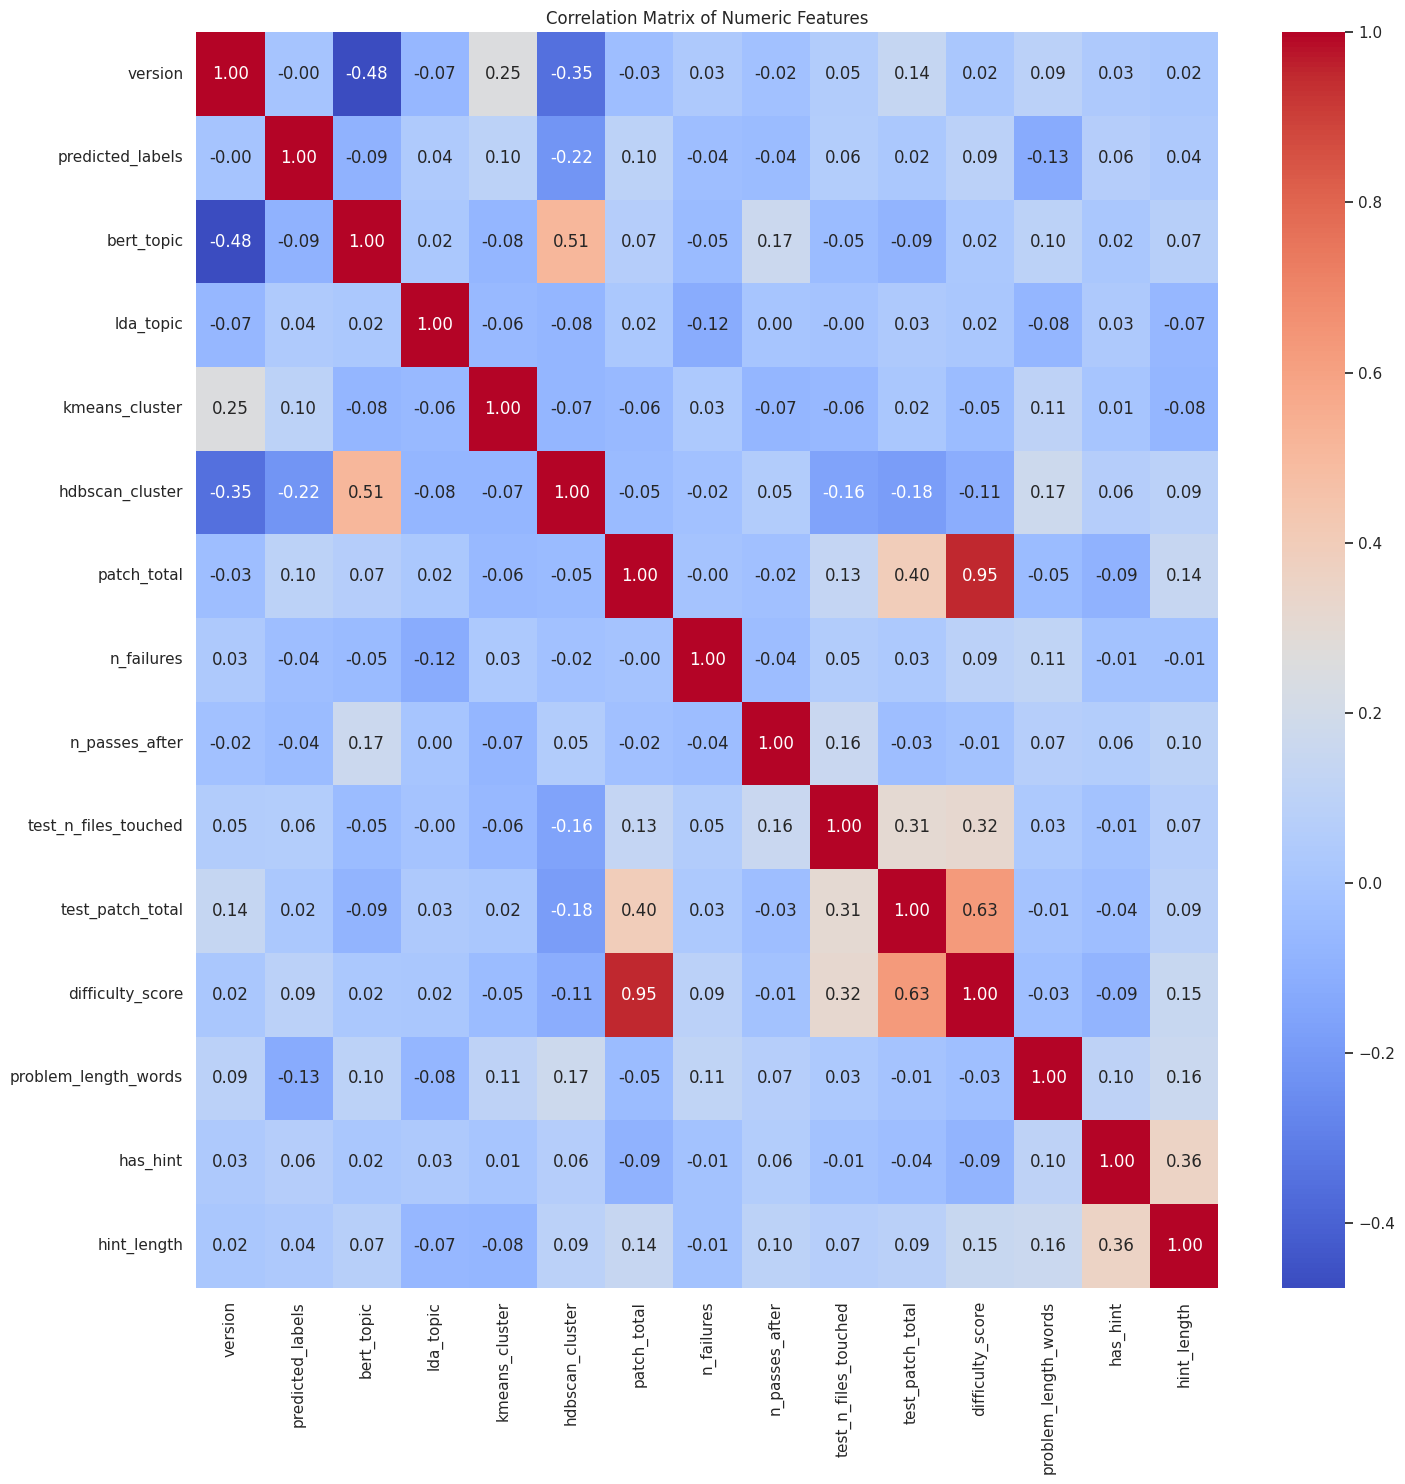

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Exclude identifier columns
id_cols = ["repo", "instance_id"]
numeric_cols = [c for c in df.columns if c not in id_cols and pd.api.types.is_numeric_dtype(df[c])]

# Calculate correlation matrix
corr_matrix = df[numeric_cols].corr()

# Show full matrix
# print(corr_matrix)

# Optional: Heatmap visualization
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.savefig(analysis_path + "correlation_matrix.pdf")
plt.show()

# # Optional: Focus on correlations with difficulty_score
# corr_with_difficulty = corr_matrix["difficulty_score"].sort_values(ascending=False)
# print("Correlation with difficulty_score:\n", corr_with_difficulty)


### Distribution analysis

In [ ]:
df = pd.read_csv(analysis_path + "final_df_cleaned_v2.csv")
df.head()

repo             instance_id  version  predicted_labels  \
0  astropy/astropy  astropy__astropy-12907      4.3                 0   
1  astropy/astropy  astropy__astropy-14182      5.1                 1   
2  astropy/astropy  astropy__astropy-14365      5.1                 0   
3  astropy/astropy  astropy__astropy-14995      5.2                 0   
4  astropy/astropy   astropy__astropy-6938      1.3                 0   

   bert_topic  lda_topic  kmeans_cluster  hdbscan_cluster  patch_total  \
0           4         11               2               -1            2   
1           4          5               5               -1           41   
2           0          5               7               -1            4   
3           4          5               2                3            4   
4           1          9               2               -1            2   

   n_failures  n_passes_after  test_n_files_touched  test_patch_total  \
0           2              13                     1                19   
1           1               9                     1                28   
2           1               8                     1                15   
3           1             179                     1                39   
4           2              11                     2                17   

   difficulty_score  problem_length_words  has_hint  hint_length  
0          0.016866                   158         0            0  
1          0.230208                   189         0            0  
2          0.024750                   202         1          206  
3          0.039750                   357         1          808  
4          0.029902                    76         1           55

In [ ]:
print(df.columns.tolist())


['repo', 'instance_id', 'version', 'predicted_labels', 'bert_topic', 'lda_topic', 'kmeans_cluster', 'hdbscan_cluster', 'patch_total', 'n_failures', 'n_passes_after', 'test_n_files_touched', 'test_patch_total', 'difficulty_score', 'problem_length_words', 'has_hint', 'hint_length']


#### version

version has neg correlation with bert topic and hdbcluster of of problem statements and a postive with k-means

In [ ]:
print("number of unique versions: " + str(len(list(set(list(df["version"]))))))

number of unique versions: 51


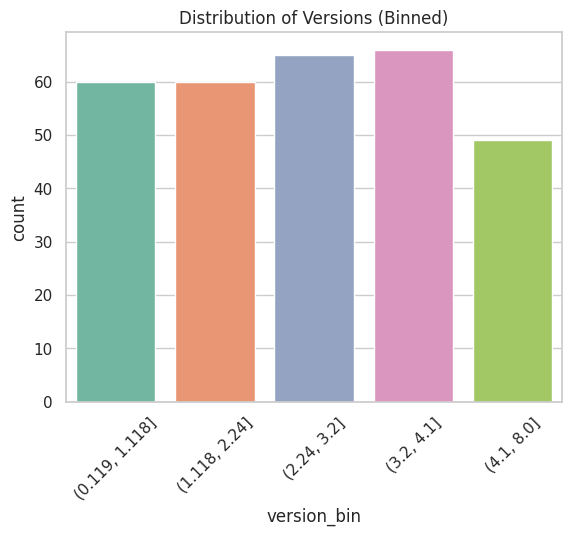

In [ ]:
# Example: bin versions into 5 groups
df["version_bin"] = pd.qcut(df["version"], q=5, duplicates='drop')
sns.countplot(x="version_bin", data=df, palette="Set2")
plt.xticks(rotation=45)
plt.title("Distribution of Versions (Binned)")
plt.show()


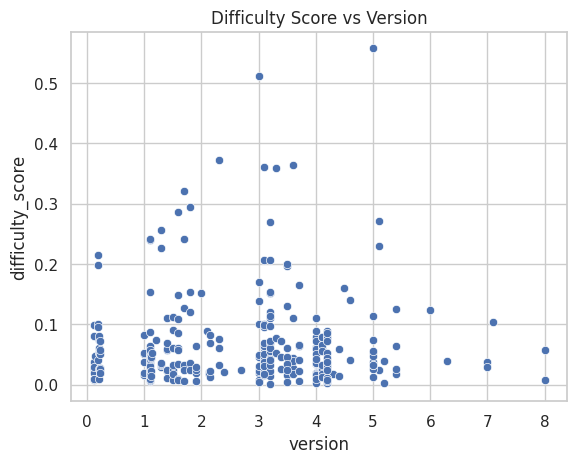

In [ ]:
sns.scatterplot(x="version", y="difficulty_score", data=df)
plt.title("Difficulty Score vs Version")
plt.show()


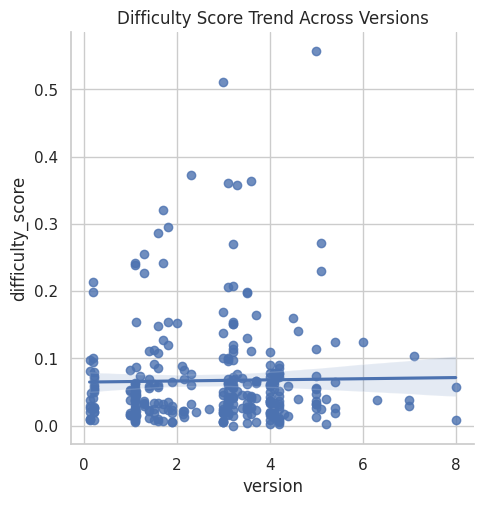

In [ ]:
sns.lmplot(x="version", y="difficulty_score", data=df)
plt.title("Difficulty Score Trend Across Versions")
plt.show()


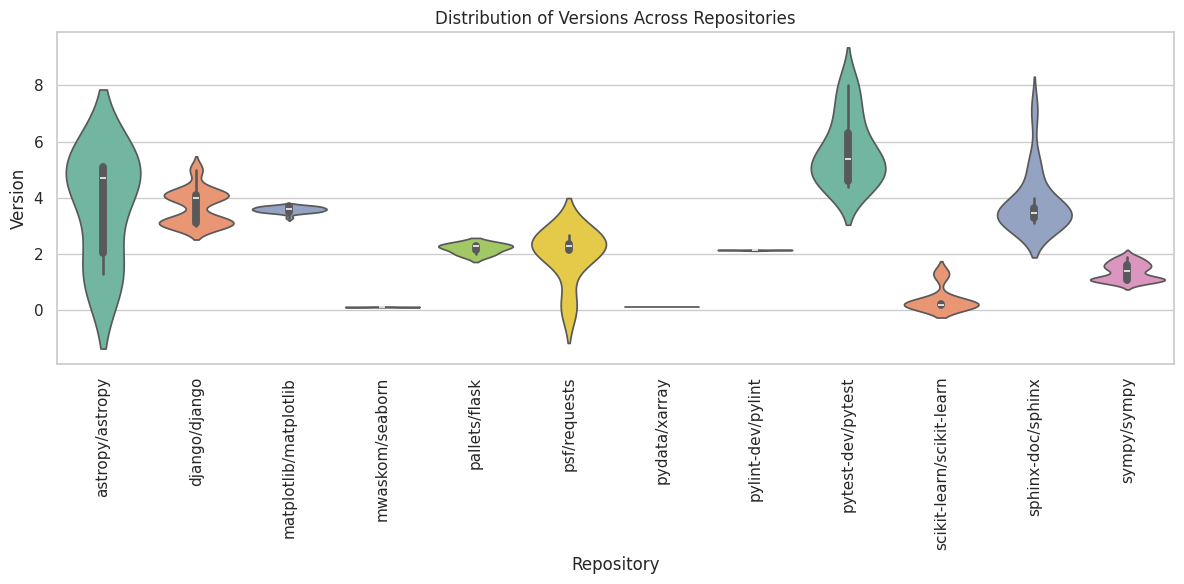

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# If version is numeric, we can plot directly
plt.figure(figsize=(12,6))
sns.violinplot(x="repo", y="version", data=df, palette="Set2")
plt.title("Distribution of Versions Across Repositories")
plt.xlabel("Repository")
plt.ylabel("Version")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(analysis_path + "version_distribution_across_repos.pdf")
plt.show()


#### predicted_labels

In [ ]:
# Select numeric columns only
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Calculate correlation with predicted_labels
corr_with_labels = df[numeric_cols].corr()["predicted_labels"].sort_values(ascending=False)

print("Correlation of numeric features with predicted_labels:")
print(corr_with_labels)


Correlation of numeric features with predicted_labels:
predicted_labels        1.000000
patch_total             0.099913
kmeans_cluster          0.098849
difficulty_score        0.092821
has_hint                0.063839
test_n_files_touched    0.055317
lda_topic               0.042748
hint_length             0.036194
test_patch_total        0.022186
version                -0.002638
n_failures             -0.036424
n_passes_after         -0.044933
bert_topic             -0.094153
problem_length_words   -0.126643
hdbscan_cluster        -0.221442
Name: predicted_labels, dtype: float64


has ~12% neg correlation with problem_length_words and ~22% neg correlation with hdbscan_cluster for the problem statemetns.

In [ ]:
mapping = {0: "bug", 1: "enhancement", 2: "question"}
df["predicted_label_str"] = df["predicted_labels"].map(mapping)


In [ ]:
label_counts = df["predicted_label_str"].value_counts()
label_percent = df["predicted_label_str"].value_counts(normalize=True) * 100

print("Counts of predicted labels:")
print(label_counts)
print("\nPercentage of predicted labels:")
print(label_percent)


Counts of predicted labels:
predicted_label_str
bug            226
enhancement     60
question        14
Name: count, dtype: int64

Percentage of predicted labels:
predicted_label_str
bug            75.333333
enhancement    20.000000
question        4.666667
Name: proportion, dtype: float64


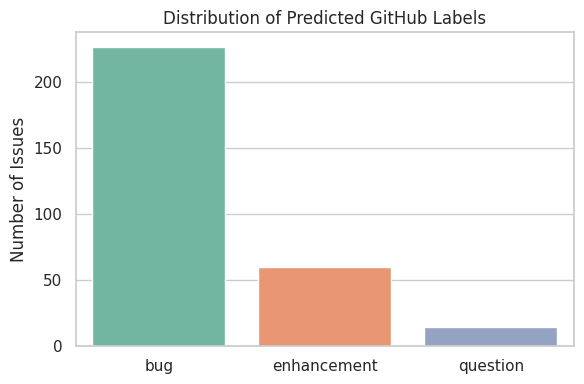

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x="predicted_label_str", data=df, palette="Set2")
plt.title("Distribution of Predicted GitHub Labels")
plt.ylabel("Number of Issues")
plt.xlabel("")
plt.tight_layout()
plt.savefig(analysis_path + "label_distribution.pdf")
plt.show()


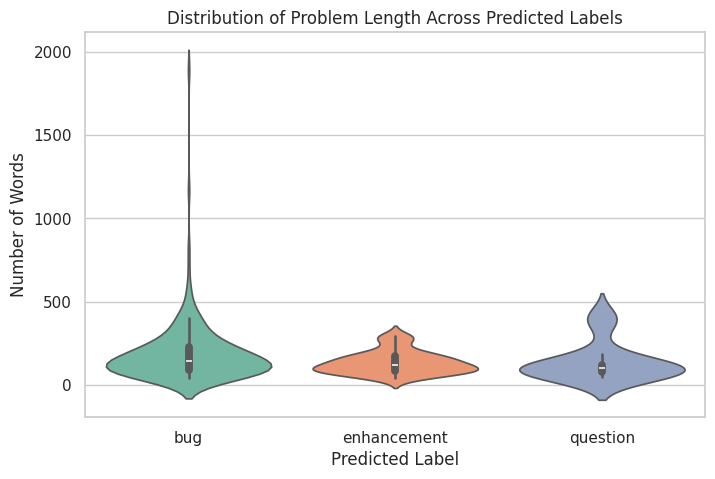

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.violinplot(x="predicted_label_str", y="problem_length_words", data=df, palette="Set2")
plt.title("Distribution of Problem Length Across Predicted Labels")
plt.xlabel("Predicted Label")
plt.ylabel("Number of Words")
plt.show()


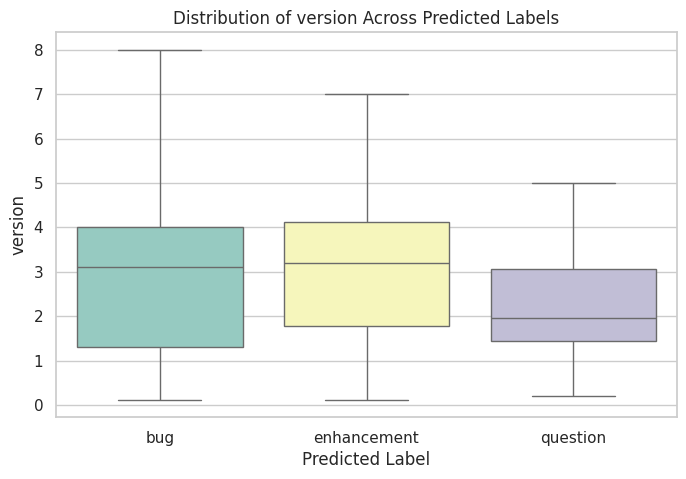

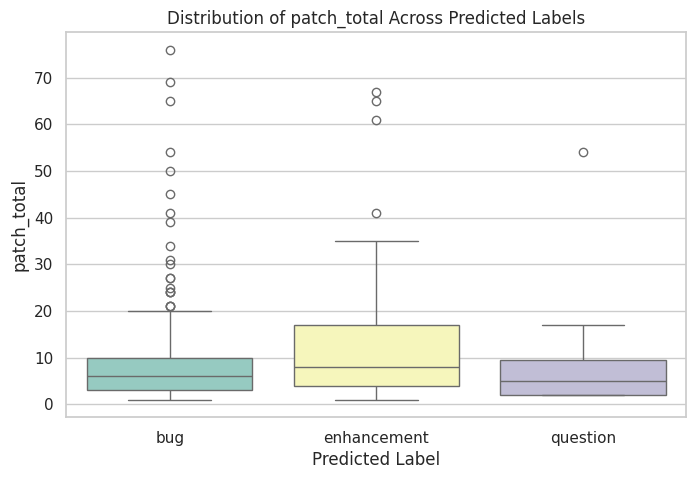

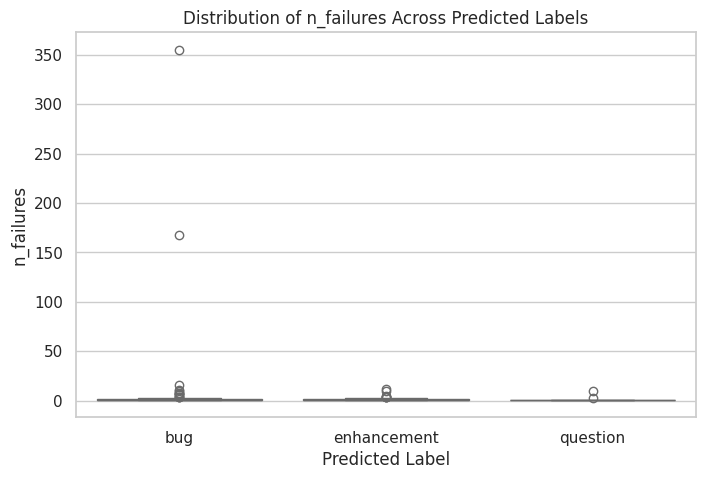

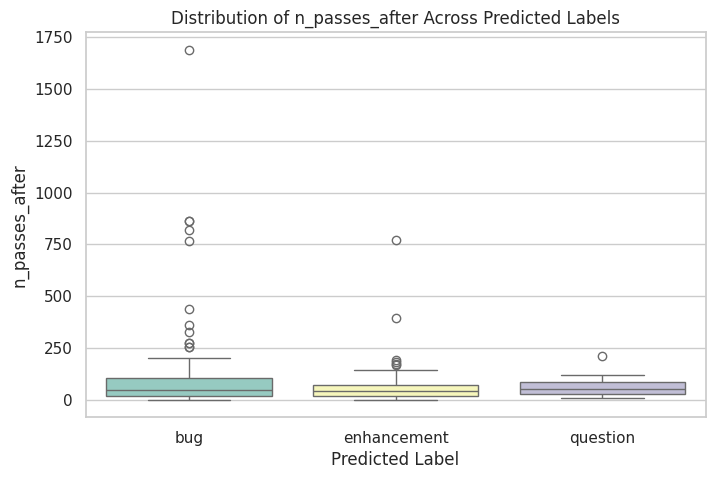

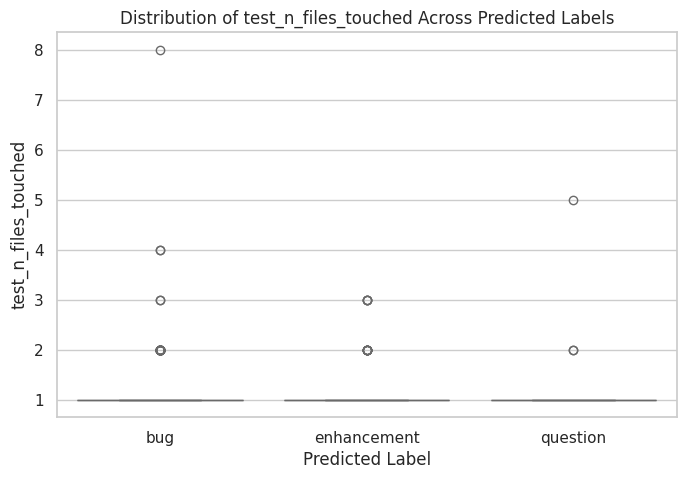

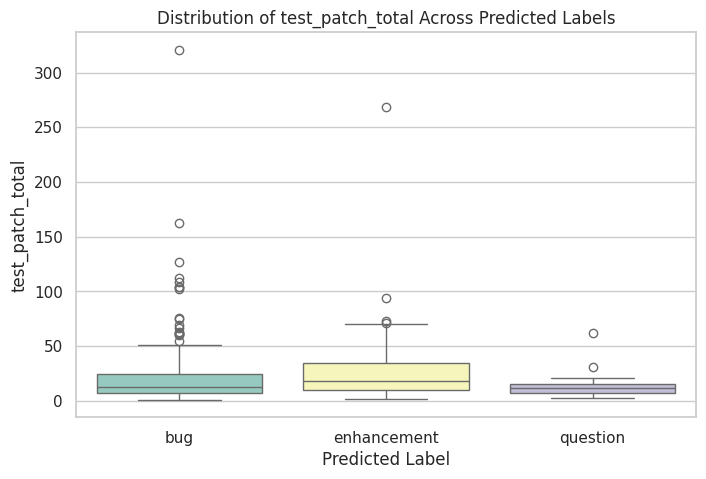

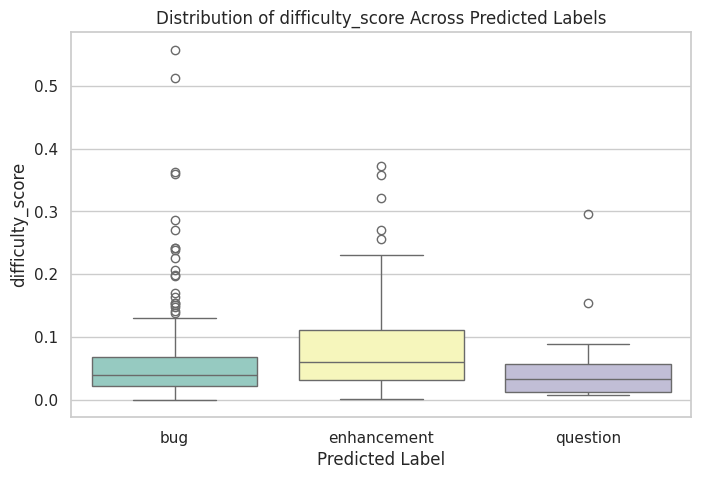

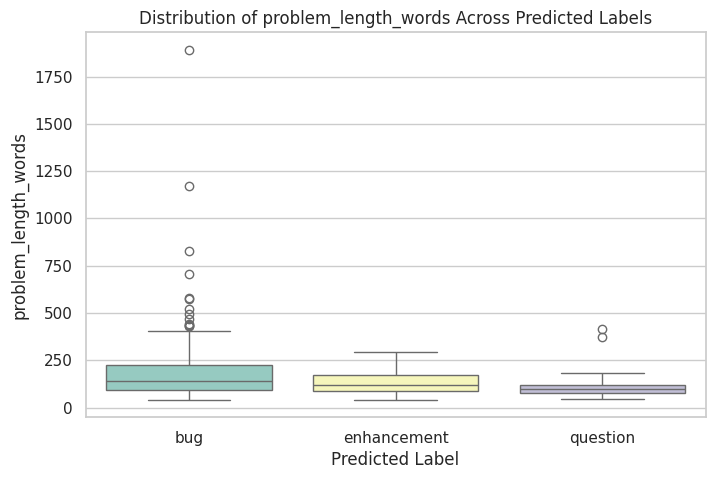

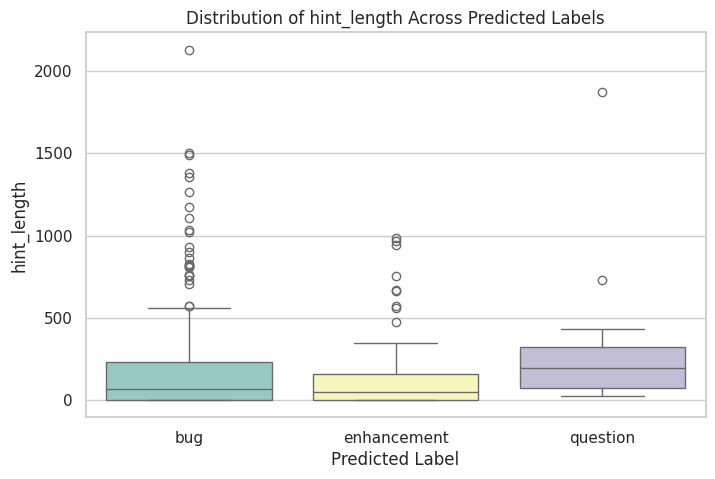

In [ ]:
features = ['version', 'patch_total', 'n_failures', 'n_passes_after', 'test_n_files_touched',
            'test_patch_total', 'difficulty_score', 'problem_length_words', 'hint_length']

for feature in features:
    plt.figure(figsize=(8,5))
    sns.boxplot(x="predicted_label_str", y=feature, data=df, palette="Set3")
    plt.title(f"Distribution of {feature} Across Predicted Labels")
    plt.xlabel("Predicted Label")
    plt.ylabel(feature)
    plt.show()


In [ ]:
df["has_hint_str"] = df["has_hint"].map({0: False, 1: True})

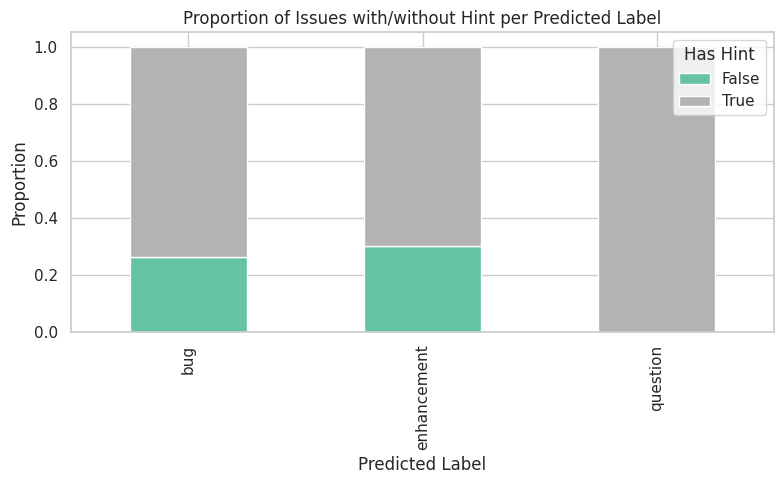

In [ ]:
import matplotlib.pyplot as plt



# Compute counts
hint_counts = df.groupby(["predicted_label_str", "has_hint_str"]).size().unstack(fill_value=0)


hint_prop = hint_counts.div(hint_counts.sum(axis=1), axis=0)
hint_prop.plot(kind="bar", stacked=True, figsize=(8,5), colormap="Set2")
plt.title("Proportion of Issues with/without Hint per Predicted Label")
plt.ylabel("Proportion")
plt.xlabel("Predicted Label")
plt.legend(title="Has Hint")
plt.tight_layout()
plt.savefig(analysis_path + "hint_distribution_across_GH_labels.pdf")
plt.show()



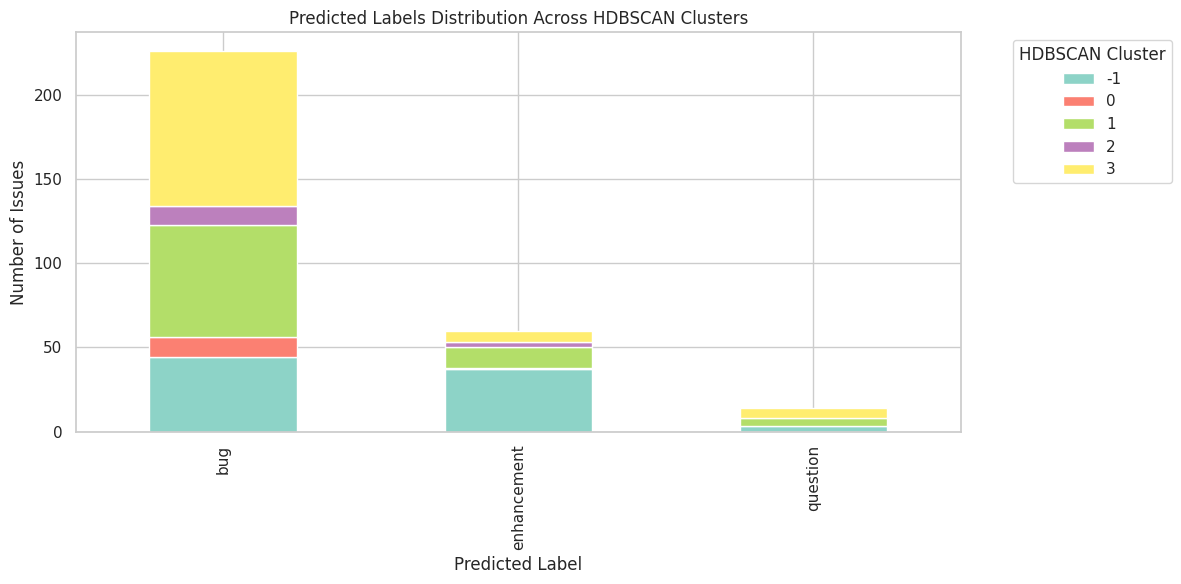

In [ ]:
# Compute counts
cluster_counts = df.groupby(["predicted_label_str", "hdbscan_cluster"]).size().unstack(fill_value=0)

# Plot stacked bar
cluster_counts.plot(kind="bar", stacked=True, figsize=(12,6), colormap="Set3")
plt.title("Predicted Labels Distribution Across HDBSCAN Clusters")
plt.xlabel("Predicted Label")
plt.ylabel("Number of Issues")
plt.legend(title="HDBSCAN Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


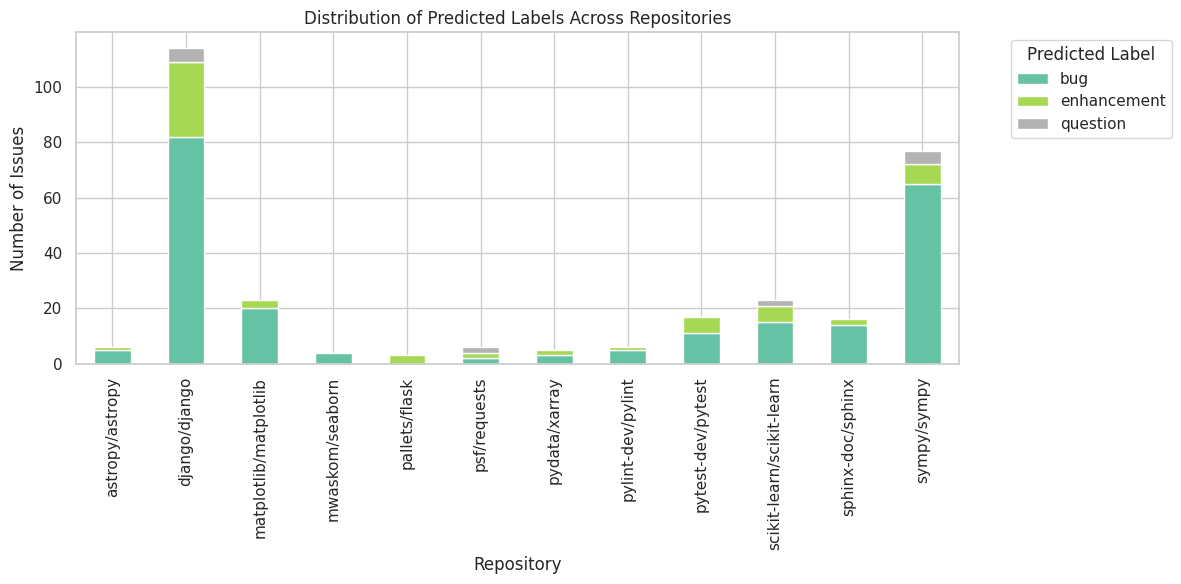

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute counts
label_repo_counts = df.groupby(["repo", "predicted_label_str"]).size().unstack(fill_value=0)

# Plot stacked bar
label_repo_counts.plot(kind="bar", stacked=True, figsize=(12,6), colormap="Set2")
plt.title("Distribution of Predicted Labels Across Repositories")
plt.xlabel("Repository")
plt.ylabel("Number of Issues")
plt.legend(title="Predicted Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(analysis_path + "label_distribution_across_repos.pdf")
plt.show()


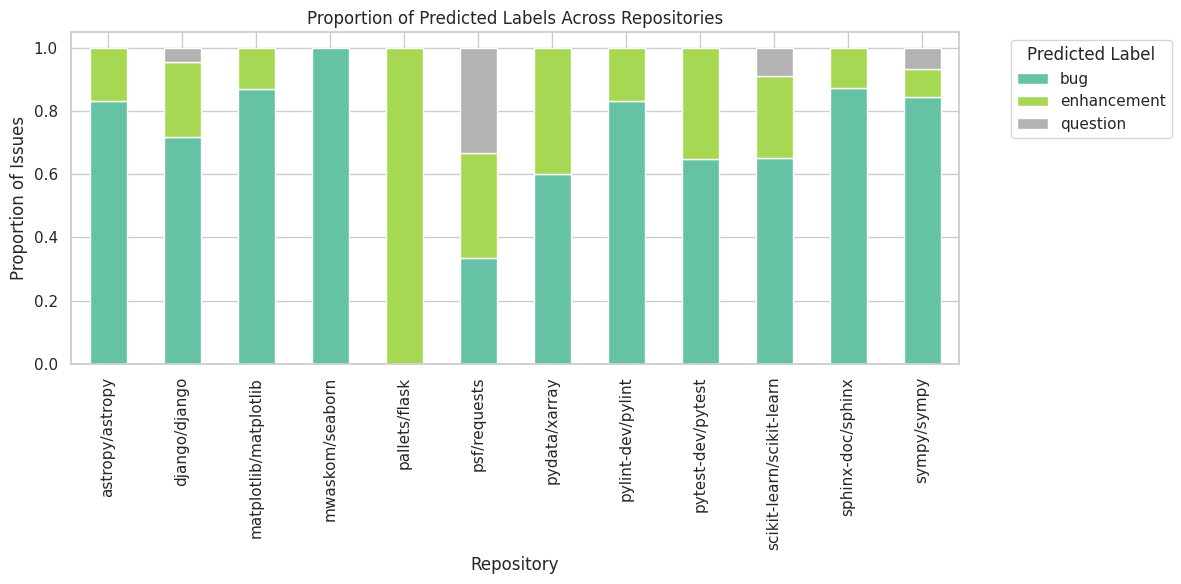

In [ ]:
# Normalize to proportions
label_repo_prop = label_repo_counts.div(label_repo_counts.sum(axis=1), axis=0)

label_repo_prop.plot(kind="bar", stacked=True, figsize=(12,6), colormap="Set2")
plt.title("Proportion of Predicted Labels Across Repositories")
plt.xlabel("Repository")
plt.ylabel("Proportion of Issues")
plt.legend(title="Predicted Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(analysis_path + "label_proportion_across_repos_normal.pdf")
plt.show()


#### patch_total

In [ ]:
# Select numeric columns only
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Calculate correlation with predicted_labels
corr_with_labels = df[numeric_cols].corr()["patch_total"].sort_values(ascending=False)

print("Correlation of numeric features with patch_total:")
print(corr_with_labels)


Correlation of numeric features with patch_total:
patch_total             1.000000
difficulty_score        0.950901
test_patch_total        0.397118
hint_length             0.144806
test_n_files_touched    0.130382
predicted_labels        0.099913
bert_topic              0.065163
lda_topic               0.020577
n_failures             -0.004359
n_passes_after         -0.023427
version                -0.032137
problem_length_words   -0.045371
hdbscan_cluster        -0.053594
kmeans_cluster         -0.057761
has_hint               -0.090317
Name: patch_total, dtype: float64


higher correaltion:

difficulty_score        0.950901

test_patch_total        0.397118

hint_length             0.144806

test_n_files_touched    0.130382

In [ ]:
len(set(list(df["patch_total"])))

40

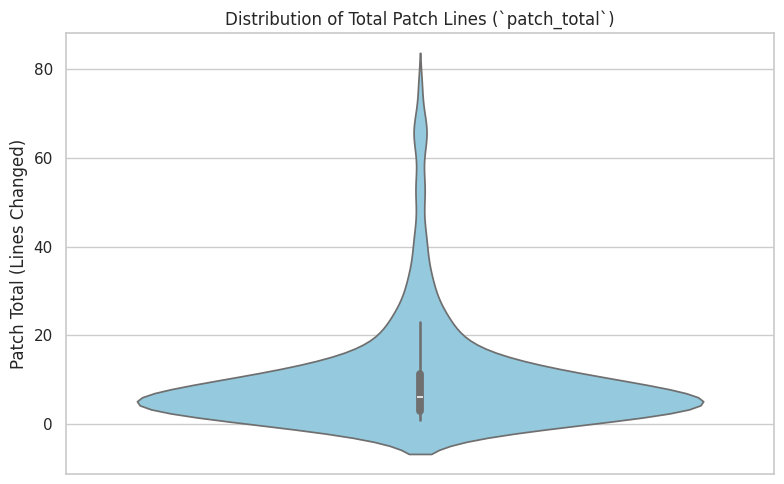

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.violinplot(y="patch_total", data=df, color="skyblue")
plt.title("Distribution of Total Patch Lines (`patch_total`)")
plt.ylabel("Patch Total (Lines Changed)")
plt.tight_layout()
plt.show()


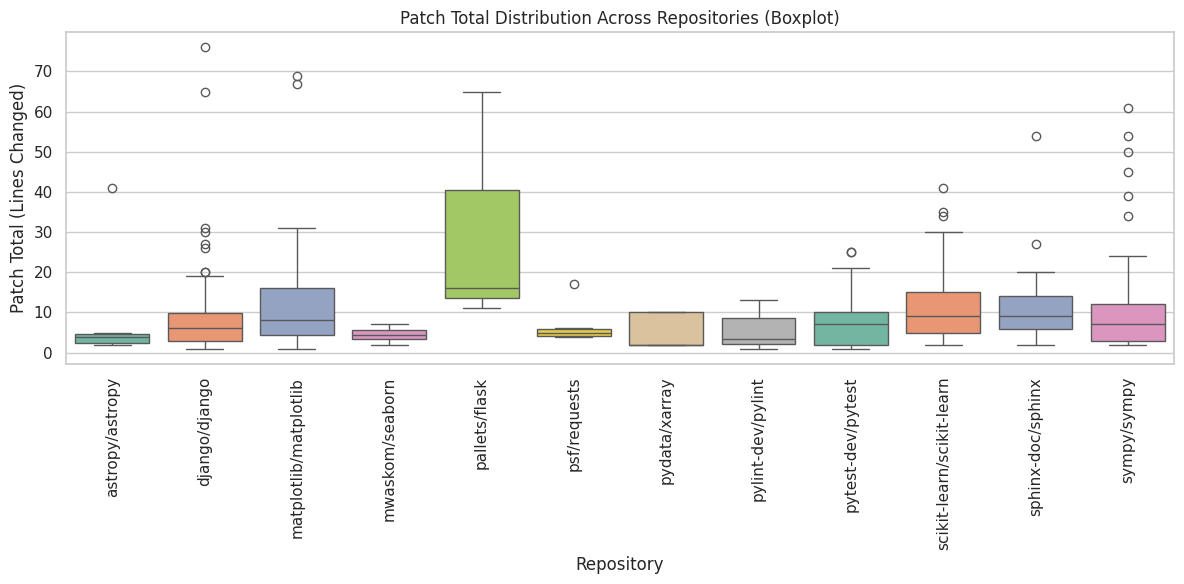

In [ ]:


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.boxplot(x="repo", y="patch_total", data=df, palette="Set2")
# plt.xticks(rotation=45)
plt.title("Patch Total Distribution Across Repositories (Boxplot)")
plt.xlabel("Repository")
plt.ylabel("Patch Total (Lines Changed)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(analysis_path + "patch_total_distribution_across_repos.pdf")
plt.show()



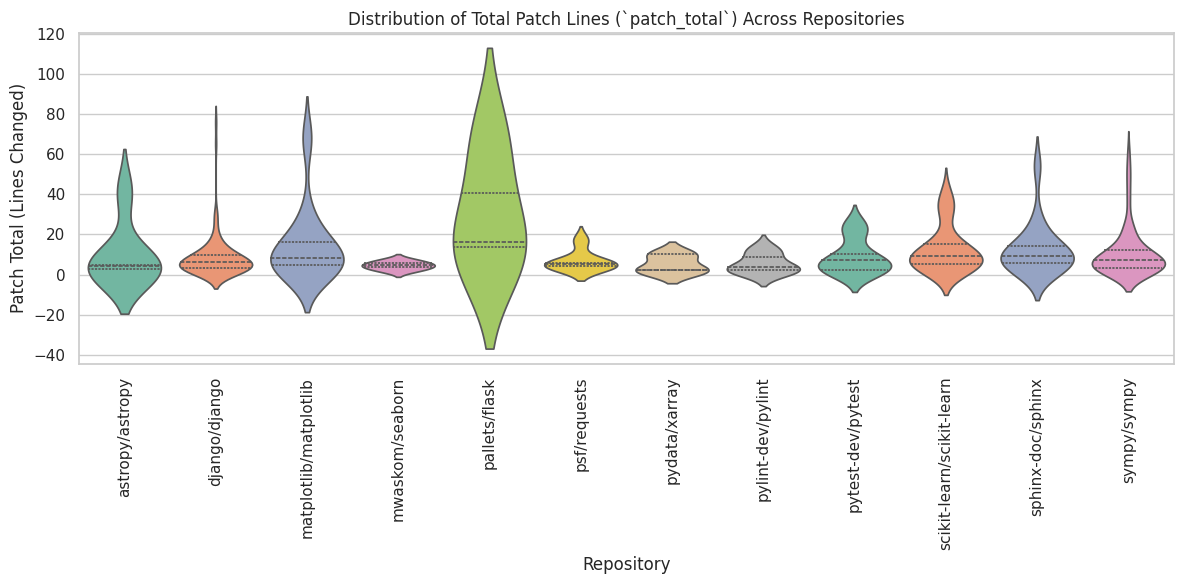

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.violinplot(x="repo", y="patch_total", data=df, palette="Set2", inner="quartile")
plt.title("Distribution of Total Patch Lines (`patch_total`) Across Repositories")
plt.xlabel("Repository")
plt.ylabel("Patch Total (Lines Changed)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


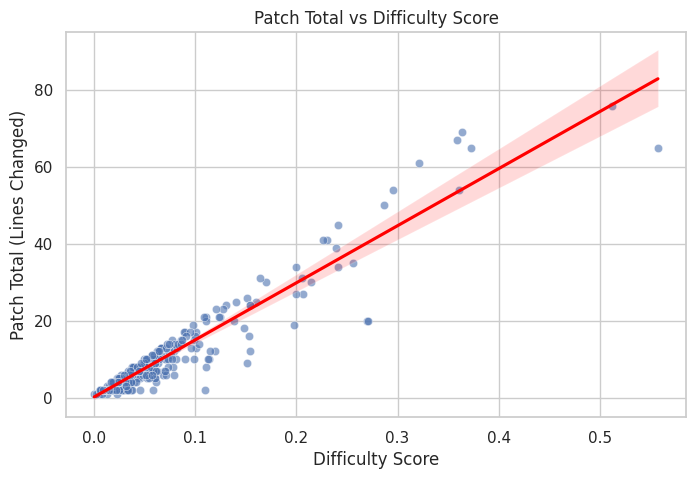

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.scatterplot(x="difficulty_score", y="patch_total", data=df, alpha=0.6)
sns.regplot(x="difficulty_score", y="patch_total", data=df, scatter=False, color="red")
plt.title("Patch Total vs Difficulty Score")
plt.xlabel("Difficulty Score")
plt.ylabel("Patch Total (Lines Changed)")
plt.savefig(analysis_path + "patch_total_vs_difficulty_score.pdf")
plt.show()


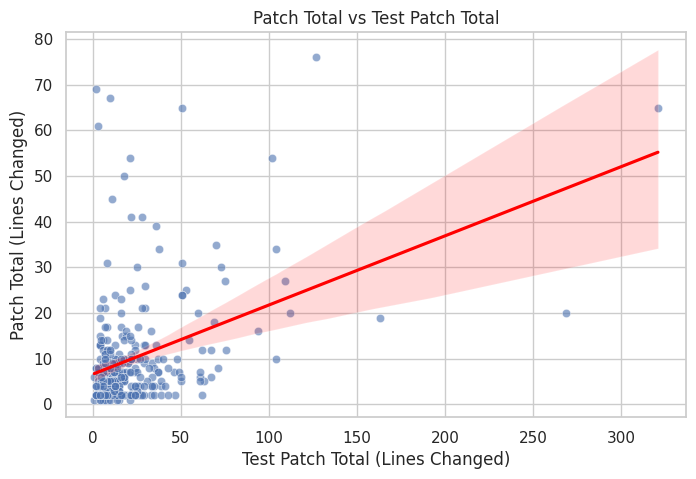

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="test_patch_total", y="patch_total", data=df, alpha=0.6)
sns.regplot(x="test_patch_total", y="patch_total", data=df, scatter=False, color="red")
plt.title("Patch Total vs Test Patch Total")
plt.xlabel("Test Patch Total (Lines Changed)")
plt.ylabel("Patch Total (Lines Changed)")
plt.savefig(analysis_path + "patch_total_vs_test_patch_total.pdf")
plt.show()


In [ ]:
df.head()

repo             instance_id  version  predicted_labels  \
0  astropy/astropy  astropy__astropy-12907      4.3                 0   
1  astropy/astropy  astropy__astropy-14182      5.1                 1   
2  astropy/astropy  astropy__astropy-14365      5.1                 0   
3  astropy/astropy  astropy__astropy-14995      5.2                 0   
4  astropy/astropy   astropy__astropy-6938      1.3                 0   

   bert_topic  lda_topic  kmeans_cluster  hdbscan_cluster  patch_total  \
0           4         11               2               -1            2   
1           4          5               5               -1           41   
2           0          5               7               -1            4   
3           4          5               2                3            4   
4           1          9               2               -1            2   

   n_failures  n_passes_after  test_n_files_touched  test_patch_total  \
0           2              13                     1                19   
1           1               9                     1                28   
2           1               8                     1                15   
3           1             179                     1                39   
4           2              11                     2                17   

   difficulty_score  problem_length_words  has_hint  hint_length  \
0          0.016866                   158         0            0   
1          0.230208                   189         0            0   
2          0.024750                   202         1          206   
3          0.039750                   357         1          808   
4          0.029902                    76         1           55   

  predicted_label_str  has_hint_str  
0                 bug         False  
1         enhancement         False  
2                 bug          True  
3                 bug          True  
4                 bug          True

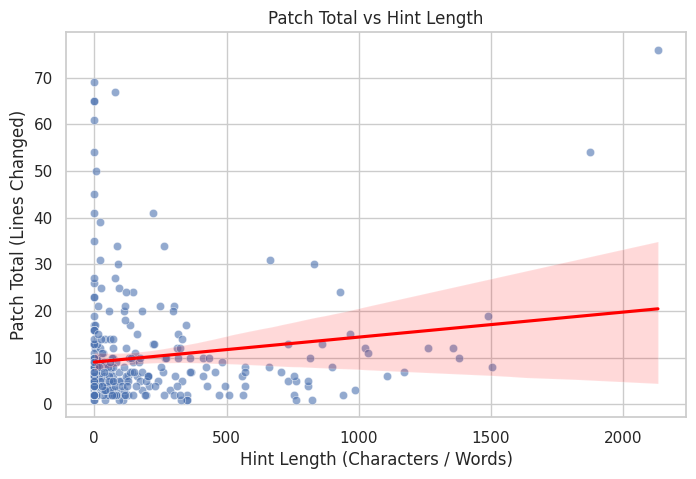

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="hint_length", y="patch_total", data=df, alpha=0.6)
sns.regplot(x="hint_length", y="patch_total", data=df, scatter=False, color="red")
plt.title("Patch Total vs Hint Length")
plt.xlabel("Hint Length (Characters / Words)")
plt.ylabel("Patch Total (Lines Changed)")
plt.show()


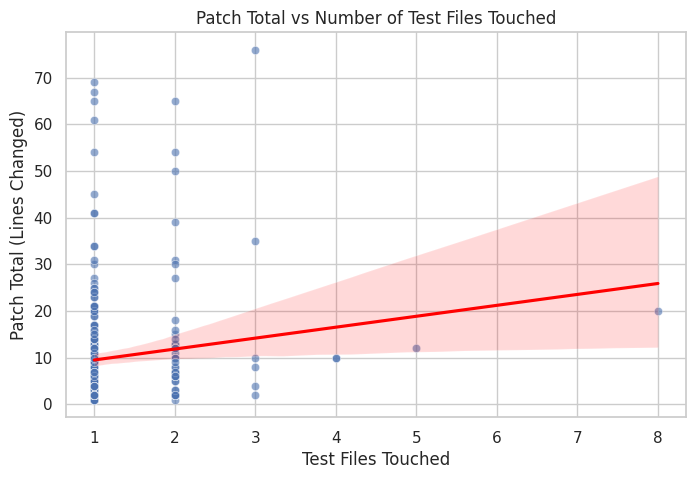

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="test_n_files_touched", y="patch_total", data=df, alpha=0.6)
sns.regplot(x="test_n_files_touched", y="patch_total", data=df, scatter=False, color="red")
plt.title("Patch Total vs Number of Test Files Touched")
plt.xlabel("Test Files Touched")
plt.ylabel("Patch Total (Lines Changed)")
plt.show()


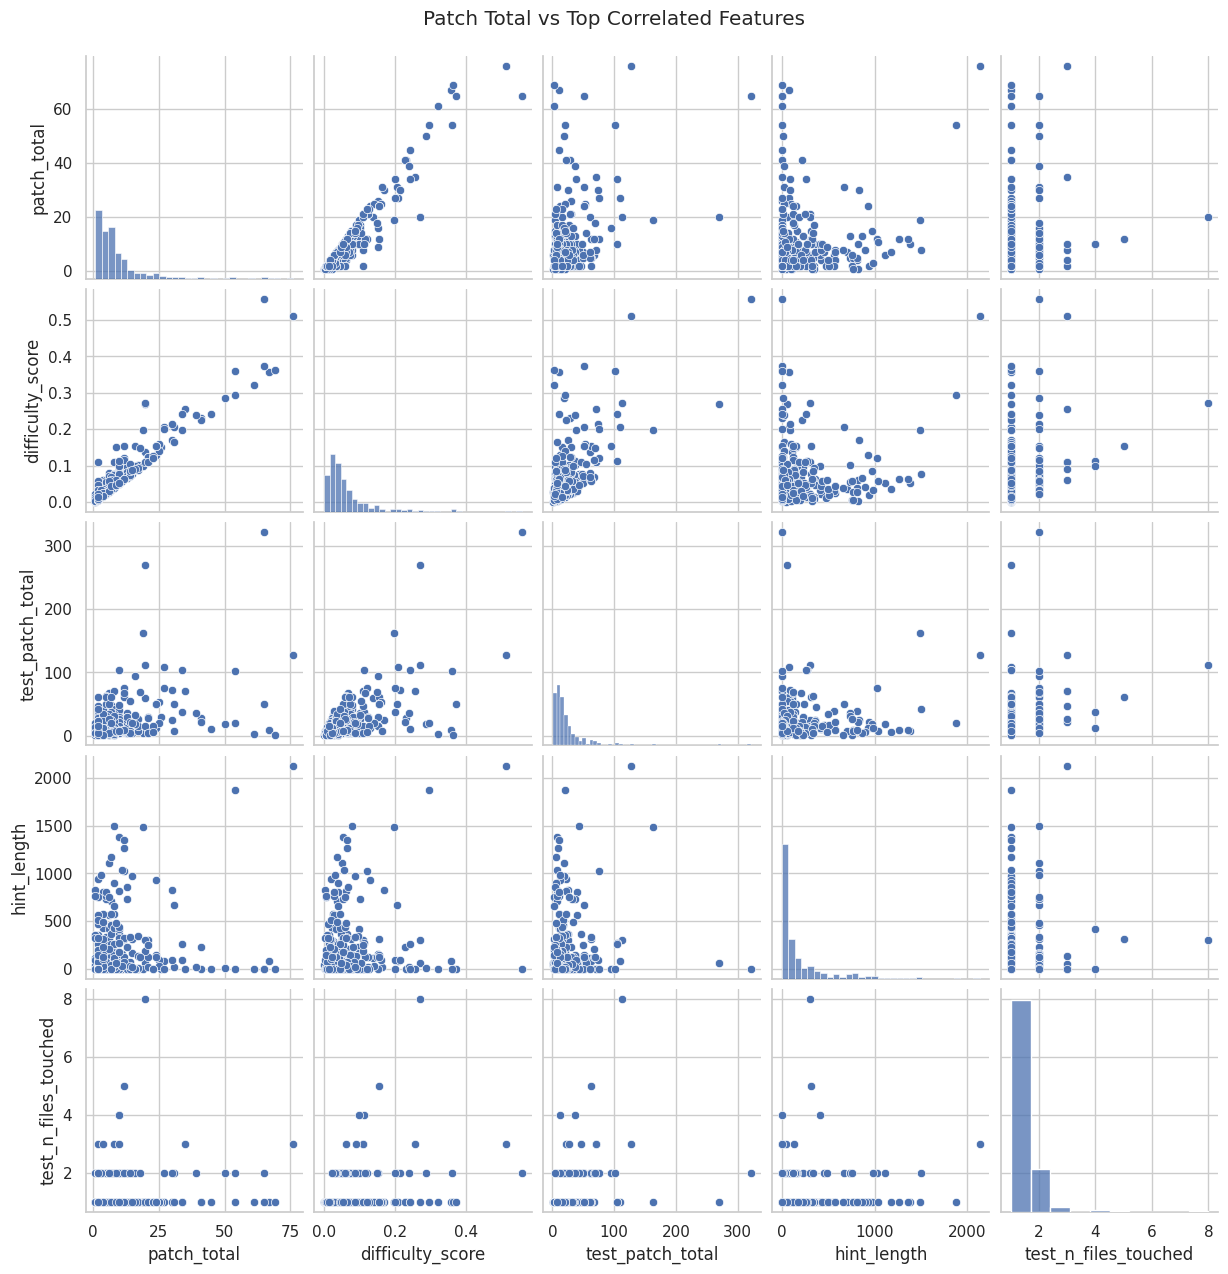

In [ ]:
sns.pairplot(df[["patch_total","difficulty_score","test_patch_total","hint_length","test_n_files_touched"]])
plt.suptitle("Patch Total vs Top Correlated Features", y=1.02)
plt.show()


#### n_failures

In [ ]:
len(set(list(df["n_failures"])))

14

In [ ]:
(set(list(df["n_failures"])))

{1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 16, 168, 355}

In [ ]:
# Select numeric columns only
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Calculate correlation with predicted_labels
corr_with_labels = df[numeric_cols].corr()["n_failures"].sort_values(ascending=False)

print("Correlation of numeric features with n_failures:")
print(corr_with_labels)


Correlation of numeric features with n_failures:
n_failures              1.000000
problem_length_words    0.114153
difficulty_score        0.092248
test_n_files_touched    0.052891
version                 0.032455
kmeans_cluster          0.031522
test_patch_total        0.027120
patch_total            -0.004359
has_hint               -0.008824
hint_length            -0.013866
hdbscan_cluster        -0.018107
predicted_labels       -0.036424
n_passes_after         -0.040960
bert_topic             -0.050757
lda_topic              -0.118301
Name: n_failures, dtype: float64


problem_length_words    0.114153

lda_topic              -0.118301

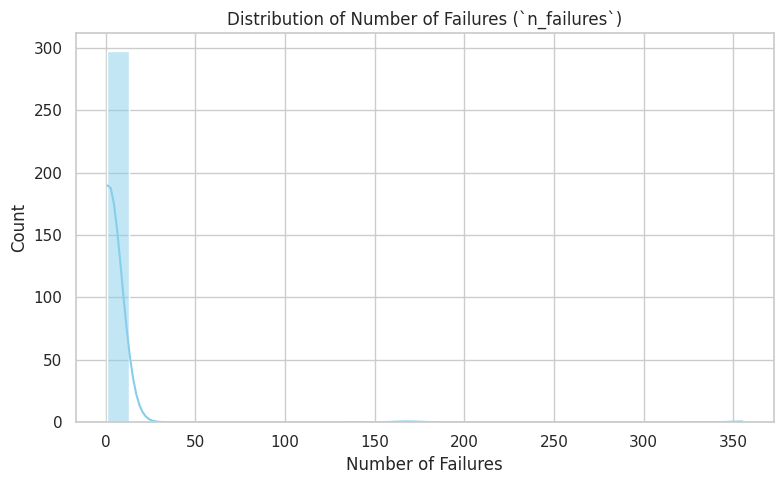

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df["n_failures"], bins=30, kde=True, color="skyblue")
plt.title("Distribution of Number of Failures (`n_failures`)")
plt.xlabel("Number of Failures")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


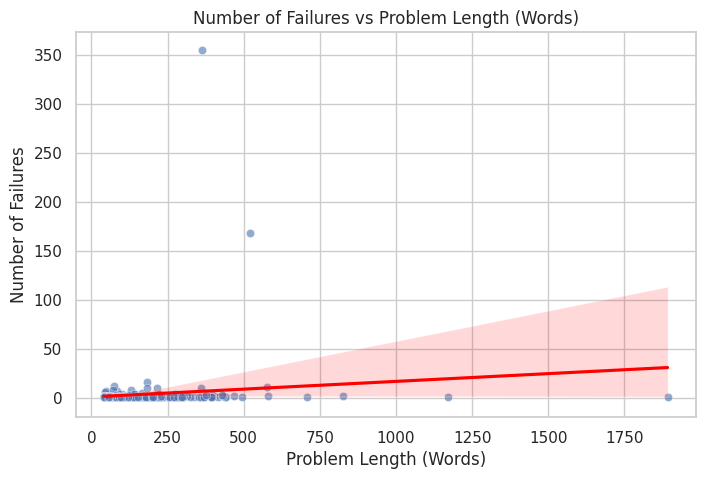

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="problem_length_words", y="n_failures", data=df, alpha=0.6)
sns.regplot(x="problem_length_words", y="n_failures", data=df, scatter=False, color="red")
plt.title("Number of Failures vs Problem Length (Words)")
plt.xlabel("Problem Length (Words)")
plt.ylabel("Number of Failures")
plt.show()


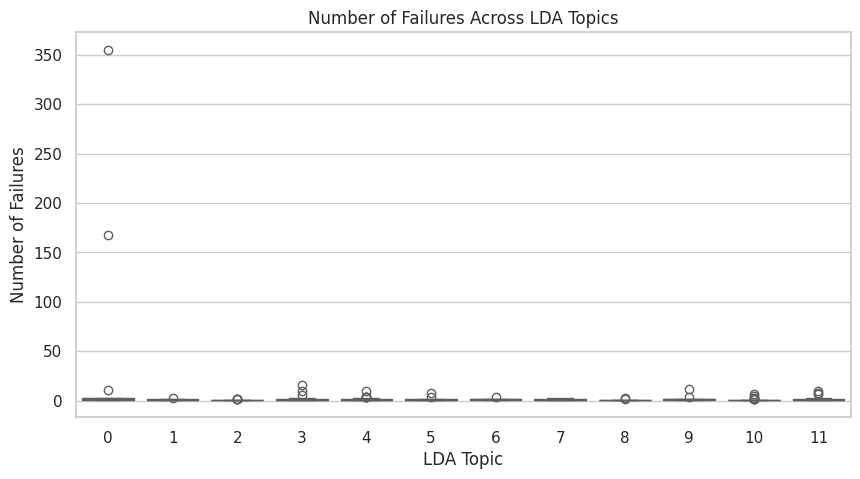

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(x="lda_topic", y="n_failures", data=df, palette="Set3")
plt.title("Number of Failures Across LDA Topics")
plt.xlabel("LDA Topic")
plt.ylabel("Number of Failures")
plt.show()


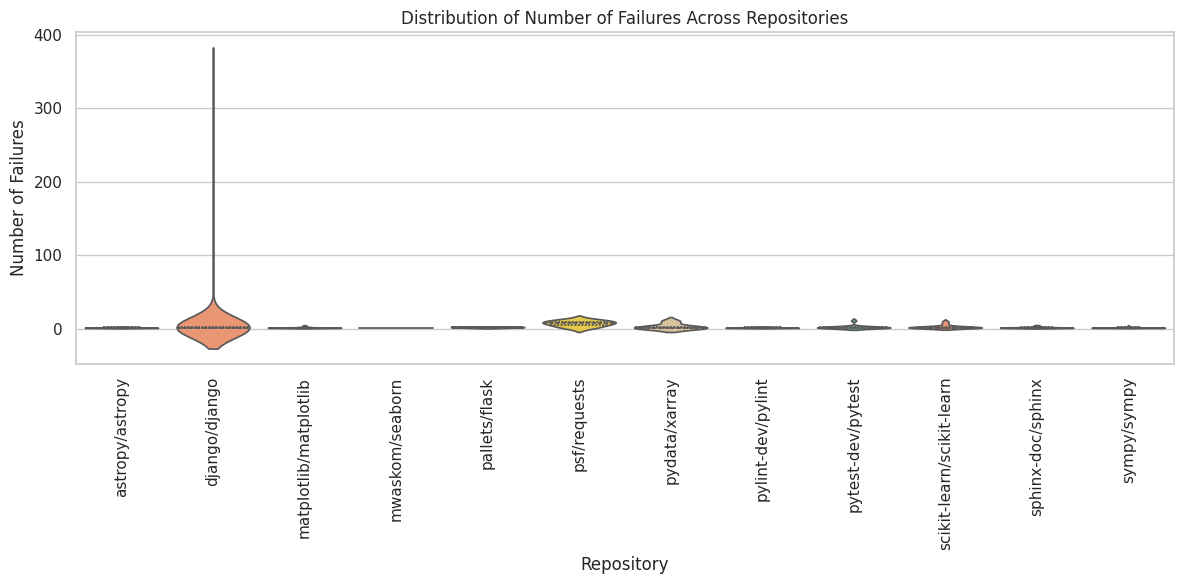

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.violinplot(x="repo", y="n_failures", data=df, palette="Set2", inner="quartile")
plt.title("Distribution of Number of Failures Across Repositories")
plt.xlabel("Repository")
plt.ylabel("Number of Failures")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(analysis_path + "n_failures_distribution_across_repos_violin.pdf")
plt.show()


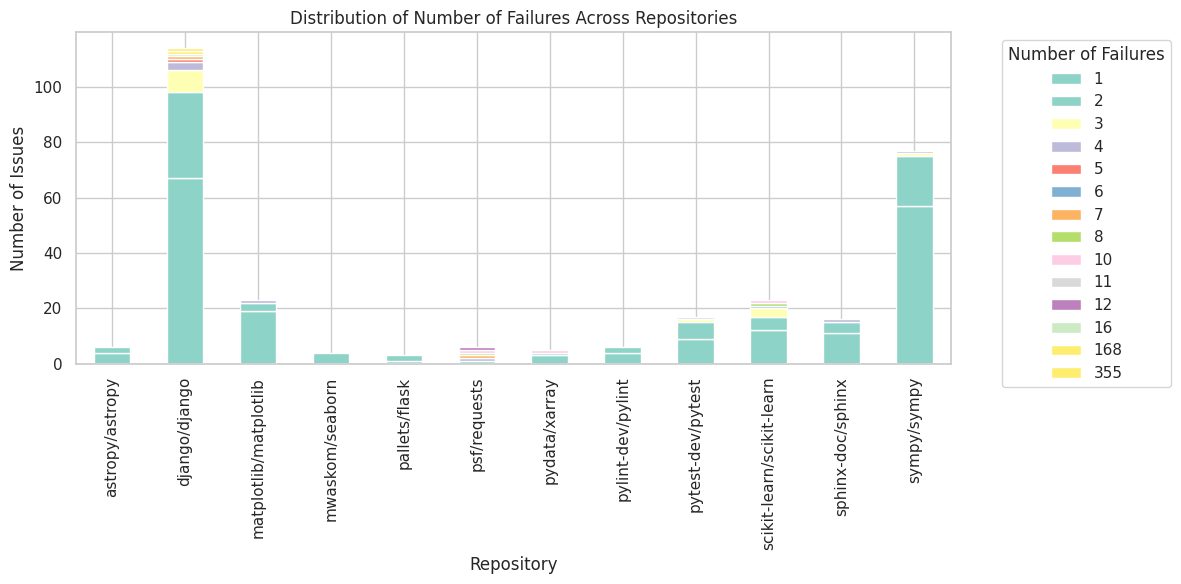

In [ ]:
import matplotlib.pyplot as plt

# Compute counts per repo and n_failures
failure_counts = df.groupby(["repo", "n_failures"]).size().unstack(fill_value=0)

# Plot stacked bar
ax = failure_counts.plot(kind="bar", stacked=True, figsize=(12,6), colormap="Set3")

plt.title("Distribution of Number of Failures Across Repositories")
plt.xlabel("Repository")
plt.ylabel("Number of Issues")
plt.xticks(rotation=90)

# Move legend to the right side
plt.legend(title="Number of Failures", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(analysis_path + "n_failures_distribution_across_repos_bar.pdf")
plt.show()


# Clustering

In [ ]:
import pandas as pd

analysis_path = "/content/drive/MyDrive/EECS6444/RQ1/Analysis/"
df=pd.read_csv(analysis_path + "final_csv.csv")
df["has_hint"] = df["has_hint"].astype(int)
df.head()

repo             instance_id  \
0  astropy/astropy  astropy__astropy-12907   
1  astropy/astropy  astropy__astropy-14182   
2  astropy/astropy  astropy__astropy-14365   
3  astropy/astropy  astropy__astropy-14995   
4  astropy/astropy   astropy__astropy-6938   

                                base_commit  \
0  d16bfe05a744909de4b27f5875fe0d4ed41ce607   
1  a5917978be39d13cd90b517e1de4e7a539ffaa48   
2  7269fa3e33e8d02485a647da91a5a2a60a06af61   
3  b16c7d12ccbc7b2d20364b89fb44285bcbfede54   
4  c76af9ed6bb89bfba45b9f5bc1e635188278e2fa   

                                               patch  \
0  diff --git a/astropy/modeling/separable.py b/a...   
1  diff --git a/astropy/io/ascii/rst.py b/astropy...   
2  diff --git a/astropy/io/ascii/qdp.py b/astropy...   
3  diff --git a/astropy/nddata/mixins/ndarithmeti...   
4  diff --git a/astropy/io/fits/fitsrec.py b/astr...   

                                          test_patch  \
0  diff --git a/astropy/modeling/tests/test_separ...   
1  diff --git a/astropy/io/ascii/tests/test_rst.p...   
2  diff --git a/astropy/io/ascii/tests/test_qdp.p...   
3  diff --git a/astropy/nddata/mixins/tests/test_...   
4  diff --git a/astropy/io/fits/tests/test_checks...   

                                   problem_statement  \
0  Modeling's `separability_matrix` does not comp...   
1  Please support header rows in RestructuredText...   
2  ascii.qdp Table format assumes QDP commands ar...   
3  In v5.3, NDDataRef mask propagation fails when...   
4  Possible bug in io.fits related to D exponents...   

                                          hints_text            created_at  \
0                                                NaN  2022-03-03T15:14:54Z   
1                                                NaN  2022-12-16T11:13:37Z   
2  Welcome to Astropy 👋 and thank you for your fi...  2023-02-06T19:20:34Z   
3  Welcome to Astropy 👋 and thank you for your fi...  2023-06-27T19:48:18Z   
4  It is tested with `astropy/io/fits/tests/test_...  2017-12-07T00:01:14Z   

   version                                       FAIL_TO_PASS  ...  \
0      4.3  ["astropy/modeling/tests/test_separable.py::te...  ...   
1      5.1  ["astropy/io/ascii/tests/test_rst.py::test_rst...  ...   
2      5.1  ["astropy/io/ascii/tests/test_qdp.py::test_rou...  ...   
3      5.2  ["astropy/nddata/mixins/tests/test_ndarithmeti...  ...   
4      1.3  ["astropy/io/fits/tests/test_checksum.py::Test...  ...   

  test_patch_total has_test_patch has_patch  difficulty_score  \
0               19           True      True          0.016866   
1               28           True      True          0.230208   
2               15           True      True          0.024750   
3               39           True      True          0.039750   
4               17           True      True          0.029902   

                             problem_statement_clean  problem_length_words  \
0  Modeling's `separability_matrix` does not comp...                   158   
1  Please support header rows in RestructuredText...                   189   
2  ascii.qdp Table format assumes QDP commands ar...                   202   
3  In v5.3, NDDataRef mask propagation fails when...                   357   
4  Possible bug in io.fits related to D exponents...                    76   

   problem_length_chars                                   hints_text_clean  \
0                  1246                                                NaN   
1                  1871                                                NaN   
2                  1339  Welcome to Astropy 👋 and thank you for your fi...   
3                  2455  Welcome to Astropy 👋 and thank you for your fi...   
4                   527  It is tested with `astropy/io/fits/tests/test_...   

   has_hint  hint_length  
0         0            0  
1         0            0  
2         1          206  
3         1          808  
4         1           55  

[5 rows x 41 columns]

In [ ]:
print(df.columns.tolist())

['repo', 'instance_id', 'base_commit', 'patch', 'test_patch', 'problem_statement', 'hints_text', 'created_at', 'version', 'FAIL_TO_PASS', 'PASS_TO_PASS', 'environment_setup_commit', 'predicted_labels', 'predicted_scores', 'all_label_scores', 'bert_topic', 'lda_topic', 'text_clean', 'kmeans_cluster', 'hdbscan_cluster', 'umap_x', 'umap_y', 'n_files_touched', 'added_lines', 'removed_lines', 'patch_total', 'n_failures', 'n_passes_after', 'test_n_files_touched', 'test_added_lines', 'test_removed_lines', 'test_patch_total', 'has_test_patch', 'has_patch', 'difficulty_score', 'problem_statement_clean', 'problem_length_words', 'problem_length_chars', 'hints_text_clean', 'has_hint', 'hint_length']


In [ ]:
numeric_features = [
    'patch_total', 'n_failures', 'n_passes_after',
    'test_n_files_touched', 'test_added_lines', 'test_removed_lines', 'test_patch_total',
    'added_lines', 'removed_lines', 'n_files_touched',
    'difficulty_score', 'problem_length_words', 'has_hint', 'hint_length'
]


In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

X_numeric = df[numeric_features]
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)


In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
X_text = model.encode(df['problem_statement_clean'], convert_to_numpy=True)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
print(X_text.shape)


(300, 384)


In [ ]:
from sklearn.decomposition import PCA

# Suppose X_text is your BERT embeddings
# Reduce to 20 dimensions (adjustable)
pca_emb = PCA(n_components=0.9, random_state=42)
X_text_reduced = pca_emb.fit_transform(X_text)

# Optional: check variance explained
explained_variance = pca_emb.explained_variance_ratio_.sum()
print(f"Total variance retained in PCA-reduced embeddings: {explained_variance:.2f}")
X_text_reduced.shape

Total variance retained in PCA-reduced embeddings: 0.90


(300, 113)

In [ ]:
import numpy as np

# X_numeric_scaled: your scaled numeric features
X_combined = np.hstack([X_numeric_scaled, X_text_reduced])
X_combined.shape

(300, 127)

In [ ]:
from sklearn.decomposition import PCA

# Suppose X_text is your BERT embeddings
# Reduce to 20 dimensions (adjustable)
pca_emb = PCA(n_components=0.9, random_state=42)
X_combined = pca_emb.fit_transform(X_combined)

# Optional: check variance explained
explained_variance = pca_emb.explained_variance_ratio_.sum()
print(f"Total variance retained in PCA-reduced embeddings: {explained_variance:.2f}")
X_combined.shape

Total variance retained in PCA-reduced embeddings: 0.92


(300, 9)

In [ ]:
## No PCA
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=2)
df['hdbscan_cluster_new'] = clusterer.fit_predict(X_combined)


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
df['hdbscan_cluster_new'].value_counts()


hdbscan_cluster_new
 5    153
-1     59
 2     53
 7     16
 1      8
 0      4
 6      3
 3      2
 4      2
Name: count, dtype: int64

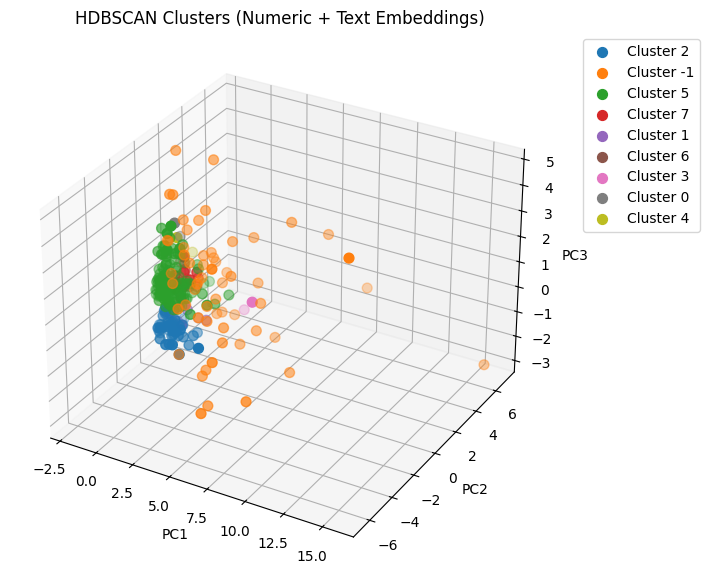

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(X_combined)

pca_df = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])
pca_df['cluster'] = df['hdbscan_cluster_new']

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
unique_clusters = pca_df['cluster'].unique()
palette = sns.color_palette('tab10', n_colors=len(unique_clusters))

for i, cluster in enumerate(unique_clusters):
    points = pca_df[pca_df['cluster'] == cluster]
    ax.scatter(points['PC1'], points['PC2'], points['PC3'], s=50, color=palette[i], label=f'Cluster {cluster}')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('HDBSCAN Clusters (Numeric + Text Embeddings)')
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()


In [ ]:
df.head()

repo             instance_id  \
0  astropy/astropy  astropy__astropy-12907   
1  astropy/astropy  astropy__astropy-14182   
2  astropy/astropy  astropy__astropy-14365   
3  astropy/astropy  astropy__astropy-14995   
4  astropy/astropy   astropy__astropy-6938   

                                base_commit  \
0  d16bfe05a744909de4b27f5875fe0d4ed41ce607   
1  a5917978be39d13cd90b517e1de4e7a539ffaa48   
2  7269fa3e33e8d02485a647da91a5a2a60a06af61   
3  b16c7d12ccbc7b2d20364b89fb44285bcbfede54   
4  c76af9ed6bb89bfba45b9f5bc1e635188278e2fa   

                                               patch  \
0  diff --git a/astropy/modeling/separable.py b/a...   
1  diff --git a/astropy/io/ascii/rst.py b/astropy...   
2  diff --git a/astropy/io/ascii/qdp.py b/astropy...   
3  diff --git a/astropy/nddata/mixins/ndarithmeti...   
4  diff --git a/astropy/io/fits/fitsrec.py b/astr...   

                                          test_patch  \
0  diff --git a/astropy/modeling/tests/test_separ...   
1  diff --git a/astropy/io/ascii/tests/test_rst.p...   
2  diff --git a/astropy/io/ascii/tests/test_qdp.p...   
3  diff --git a/astropy/nddata/mixins/tests/test_...   
4  diff --git a/astropy/io/fits/tests/test_checks...   

                                   problem_statement  \
0  Modeling's `separability_matrix` does not comp...   
1  Please support header rows in RestructuredText...   
2  ascii.qdp Table format assumes QDP commands ar...   
3  In v5.3, NDDataRef mask propagation fails when...   
4  Possible bug in io.fits related to D exponents...   

                                          hints_text            created_at  \
0                                                NaN  2022-03-03T15:14:54Z   
1                                                NaN  2022-12-16T11:13:37Z   
2  Welcome to Astropy 👋 and thank you for your fi...  2023-02-06T19:20:34Z   
3  Welcome to Astropy 👋 and thank you for your fi...  2023-06-27T19:48:18Z   
4  It is tested with `astropy/io/fits/tests/test_...  2017-12-07T00:01:14Z   

   version                                       FAIL_TO_PASS  ...  \
0      4.3  ["astropy/modeling/tests/test_separable.py::te...  ...   
1      5.1  ["astropy/io/ascii/tests/test_rst.py::test_rst...  ...   
2      5.1  ["astropy/io/ascii/tests/test_qdp.py::test_rou...  ...   
3      5.2  ["astropy/nddata/mixins/tests/test_ndarithmeti...  ...   
4      1.3  ["astropy/io/fits/tests/test_checksum.py::Test...  ...   

  has_test_patch has_patch difficulty_score  \
0           True      True         0.016866   
1           True      True         0.230208   
2           True      True         0.024750   
3           True      True         0.039750   
4           True      True         0.029902   

                             problem_statement_clean problem_length_words  \
0  Modeling's `separability_matrix` does not comp...                  158   
1  Please support header rows in RestructuredText...                  189   
2  ascii.qdp Table format assumes QDP commands ar...                  202   
3  In v5.3, NDDataRef mask propagation fails when...                  357   
4  Possible bug in io.fits related to D exponents...                   76   

   problem_length_chars                                   hints_text_clean  \
0                  1246                                                NaN   
1                  1871                                                NaN   
2                  1339  Welcome to Astropy 👋 and thank you for your fi...   
3                  2455  Welcome to Astropy 👋 and thank you for your fi...   
4                   527  It is tested with `astropy/io/fits/tests/test_...   

  has_hint  hint_length  hdbscan_cluster_new  
0        0            0                    2  
1        0            0                   -1  
2        1          206                    5  
3        1          808                   -1  
4        1           55                    7  

[5 rows x 42 columns]

## Cluster analysis

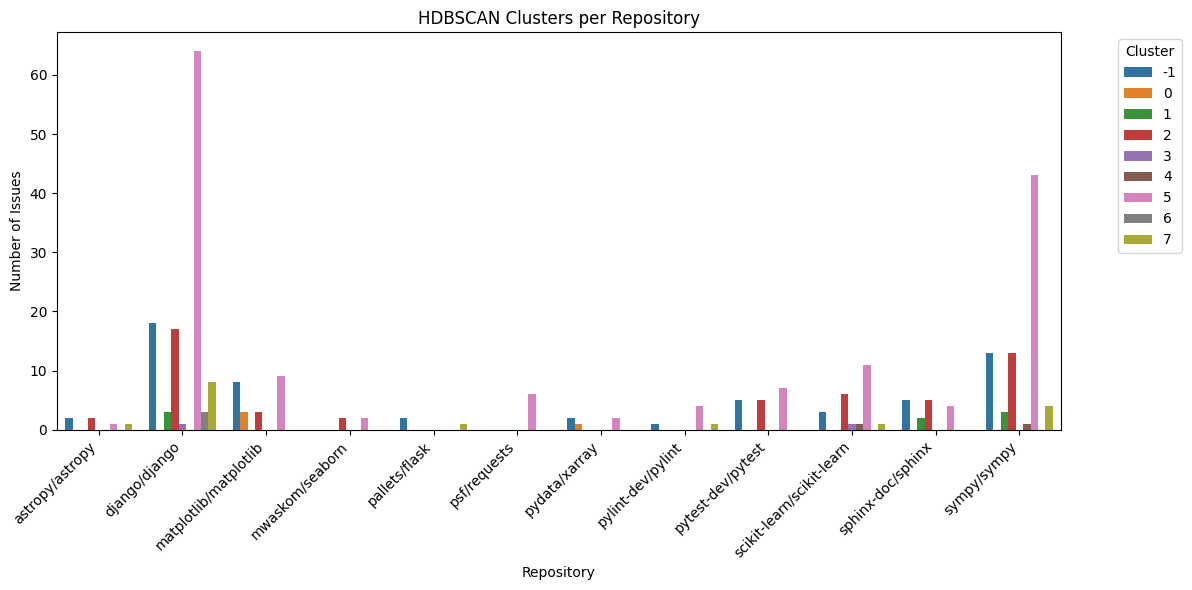

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count clusters per repo
cluster_repo_counts = df.groupby(['repo', 'hdbscan_cluster_new']).size().reset_index(name='count')

plt.figure(figsize=(12,6))
sns.barplot(x='repo', y='count', hue='hdbscan_cluster_new', data=cluster_repo_counts, palette='tab10')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Repository')
plt.ylabel('Number of Issues')
plt.title('HDBSCAN Clusters per Repository')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


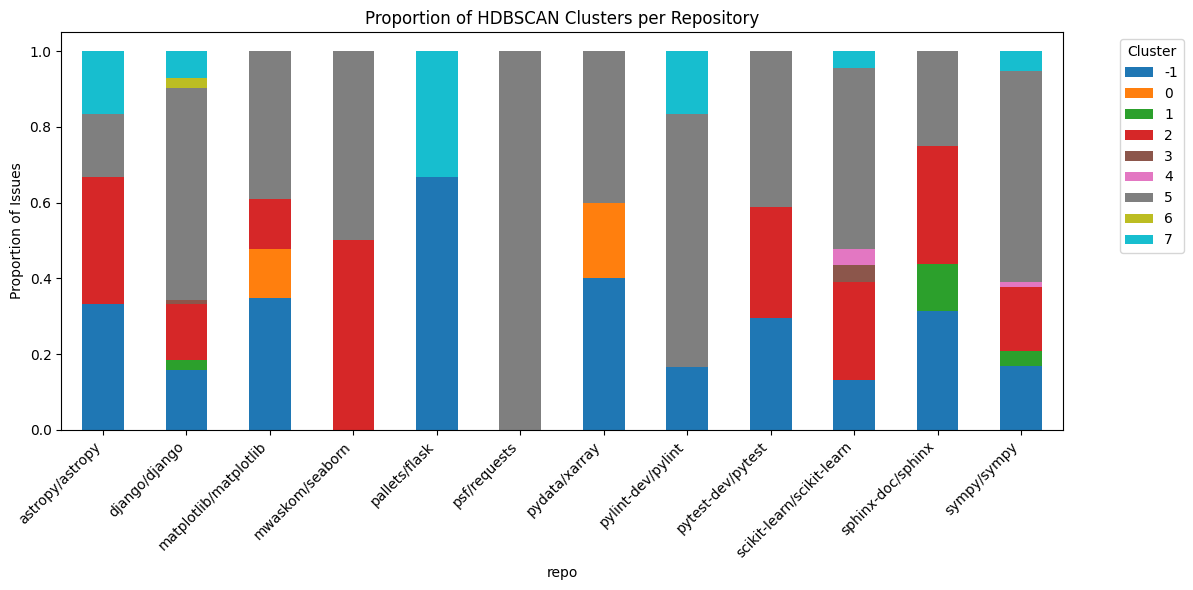

In [ ]:
# Create pivot table for proportions
pivot = cluster_repo_counts.pivot(index='repo', columns='hdbscan_cluster_new', values='count').fillna(0)
pivot_prop = pivot.div(pivot.sum(axis=1), axis=0)  # convert to proportion

pivot_prop.plot(kind='bar', stacked=True, figsize=(12,6), colormap='tab10')
plt.ylabel('Proportion of Issues')
plt.title('Proportion of HDBSCAN Clusters per Repository')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(analysis_path + "proportion_of_clusters_per_repo.pdf")
plt.show()


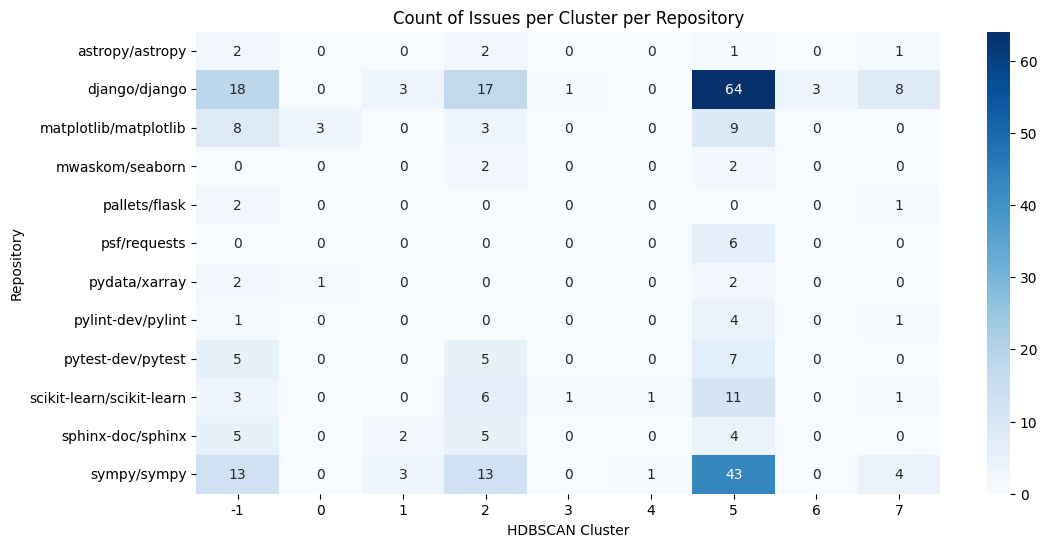

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(pivot, annot=True, fmt='g', cmap='Blues')
plt.xlabel('HDBSCAN Cluster')
plt.ylabel('Repository')
plt.title('Count of Issues per Cluster per Repository')
plt.show()


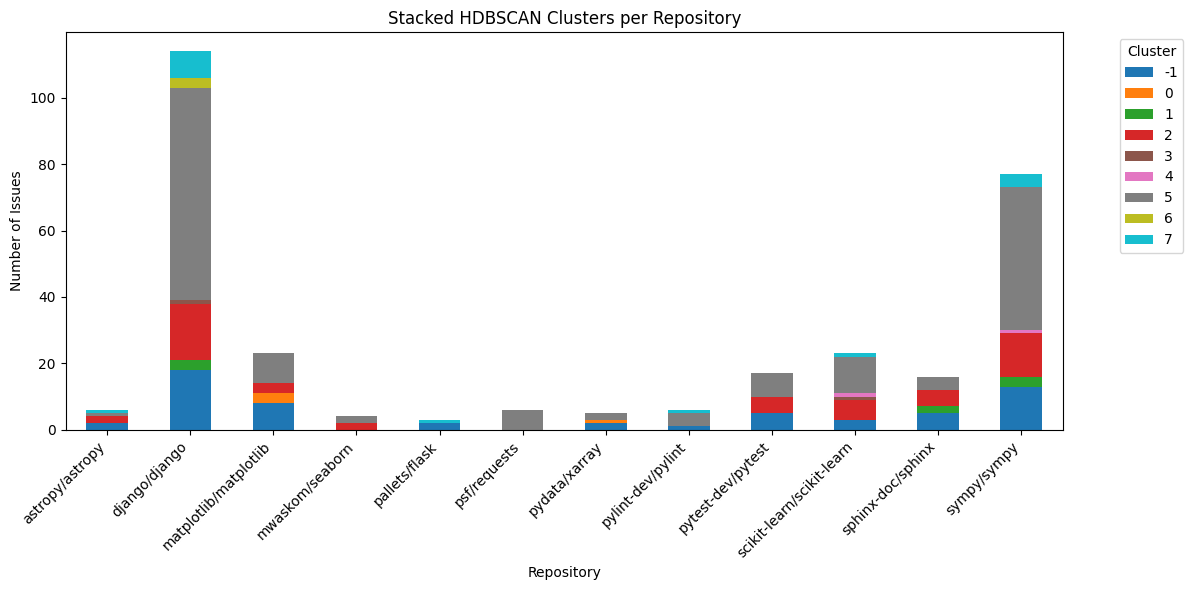

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Count clusters per repo
cluster_repo_counts = df.groupby(['repo', 'hdbscan_cluster_new']).size().reset_index(name='count')

# Pivot to have clusters as columns
pivot = cluster_repo_counts.pivot(index='repo', columns='hdbscan_cluster_new', values='count').fillna(0)

# Plot stacked bar
pivot.plot(kind='bar', stacked=True, figsize=(12,6), colormap='tab10')

plt.xlabel('Repository')
plt.ylabel('Number of Issues')
plt.title('Stacked HDBSCAN Clusters per Repository')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# List of numeric features to summarize
numeric_features = [
    'patch_total', 'n_failures', 'n_passes_after',
    'test_n_files_touched', 'test_added_lines', 'test_removed_lines', 'test_patch_total',
    'added_lines', 'removed_lines', 'n_files_touched',
    'difficulty_score', 'problem_length_words', 'problem_length_chars',
    'has_test_patch', 'has_patch', 'has_hint', 'hint_length'
]

# Compute mean and std per cluster
cluster_summary_numeric = df.groupby('hdbscan_cluster_new')[numeric_features].agg(['mean','std'])
cluster_summary_numeric.to_csv(analysis_path + 'cluster_summary_numeric.csv')
cluster_summary_numeric


patch_total            n_failures             \
                           mean        std       mean        std   
hdbscan_cluster_new                                                
-1                    23.694915  20.099112  10.966102  50.472583   
 0                     3.750000   2.872281   1.000000   0.000000   
 1                     2.875000   1.959410   1.500000   0.534522   
 2                     6.981132   5.789548   1.396226   0.884473   
 3                    28.500000   2.121320   3.000000   1.414214   
 4                     4.000000   1.414214   1.000000   0.000000   
 5                     6.686275   4.856453   1.745098   1.844371   
 6                     6.000000   1.000000   2.333333   1.527525   
 7                     7.937500   4.582121   1.312500   0.478714   

                    n_passes_after             test_n_files_touched            \
                              mean         std                 mean       std   
hdbscan_cluster_new                                                             
-1                      123.915254  241.902965             1.779661  1.232712   
 0                      815.250000   53.996142             1.250000  0.500000   
 1                       24.625000   22.019066             2.000000  0.000000   
 2                       59.943396   69.478944             1.000000  0.000000   
 3                       81.000000   53.740115             1.500000  0.707107   
 4                       72.000000   25.455844             2.000000  0.000000   
 5                       56.444444   48.916267             1.006536  0.080845   
 6                      331.666667   59.281813             2.000000  0.000000   
 7                       39.437500   29.106629             2.000000  0.000000   

                    test_added_lines             ... problem_length_chars  \
                                mean        std  ...                 mean   
hdbscan_cluster_new                              ...                        
-1                         43.305085  51.705150  ...          2958.576271   
 0                         11.250000   2.362908  ...          1616.750000   
 1                         22.625000  16.212319  ...          1516.375000   
 2                         13.415094  10.151608  ...          1272.000000   
 3                         90.500000  26.162951  ...          1222.000000   
 4                         20.500000  13.435029  ...           874.500000   
 5                         14.928105  13.486887  ...          1354.647059   
 6                         13.333333   4.163332  ...          1485.000000   
 7                         19.000000   9.715966  ...          1367.125000   

                                 has_test_patch      has_patch       has_hint  \
                             std           mean  std      mean  std      mean   
hdbscan_cluster_new                                                             
-1                   4848.078831            1.0  0.0       1.0  0.0  0.745763   
 0                   1138.000403            1.0  0.0       1.0  0.0  0.750000   
 1                   1092.560288            1.0  0.0       1.0  0.0  0.000000   
 2                   1148.526615            1.0  0.0       1.0  0.0  0.000000   
 3                    947.523087            1.0  0.0       1.0  0.0  1.000000   
 4                     96.873629            1.0  0.0       1.0  0.0  1.000000   
 5                   1175.228609            1.0  0.0       1.0  0.0  1.000000   
 6                   1190.040335            1.0  0.0       1.0  0.0  1.000000   
 7                    777.527266            1.0  0.0       1.0  0.0  1.000000   

                              hint_length              
                          std        mean         std  
hdbscan_cluster_new                                    
-1                   0.439169  365.542373  506.625697  
 0                   0.500000  122.500000  200.847372  
 1                   0.000000    0.000000    0.00000

In [ ]:
text_features = ['problem_length_words', 'problem_length_chars', 'has_hint', 'hint_length']

cluster_summary_text = df.groupby('hdbscan_cluster_new')[text_features].agg(['mean','sum'])
cluster_summary_text


problem_length_words        problem_length_chars          \
                                    mean    sum                 mean     sum   
hdbscan_cluster_new                                                            
-1                            263.728814  15560          2958.576271  174556   
 0                            195.000000    780          1616.750000    6467   
 1                            156.875000   1255          1516.375000   12131   
 2                            140.641509   7454          1272.000000   67416   
 3                            112.500000    225          1222.000000    2444   
 4                            102.000000    204           874.500000    1749   
 5                            154.673203  23665          1354.647059  207261   
 6                            161.666667    485          1485.000000    4455   
 7                            171.500000   2744          1367.125000   21874   

                     has_hint      hint_length         
                         mean  sum        mean    sum  
hdbscan_cluster_new                                    
-1                   0.745763   44  365.542373  21567  
 0                   0.750000    3  122.500000    490  
 1                   0.000000    0    0.000000      0  
 2                   0.000000    0    0.000000      0  
 3                   1.000000    2   85.500000    171  
 4                   1.000000    2  858.500000   1717  
 5                   1.000000  153  217.176471  33228  
 6                   1.000000    3  137.666667    413  
 7                   1.000000   16  120.687500   1931

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/EECS6444/RQ2/df_with_cluster.csv")

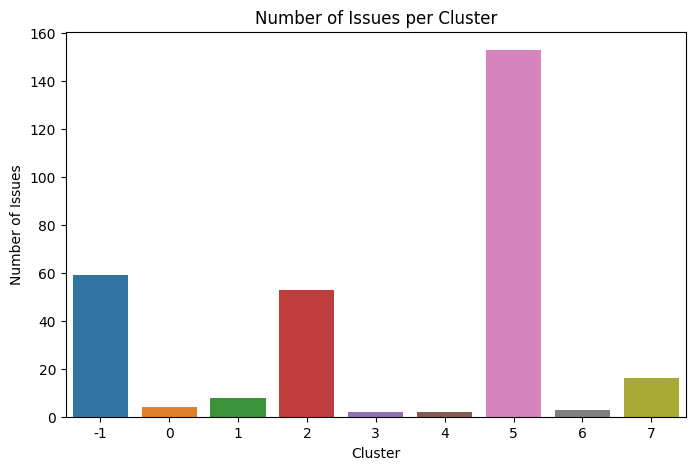

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(x='hdbscan_cluster_new', data=df, palette='tab10')
plt.title('Number of Issues per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Issues')
plt.show()


/tmp/ipython-input-1960378727.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hdbscan_cluster_new', y='difficulty_score', data=df, palette='tab10')


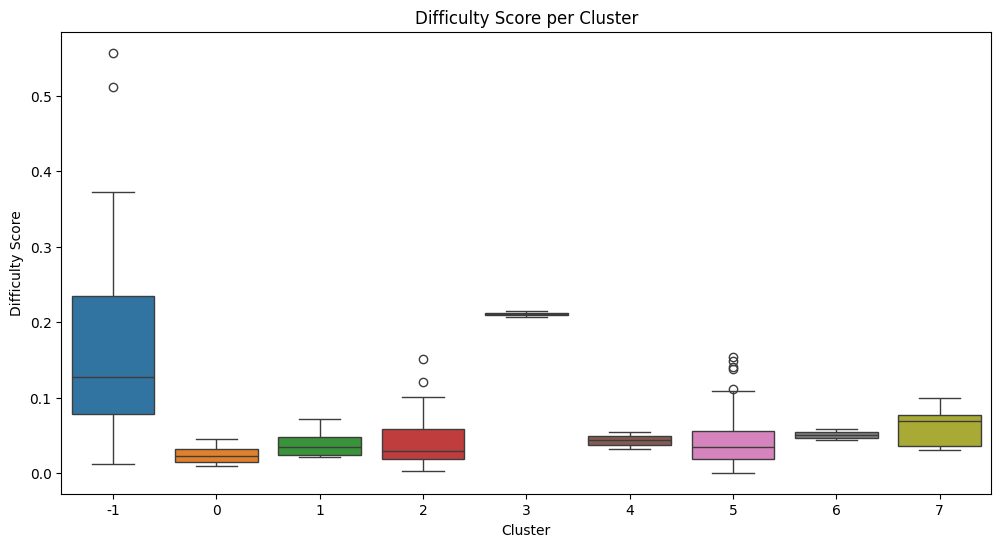

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x='hdbscan_cluster_new', y='difficulty_score', data=df, palette='tab10')
plt.title('Difficulty Score per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Difficulty Score')
plt.savefig(analysis_path + "difficulty_score_per_cluster.pdf")
plt.show()


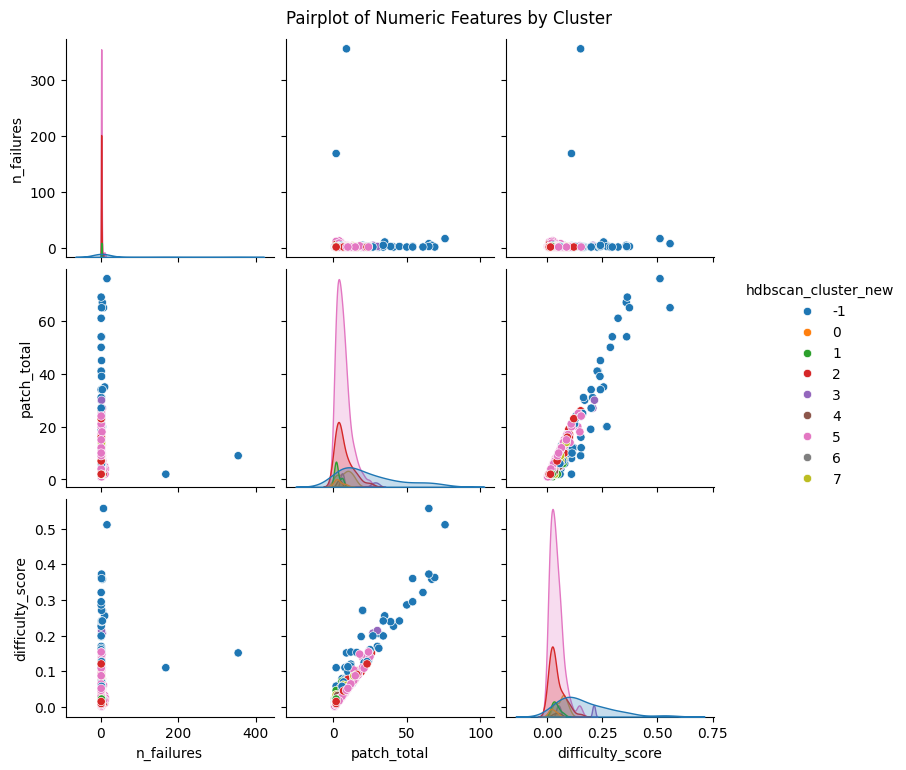

In [ ]:
sns.pairplot(df, vars=['n_failures', 'patch_total', 'difficulty_score'],
             hue='hdbscan_cluster_new', palette='tab10', diag_kind='kde')
plt.suptitle('Pairplot of Numeric Features by Cluster', y=1.02)
plt.show()


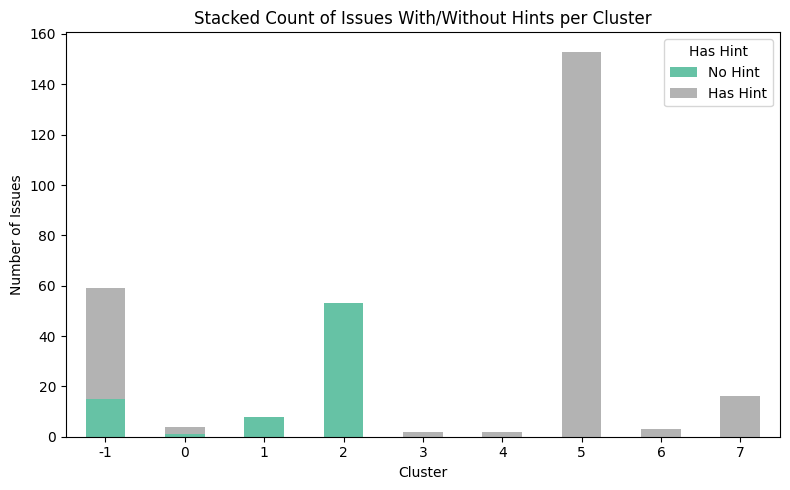

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Count of 0/1 per cluster
hint_counts = df.groupby(['hdbscan_cluster_new', 'has_hint']).size().reset_index(name='count')

# Pivot to have 0/1 as columns
pivot = hint_counts.pivot(index='hdbscan_cluster_new', columns='has_hint', values='count').fillna(0)

# Plot stacked bar
pivot.plot(kind='bar', stacked=True, figsize=(8,5), colormap='Set2')

plt.xlabel('Cluster')
plt.ylabel('Number of Issues')
plt.title('Stacked Count of Issues With/Without Hints per Cluster')
plt.xticks(rotation=0)
plt.legend(title='Has Hint', labels=['No Hint','Has Hint'])
plt.tight_layout()
plt.show()


/tmp/ipython-input-4194848641.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='hdbscan_cluster_new', y='test_n_files_touched', data=mean_test_files, palette='tab10')


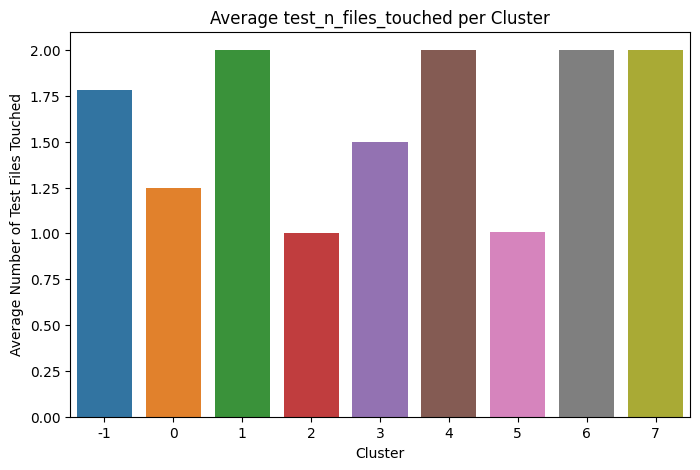

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute mean per cluster
mean_test_files = df.groupby('hdbscan_cluster_new')['test_n_files_touched'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(x='hdbscan_cluster_new', y='test_n_files_touched', data=mean_test_files, palette='tab10')
plt.title('Average test_n_files_touched per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Number of Test Files Touched')
plt.savefig(analysis_path + "average_test_files_per_cluster.pdf")
plt.show()


/tmp/ipython-input-2506657724.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hdbscan_cluster_new', y='hint_length', data=df, palette='tab10')


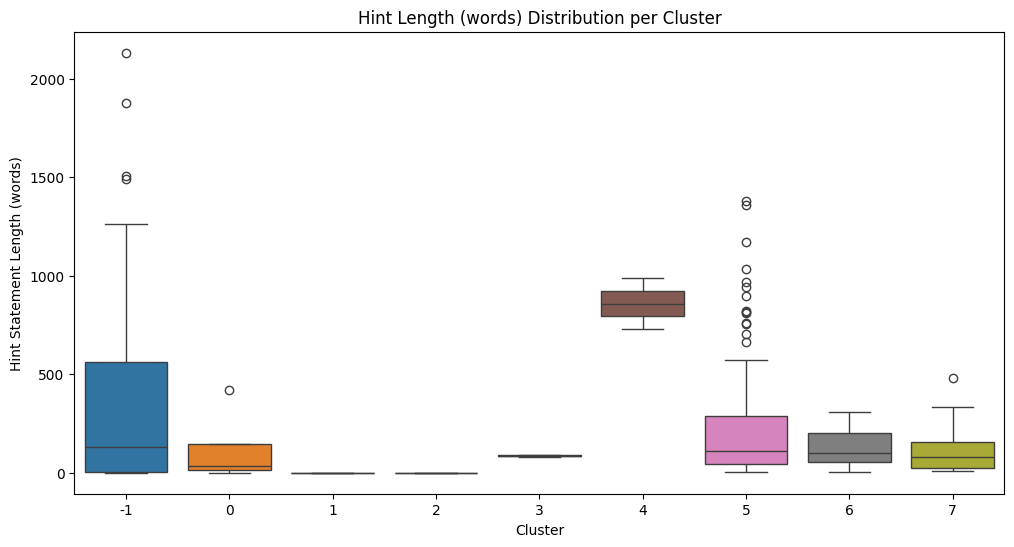

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x='hdbscan_cluster_new', y='hint_length', data=df, palette='tab10')
plt.title('Hint Length (words) Distribution per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Hint Statement Length (words)')
plt.savefig(analysis_path + "hint_length_per_cluster.pdf")
plt.show()


/tmp/ipython-input-1701584521.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hdbscan_cluster_new', y='problem_length_words', data=df, palette='tab10')


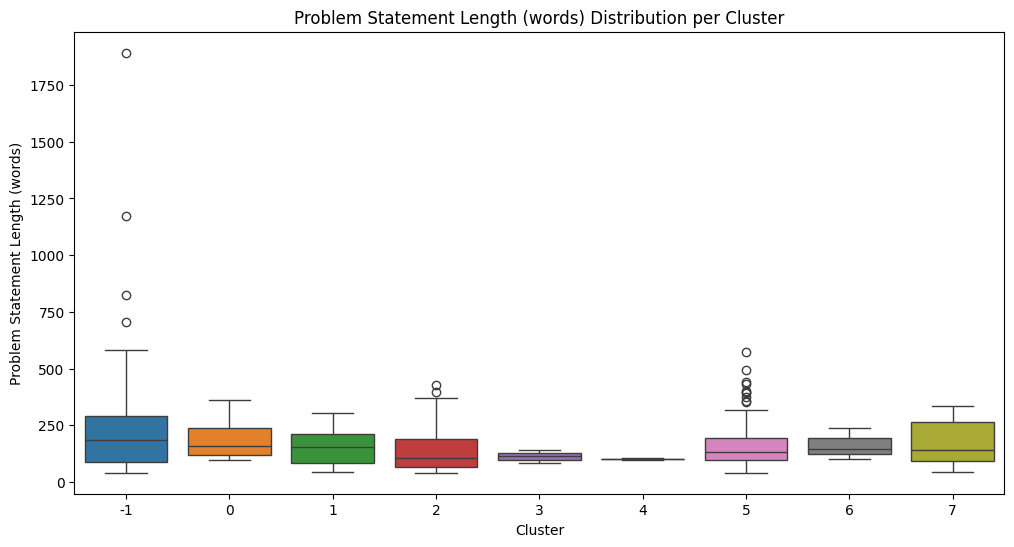

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x='hdbscan_cluster_new', y='problem_length_words', data=df, palette='tab10')
plt.title('Problem Statement Length (words) Distribution per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Problem Statement Length (words)')
plt.savefig(analysis_path + "problem_statement_length_per_cluster.pdf")
plt.show()


/tmp/ipython-input-1286638122.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hdbscan_cluster_new', y='test_patch_total', data=df, palette='tab10')


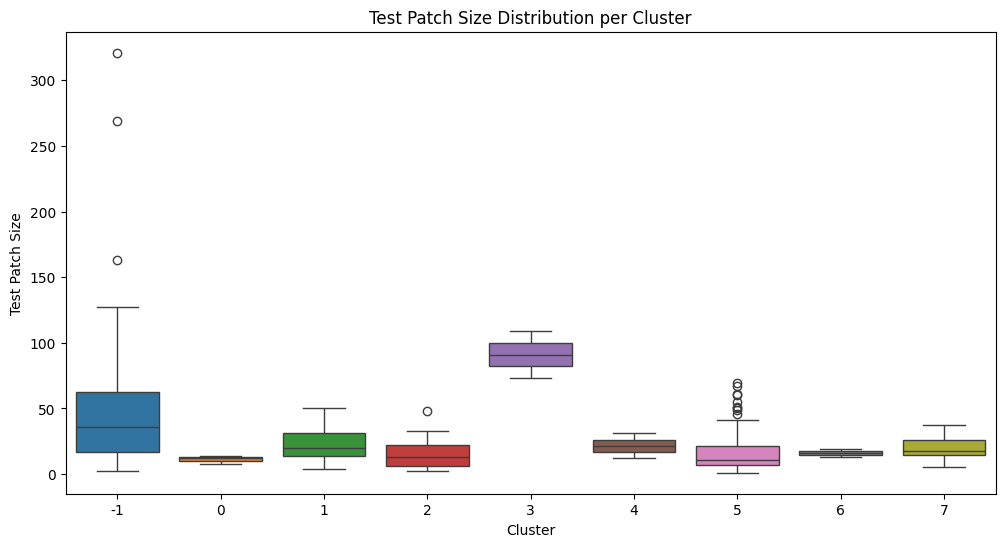

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x='hdbscan_cluster_new', y='test_patch_total', data=df, palette='tab10')
plt.title('Test Patch Size Distribution per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Test Patch Size')
plt.savefig(analysis_path + "test_patch_size_distribution_per_cluster.pdf")
plt.show()


In [ ]:
df.head()

repo             instance_id  \
0  astropy/astropy  astropy__astropy-12907   
1  astropy/astropy  astropy__astropy-14182   
2  astropy/astropy  astropy__astropy-14365   
3  astropy/astropy  astropy__astropy-14995   
4  astropy/astropy   astropy__astropy-6938   

                                base_commit  \
0  d16bfe05a744909de4b27f5875fe0d4ed41ce607   
1  a5917978be39d13cd90b517e1de4e7a539ffaa48   
2  7269fa3e33e8d02485a647da91a5a2a60a06af61   
3  b16c7d12ccbc7b2d20364b89fb44285bcbfede54   
4  c76af9ed6bb89bfba45b9f5bc1e635188278e2fa   

                                               patch  \
0  diff --git a/astropy/modeling/separable.py b/a...   
1  diff --git a/astropy/io/ascii/rst.py b/astropy...   
2  diff --git a/astropy/io/ascii/qdp.py b/astropy...   
3  diff --git a/astropy/nddata/mixins/ndarithmeti...   
4  diff --git a/astropy/io/fits/fitsrec.py b/astr...   

                                          test_patch  \
0  diff --git a/astropy/modeling/tests/test_separ...   
1  diff --git a/astropy/io/ascii/tests/test_rst.p...   
2  diff --git a/astropy/io/ascii/tests/test_qdp.p...   
3  diff --git a/astropy/nddata/mixins/tests/test_...   
4  diff --git a/astropy/io/fits/tests/test_checks...   

                                   problem_statement  \
0  Modeling's `separability_matrix` does not comp...   
1  Please support header rows in RestructuredText...   
2  ascii.qdp Table format assumes QDP commands ar...   
3  In v5.3, NDDataRef mask propagation fails when...   
4  Possible bug in io.fits related to D exponents...   

                                          hints_text            created_at  \
0                                                NaN  2022-03-03T15:14:54Z   
1                                                NaN  2022-12-16T11:13:37Z   
2  Welcome to Astropy 👋 and thank you for your fi...  2023-02-06T19:20:34Z   
3  Welcome to Astropy 👋 and thank you for your fi...  2023-06-27T19:48:18Z   
4  It is tested with `astropy/io/fits/tests/test_...  2017-12-07T00:01:14Z   

   version                                       FAIL_TO_PASS  ...  \
0      4.3  ["astropy/modeling/tests/test_separable.py::te...  ...   
1      5.1  ["astropy/io/ascii/tests/test_rst.py::test_rst...  ...   
2      5.1  ["astropy/io/ascii/tests/test_qdp.py::test_rou...  ...   
3      5.2  ["astropy/nddata/mixins/tests/test_ndarithmeti...  ...   
4      1.3  ["astropy/io/fits/tests/test_checksum.py::Test...  ...   

  has_test_patch has_patch difficulty_score  \
0           True      True         0.016866   
1           True      True         0.230208   
2           True      True         0.024750   
3           True      True         0.039750   
4           True      True         0.029902   

                             problem_statement_clean problem_length_words  \
0  Modeling's `separability_matrix` does not comp...                  158   
1  Please support header rows in RestructuredText...                  189   
2  ascii.qdp Table format assumes QDP commands ar...                  202   
3  In v5.3, NDDataRef mask propagation fails when...                  357   
4  Possible bug in io.fits related to D exponents...                   76   

   problem_length_chars                                   hints_text_clean  \
0                  1246                                                NaN   
1                  1871                                                NaN   
2                  1339  Welcome to Astropy 👋 and thank you for your fi...   
3                  2455  Welcome to Astropy 👋 and thank you for your fi...   
4                   527  It is tested with `astropy/io/fits/tests/test_...   

  has_hint  hint_length  hdbscan_cluster_new  
0        0            0                    2  
1        0            0                   -1  
2        1          206                    5  
3        1          808                   -1  
4        1           55                    7  

[5 rows x 42 columns]

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x='hdbscan_cluster_new', y='FAIL_TO_PASS', data=df, palette='tab10')
plt.title('Count of PASS_TO_PASS distribution per Cluster')
plt.xlabel('Cluster')
plt.ylabel('PASS_TO_PASS Count')
# plt.savefig(analysis_path + "pass_to_pass_per_cluster.pdf")
plt.show()


Output hidden; open in https://colab.research.google.com to view.

/tmp/ipython-input-1648271095.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hdbscan_cluster_new', y='n_passes_after', data=df, palette='tab10')


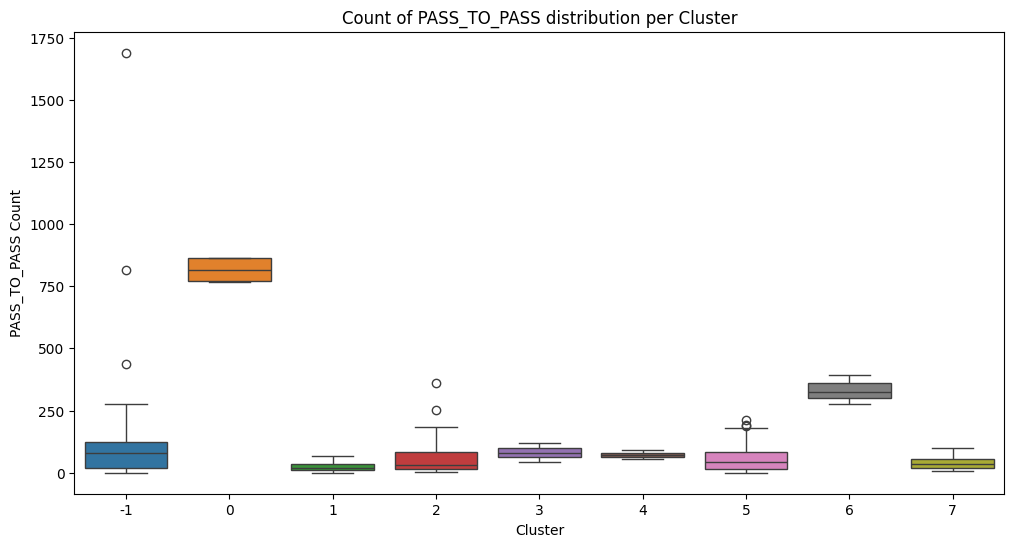

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x='hdbscan_cluster_new', y='n_passes_after', data=df, palette='tab10')
plt.title('Count of PASS_TO_PASS distribution per Cluster')
plt.xlabel('Cluster')
plt.ylabel('PASS_TO_PASS Count')
plt.savefig(analysis_path + "pass_to_pass_per_cluster.pdf")
plt.show()


/tmp/ipython-input-2432855687.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hdbscan_cluster_new', y='patch_total', data=df, palette='tab10')


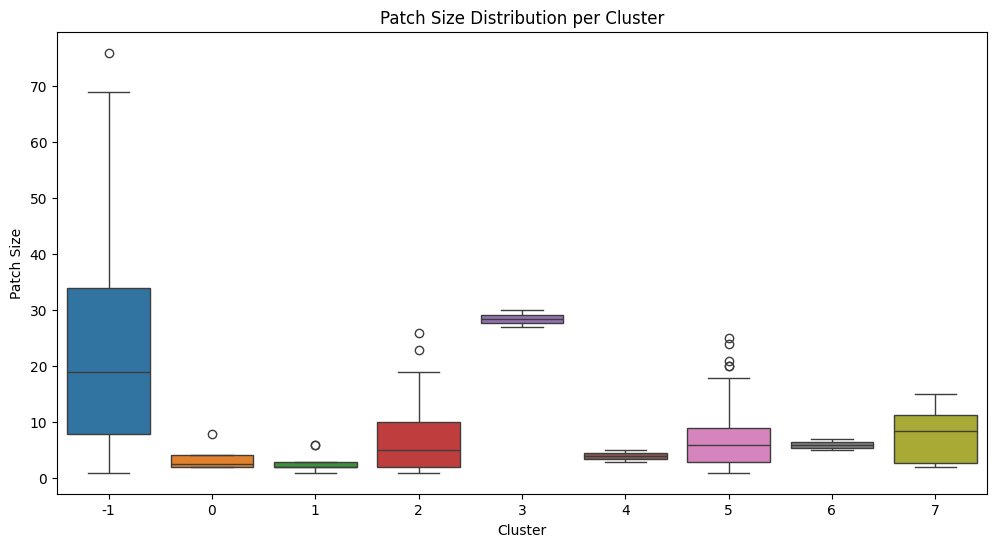

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x='hdbscan_cluster_new', y='patch_total', data=df, palette='tab10')
plt.title('Patch Size Distribution per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Patch Size')
plt.savefig(analysis_path + "patch_size_distribution_per_cluster.pdf")
plt.show()


In [ ]:
df.head()

repo             instance_id  \
0  astropy/astropy  astropy__astropy-12907   
1  astropy/astropy  astropy__astropy-14182   
2  astropy/astropy  astropy__astropy-14365   
3  astropy/astropy  astropy__astropy-14995   
4  astropy/astropy   astropy__astropy-6938   

                                base_commit  \
0  d16bfe05a744909de4b27f5875fe0d4ed41ce607   
1  a5917978be39d13cd90b517e1de4e7a539ffaa48   
2  7269fa3e33e8d02485a647da91a5a2a60a06af61   
3  b16c7d12ccbc7b2d20364b89fb44285bcbfede54   
4  c76af9ed6bb89bfba45b9f5bc1e635188278e2fa   

                                               patch  \
0  diff --git a/astropy/modeling/separable.py b/a...   
1  diff --git a/astropy/io/ascii/rst.py b/astropy...   
2  diff --git a/astropy/io/ascii/qdp.py b/astropy...   
3  diff --git a/astropy/nddata/mixins/ndarithmeti...   
4  diff --git a/astropy/io/fits/fitsrec.py b/astr...   

                                          test_patch  \
0  diff --git a/astropy/modeling/tests/test_separ...   
1  diff --git a/astropy/io/ascii/tests/test_rst.p...   
2  diff --git a/astropy/io/ascii/tests/test_qdp.p...   
3  diff --git a/astropy/nddata/mixins/tests/test_...   
4  diff --git a/astropy/io/fits/tests/test_checks...   

                                   problem_statement  \
0  Modeling's `separability_matrix` does not comp...   
1  Please support header rows in RestructuredText...   
2  ascii.qdp Table format assumes QDP commands ar...   
3  In v5.3, NDDataRef mask propagation fails when...   
4  Possible bug in io.fits related to D exponents...   

                                          hints_text            created_at  \
0                                                NaN  2022-03-03T15:14:54Z   
1                                                NaN  2022-12-16T11:13:37Z   
2  Welcome to Astropy 👋 and thank you for your fi...  2023-02-06T19:20:34Z   
3  Welcome to Astropy 👋 and thank you for your fi...  2023-06-27T19:48:18Z   
4  It is tested with `astropy/io/fits/tests/test_...  2017-12-07T00:01:14Z   

   version                                       FAIL_TO_PASS  ...  \
0      4.3  ["astropy/modeling/tests/test_separable.py::te...  ...   
1      5.1  ["astropy/io/ascii/tests/test_rst.py::test_rst...  ...   
2      5.1  ["astropy/io/ascii/tests/test_qdp.py::test_rou...  ...   
3      5.2  ["astropy/nddata/mixins/tests/test_ndarithmeti...  ...   
4      1.3  ["astropy/io/fits/tests/test_checksum.py::Test...  ...   

  has_test_patch has_patch difficulty_score  \
0           True      True         0.016866   
1           True      True         0.230208   
2           True      True         0.024750   
3           True      True         0.039750   
4           True      True         0.029902   

                             problem_statement_clean problem_length_words  \
0  Modeling's `separability_matrix` does not comp...                  158   
1  Please support header rows in RestructuredText...                  189   
2  ascii.qdp Table format assumes QDP commands ar...                  202   
3  In v5.3, NDDataRef mask propagation fails when...                  357   
4  Possible bug in io.fits related to D exponents...                   76   

   problem_length_chars                                   hints_text_clean  \
0                  1246                                                NaN   
1                  1871                                                NaN   
2                  1339  Welcome to Astropy 👋 and thank you for your fi...   
3                  2455  Welcome to Astropy 👋 and thank you for your fi...   
4                   527  It is tested with `astropy/io/fits/tests/test_...   

  has_hint  hint_length  hdbscan_cluster_new  
0        0            0                    2  
1        0            0                   -1  
2        1          206                    5  
3        1          808                   -1  
4        1           55                    7  

[5 rows x 42 columns]

In [ ]:
df.to_csv("/content/drive/MyDrive/EECS6444/RQ2/df_with_cluster.csv", index=False)